# Covid and ibd: a ***sentiment analysis***

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import os
import re
import string
import nltk
import datetime as dt
from termcolor import colored

from statistics import mean
from tqdm.notebook import tqdm,tnrange
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as SIA_VADER
from nltk.sentiment import SentimentIntensityAnalyzer as SIA_NLTK

import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.style as style 
import seaborn as sns

import researchpy as rp
import scipy.stats as stats

sns.set_style('darkgrid')
sns.set_context('paper')
style.use('ggplot')
matplotlib.rcParams['font.family'] = 'helvetica'
matplotlib.rcParams['figure.titlesize'] = 'large'

In [2]:
def import_submissions():
    path = './submissions_scraped/'
    files = []
    for filename in os.listdir(path):
        files.append(pd.read_csv(os.path.join(path, filename)))

    files = pd.concat(files)
    df_submissions = pd.DataFrame(files)
    df_submissions.drop(columns=['Unnamed: 0'], inplace=True)
    df_submissions.dropna(inplace=True)
    return df_submissions

In [3]:
def import_submissions_previous():
    path = './submissions_scraped_previous/'
    files = []
    for filename in os.listdir(path):
        files.append(pd.read_csv(os.path.join(path, filename)))

    files = pd.concat(files)
    df_submissions = pd.DataFrame(files)
    df_submissions.drop(columns=['Unnamed: 0'], inplace=True)
    
    return df_submissions

In [4]:
def import_comments():
    df_comments = pd.read_csv('./comments_scraped/comments.csv')
    df_comments.drop(columns=['Unnamed: 0'], inplace=True)
    df_comments.dropna(inplace=True)
    return df_comments

In [5]:
def import_comments_previous():
    df_comments = pd.read_csv('./comments_scraped_previous/comments.csv')
    df_comments.drop(columns=['Unnamed: 0'], inplace=True)
    return df_comments

In [6]:
def clean_text(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    text = re.sub('^\[removed\]|^\[deleted\]', '', str(text))
    text = re.sub('^\[deleted by user\]', '', str(text))
    text = re.sub('^nan', '', str(text))
    text = re.sub(r'#', '',  str(text))
    text = re.sub(r"(?:\@|https?\://)\S+", "", str(text))
    text = re.sub(r'[^\x00-\x7f]',r'', str(text))
    text = re.sub(r'www\S+', '',  str(text)) 
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

In [7]:
def is_positive(compound):
    if compound > 0.05:
        return 1
    elif compound < -0.05:
        return -1
    else:
        return 0

In [8]:
subreddits = ['CrohnsDisease', 'IBD', 'UlcerativeColitis', 'ibs']
colors = ['#cc5a49', '#4586ac', '#9e97cc', '#777777']

# Data before 12-2020
df_sub_prev = import_submissions_previous()
df_comm_prev = import_comments_previous()

# Data after 12-2020
df_sub_aft = import_submissions()
df_comm_aft = import_comments()

df_submissions = pd.concat([df_sub_prev, df_sub_aft])
df_comments = pd.concat([df_comm_prev, df_comm_aft])

df_submissions['title_and_body'] = df_submissions['title'] + ' ' + df_submissions['body']
df_submissions['title_and_body'] = df_submissions['title_and_body'].apply(lambda x: clean_text(str(x)))

df_comments['body'] = df_comments.body.apply(lambda x: clean_text(str(x)))

df_submissions = df_submissions[df_submissions['title_and_body'] != '']
df_comments = df_comments[df_comments['body'] != '']

df_submissions['created'] = pd.to_datetime(df_submissions['created'])
df_comments['created'] = pd.to_datetime(df_comments['created'])
df_comments = df_comments[df_comments['created'] < dt.datetime(2022, 10, 1)]

## Sentiment analysis usign vader

In [9]:
sia_vader = SIA_VADER()

### Analysis on submissions

In [10]:
cmap = matplotlib.cm.get_cmap('magma')
main_color = cmap(0.3)

In [11]:
sentiments = []
compounds = []
for post in tqdm(df_submissions.title_and_body, desc='Analyzing with vader'):
    scores = sia_vader.polarity_scores(post)
    sentiments.append(sia_vader.polarity_scores(post))
    compounds.append(scores['compound'])
    
    
df_submissions['sia_vader'] = sentiments
df_submissions['compound'] = compounds

Analyzing with vader:   0%|          | 0/82471 [00:00<?, ?it/s]

In [12]:
df_submissions['label'] = df_submissions['compound'].apply(lambda x: is_positive(x))

In [13]:
rates = []
for sr in subreddits:
    dd = df_submissions[df_submissions['subreddit'] == sr]
    dd_pos = dd[dd['label'] == 1]
    dd_neg = dd[dd['label'] == -1]
    dd_neu = dd[dd['label'] == 0]
    pos_rate = dd_pos.shape[0] / df_submissions[df_submissions['subreddit'] == sr].shape[0]
    neg_rate = dd_neg.shape[0] / df_submissions[df_submissions['subreddit'] == sr].shape[0]
    neu_rate = dd_neu.shape[0] / df_submissions[df_submissions['subreddit'] == sr].shape[0]
    
    rates.append((pos_rate, sr, 1))
    rates.append((neg_rate, sr, -1))
    rates.append((neu_rate, sr, 0))
    
rates = pd.DataFrame(rates, columns=['rate', 'subreddit', 'label'])

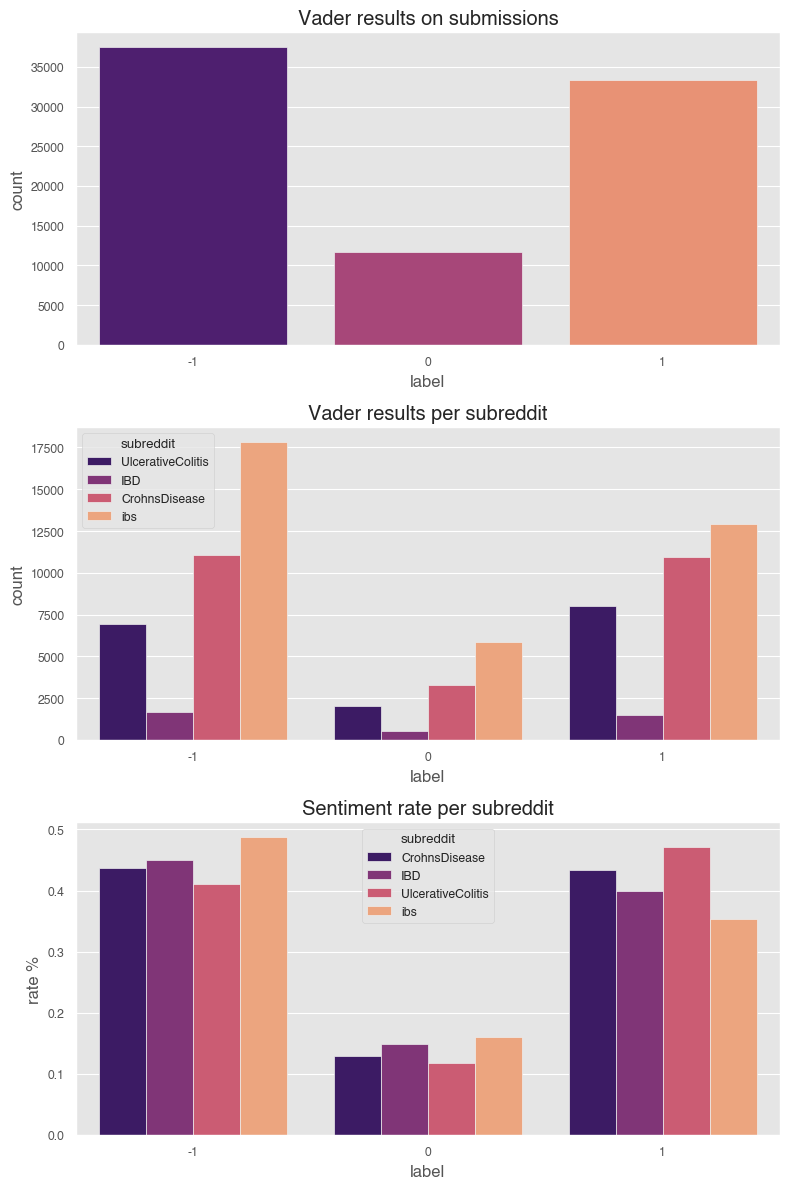

In [14]:
fig, [ax1, ax2, ax3] = plt.subplots(figsize=(8,12), ncols=1, nrows=3)

sns.countplot(data=df_submissions, x='label', ax=ax1, palette='magma')
ax1.set_title('Vader results on submissions')

sns.countplot(data=df_submissions, x='label', hue='subreddit', ax=ax2, palette='magma')
ax2.set_title('Vader results per subreddit')

sns.barplot(data=rates, x='label', y='rate', hue='subreddit', palette='magma', ax=ax3)
plt.title('Sentiment rate per subreddit')
ax3.set_ylabel('rate %')

plt.tight_layout()
plt.show();

In [15]:
df_submissions.created = df_submissions.created.apply(lambda x: x.strftime('%y-%m'))
df_submissions.sort_values('created', inplace=True)

In [16]:
compound_by_month = df_submissions.groupby('created').sum('compound').compound.values
number_of_posts_over_time = df_submissions.groupby('created').count().compound.values
sub_avg_sentiments = []
for i in range(0, len(compound_by_month)):
    sub_avg_sentiments.append(compound_by_month[i] / number_of_posts_over_time[i])

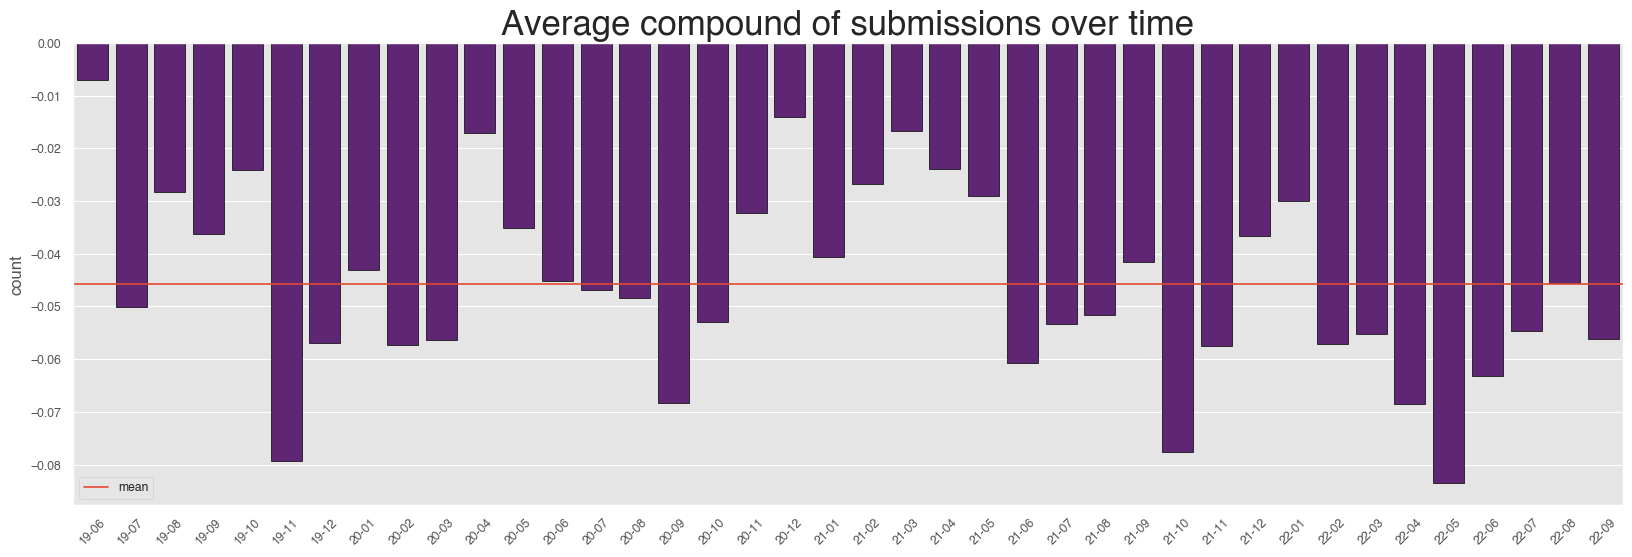

In [17]:
fig, ax = plt.subplots(figsize=(20,6))

plt.title('Average compound of submissions over time', fontsize=25)
sns.barplot(x=df_submissions.created.unique(), y=sub_avg_sentiments, color=main_color, edgecolor='black')
plt.ylabel('count')
plt.xlabel('')
plt.xticks(rotation=45)
plt.axhline(mean(sub_avg_sentiments), label='mean')

plt.legend()
plt.show();

In [18]:
df_sub_crohn = df_submissions[df_submissions['subreddit'] == 'CrohnsDisease']
df_sub_ibd = df_submissions[df_submissions['subreddit'] == 'IBD']
df_sub_ibs = df_submissions[df_submissions['subreddit'] == 'ibs']
df_sub_ulc = df_submissions[df_submissions['subreddit'] == 'UlcerativeColitis']

sub_crohn_by_month = df_sub_crohn.groupby('created').sum('compound').compound.values
sub_crohn_posts_ov_time = df_sub_crohn.groupby('created').count().compound.values
sub_crohn_avg_comp = []
for i in range(0, len(sub_crohn_by_month)):
    sub_crohn_avg_comp.append(sub_crohn_by_month[i] / sub_crohn_posts_ov_time[i])
    
sub_ibd_by_month = df_sub_ibd.groupby('created').sum('compound').compound.values
sub_ibd_posts_ov_time = df_sub_ibd.groupby('created').count().compound.values
sub_ibd_avg_comp = []
for i in range(0, len(sub_ibd_by_month)):
    sub_ibd_avg_comp.append(sub_ibd_by_month[i] / sub_ibd_posts_ov_time[i])
    
sub_ibs_by_month = df_sub_ibs.groupby('created').sum('compound').compound.values
sub_ibs_posts_ov_time = df_sub_ibs.groupby('created').count().compound.values
sub_ibs_avg_comp = []
for i in range(0, len(sub_ibs_by_month)):
    sub_ibs_avg_comp.append(sub_ibs_by_month[i] / sub_ibs_posts_ov_time[i])
    
sub_ulc_by_month = df_sub_ulc.groupby('created').sum('compound').compound.values
sub_ulc_posts_ov_time = df_sub_ulc.groupby('created').count().compound.values
sub_ulc_avg_comp = []
for i in range(0, len(sub_ulc_by_month)):
    sub_ulc_avg_comp.append(sub_ulc_by_month[i] / sub_ulc_posts_ov_time[i])
    
df_sub_avg_compounds = pd.DataFrame({
    'month': df_submissions.created.unique(),
    'crohn': sub_crohn_avg_comp,
    'ibd': sub_ibd_avg_comp,
    'ibs': sub_ibs_avg_comp,
    'ulc': sub_ulc_avg_comp
})

df_sub_avg_compounds.set_index('month');

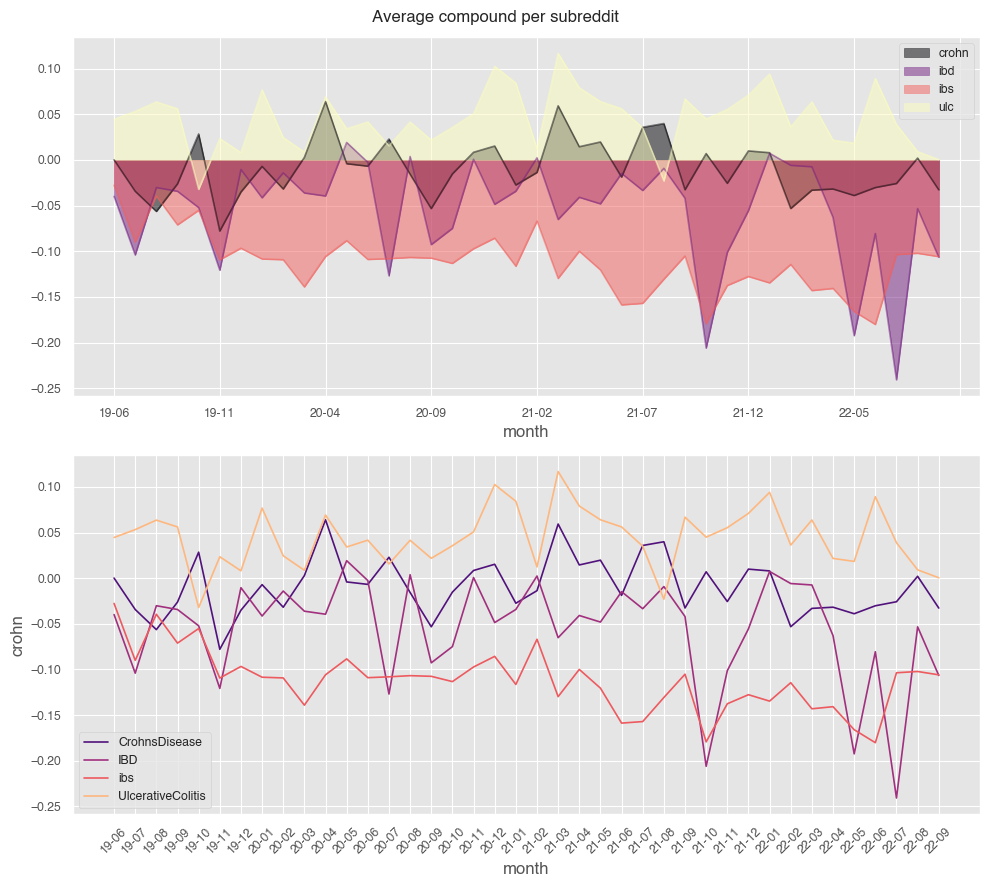

In [19]:
fig, [ax1, ax2] = plt.subplots(figsize=(10,9), nrows=2)

plt.suptitle('Average compound per subreddit')
df_sub_avg_compounds.plot(x='month', kind='area', stacked=False, ax=ax1, colormap='magma')

sns.lineplot(x=df_sub_avg_compounds.month, y=df_sub_avg_compounds.crohn, ax=ax2, label='CrohnsDisease', color=cmap(0.25))
sns.lineplot(x=df_sub_avg_compounds.month, y=df_sub_avg_compounds.ibd, ax=ax2, label='IBD', color=cmap(0.45))
sns.lineplot(x=df_sub_avg_compounds.month, y=df_sub_avg_compounds.ibs, ax=ax2, label='ibs', color=cmap(0.65))
sns.lineplot(x=df_sub_avg_compounds.month, y=df_sub_avg_compounds.ulc, ax=ax2, label='UlcerativeColitis', color=cmap(0.85))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show();

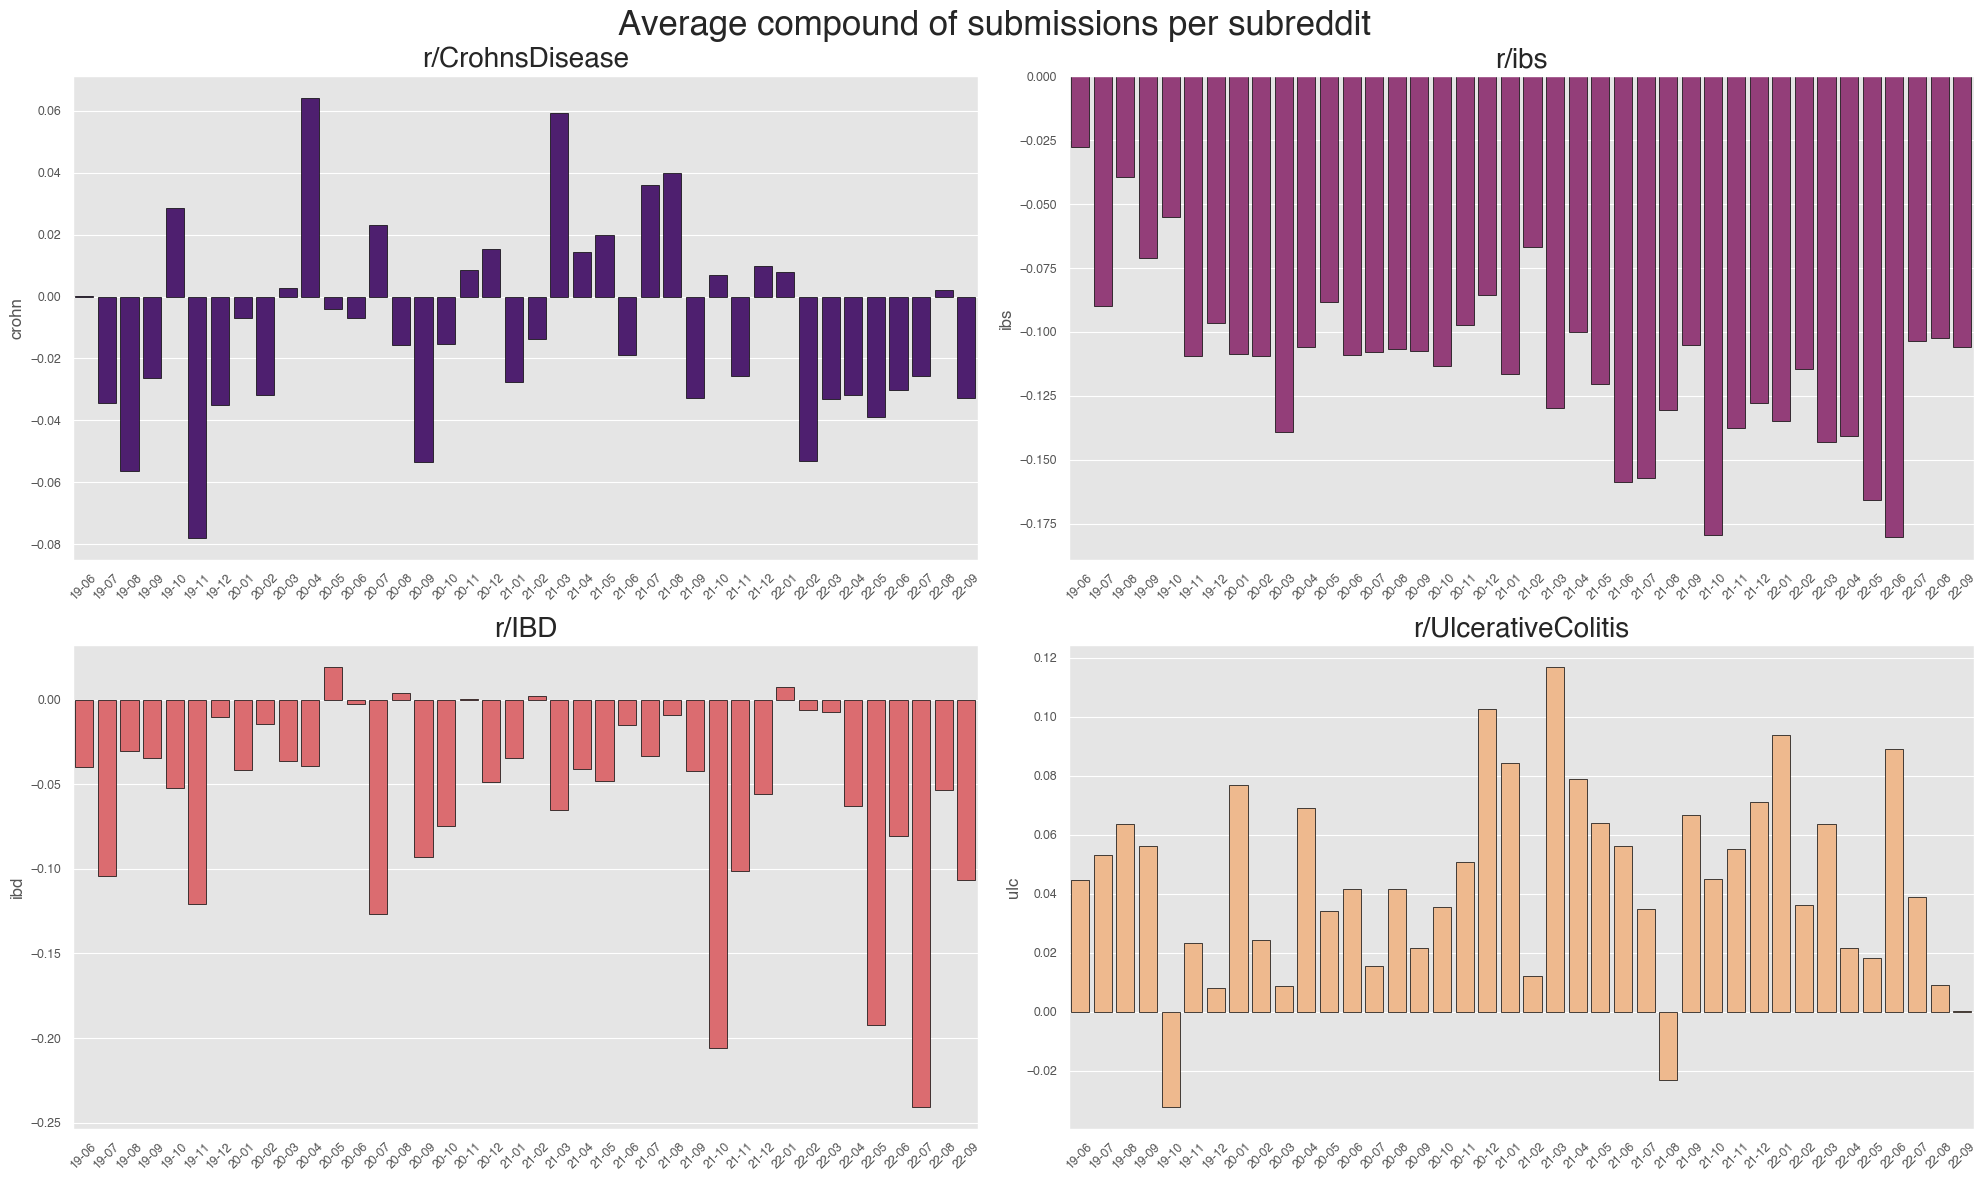

In [20]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20,12), ncols=2, nrows=2)

plt.suptitle('Average compound of submissions per subreddit', fontsize=25)

sns.barplot(x=df_submissions.created.unique(), y=df_sub_avg_compounds.crohn, color=cmap(0.25), edgecolor='Black', ax=ax1)
ax1.set_title('r/CrohnsDisease', fontsize=20)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

sns.barplot(x=df_submissions.created.unique(), y=df_sub_avg_compounds.ibs, color=cmap(0.45), edgecolor='Black', ax=ax2)
ax2.set_title('r/ibs', fontsize=20)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

sns.barplot(x=df_submissions.created.unique(), y=df_sub_avg_compounds.ibd, color=cmap(0.65), edgecolor='Black', ax=ax3)
ax3.set_title('r/IBD', fontsize=20)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

sns.barplot(x=df_submissions.created.unique(), y=df_sub_avg_compounds.ulc, color=cmap(0.85), edgecolor='Black', ax=ax4)
ax4.set_title('r/UlcerativeColitis', fontsize=20)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show();

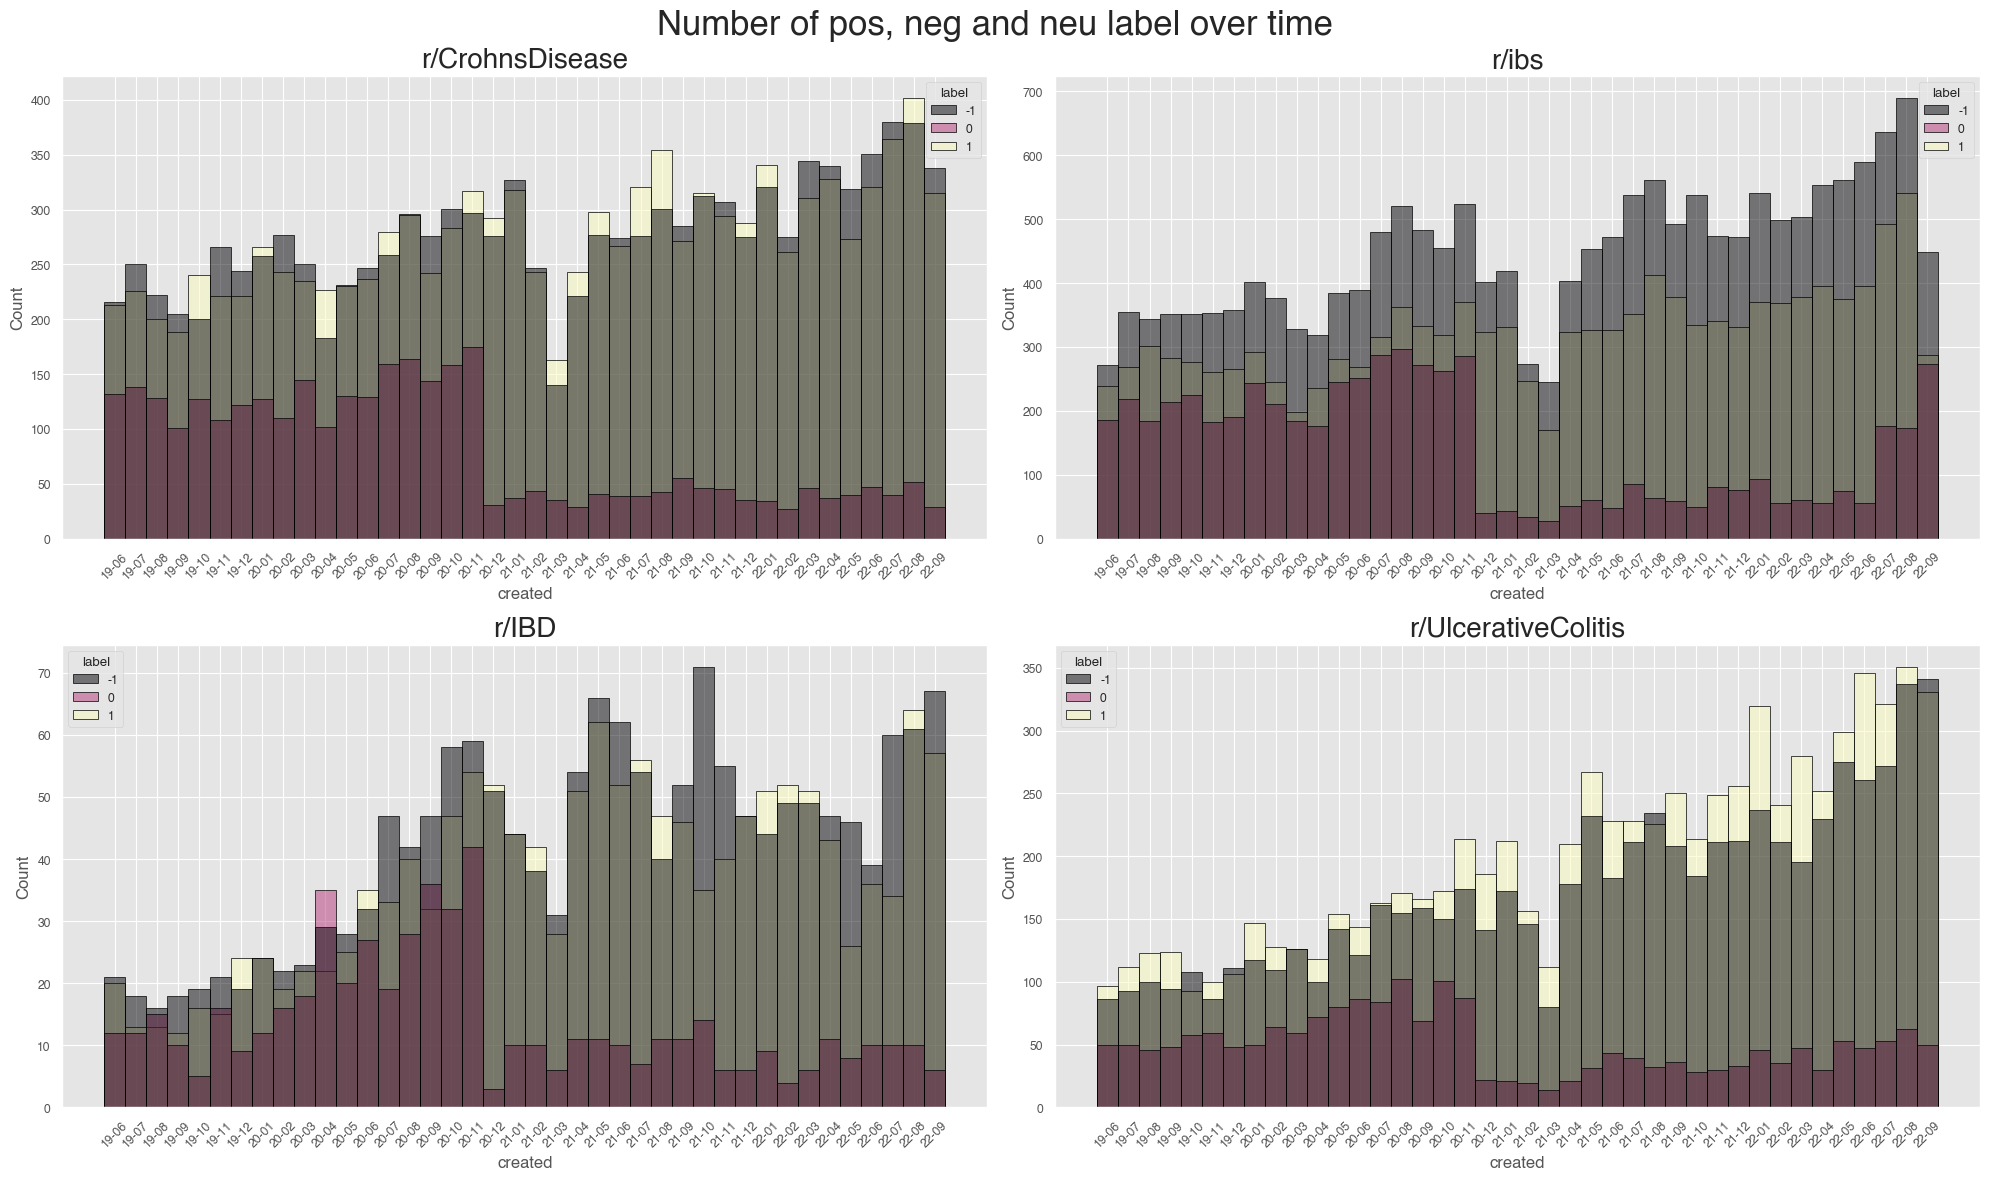

In [21]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20,12), ncols=2, nrows=2)

plt.suptitle('Number of pos, neg and neu label over time', fontsize=25)

sns.histplot(data=df_submissions[df_submissions['subreddit'] == 'CrohnsDisease'], edgecolor='Black',
              hue='label', x='created', palette='magma', ax=ax1)
ax1.set_title('r/CrohnsDisease', fontsize=20)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

sns.histplot(data=df_submissions[df_submissions['subreddit'] == 'ibs'], edgecolor='Black',
              hue='label', x='created', palette='magma', ax=ax2)
ax2.set_title('r/ibs', fontsize=20)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

sns.histplot(data=df_submissions[df_submissions['subreddit'] == 'IBD'], edgecolor='Black',
              hue='label', x='created', palette='magma', ax=ax3)
ax3.set_title('r/IBD', fontsize=20)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

sns.histplot(data=df_submissions[df_submissions['subreddit'] == 'UlcerativeColitis'], edgecolor='Black',
              hue='label', x='created', palette='magma', ax=ax4)
ax4.set_title('r/UlcerativeColitis', fontsize=20)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show();

#### Does the distribution of negatives submissions changed after covid ?

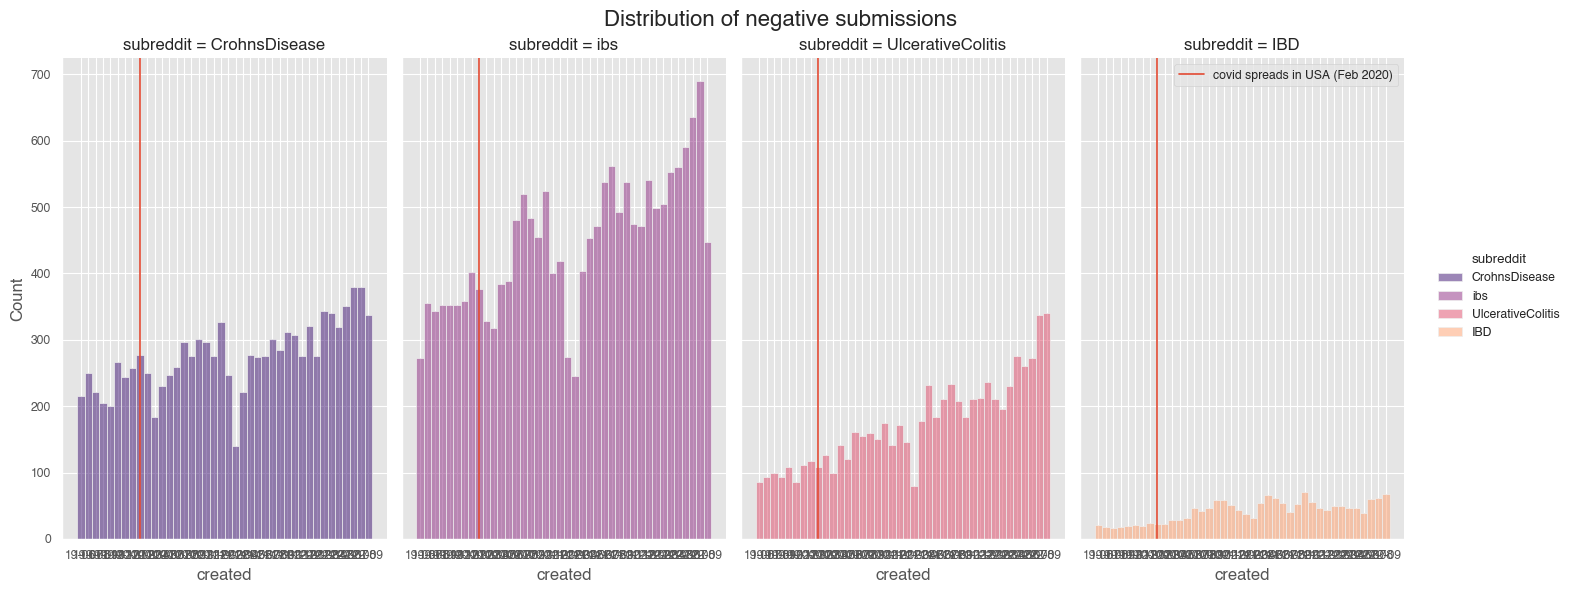

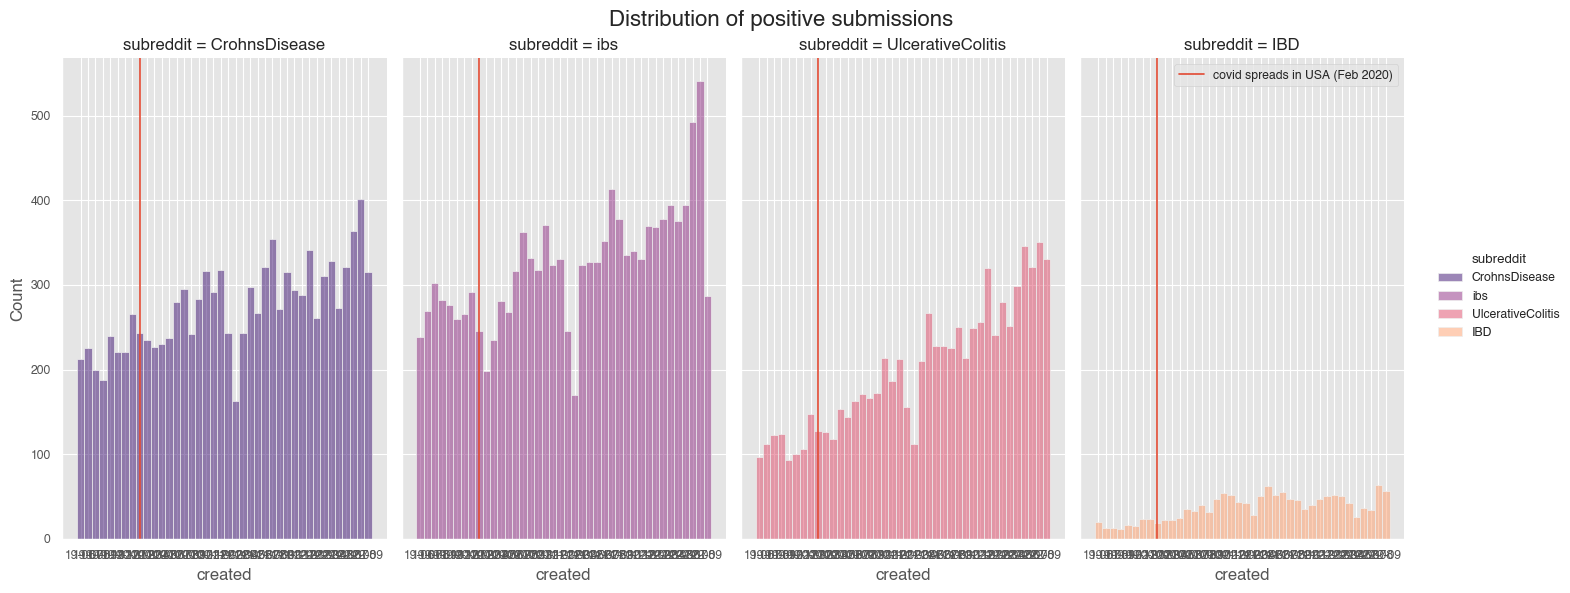

In [22]:
g = sns.displot(data=df_submissions[df_submissions['label'] == -1], 
                x='created',
                col='subreddit',
                hue='subreddit',
                palette='magma', height=6, aspect=0.6)

axes = g.axes.flatten()
for ax in axes:
    ax.axvline(8, label='covid spreads in USA (Feb 2020)')
    
g.figure.subplots_adjust(top=0.9);
g.figure.suptitle(
    'Distribution of negative submissions',
    fontsize=16
);

plt.legend();

g = sns.displot(data=df_submissions[df_submissions['label'] == 1], 
                x='created',
                col='subreddit',
                hue='subreddit',
                palette='magma', height=6, aspect=0.6)

axes = g.axes.flatten()
for ax in axes:
    ax.axvline(8, label='covid spreads in USA (Feb 2020)')
    
g.figure.subplots_adjust(top=0.9);
g.figure.suptitle(
    'Distribution of positive submissions',
    fontsize=16
);


plt.legend();

#### Do people comment more when the post has a strong sentiment ?

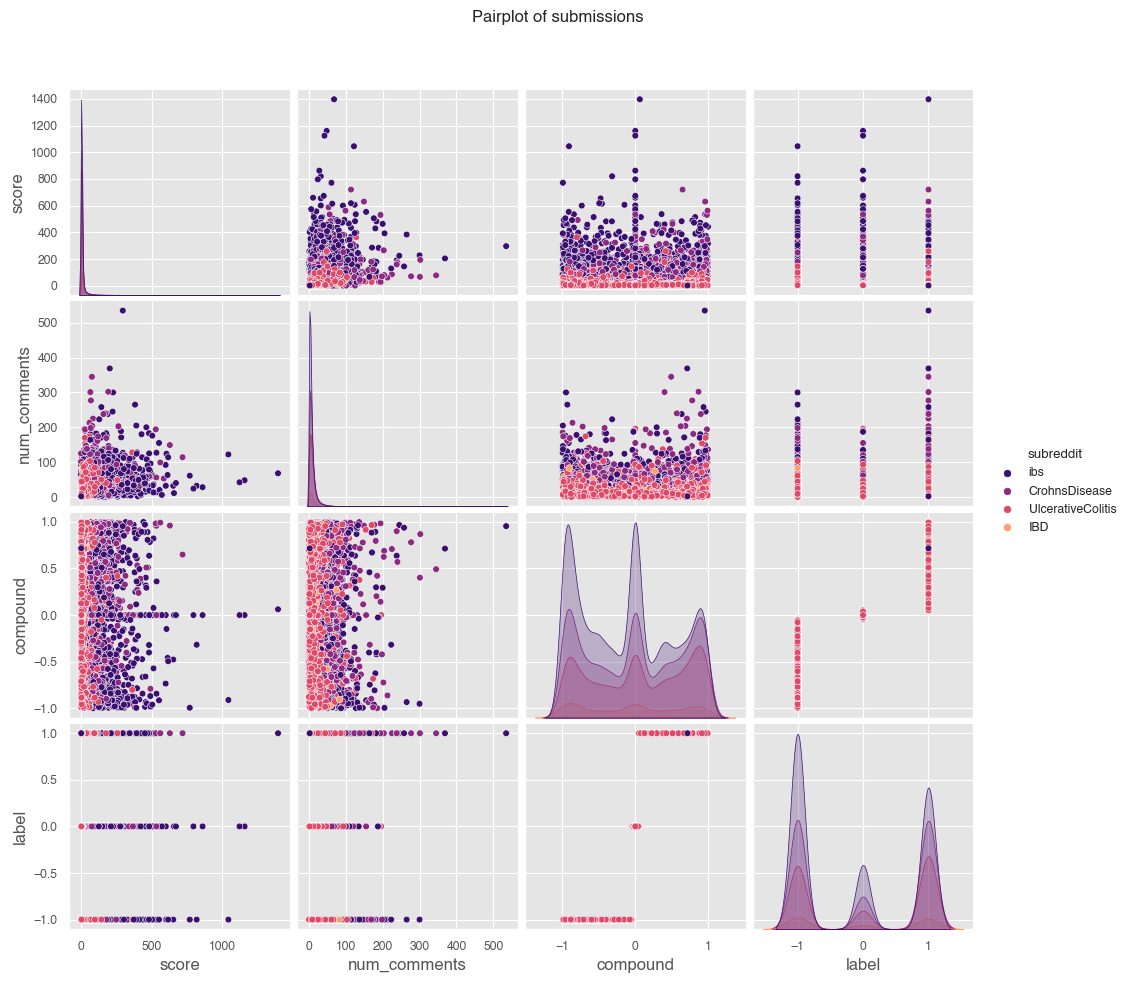

In [23]:
g = sns.pairplot(df_submissions, hue='subreddit', palette='magma')

g.figure.subplots_adjust(top=0.9);
g.figure.suptitle(
    'Pairplot of submissions',
    fontsize=12
);

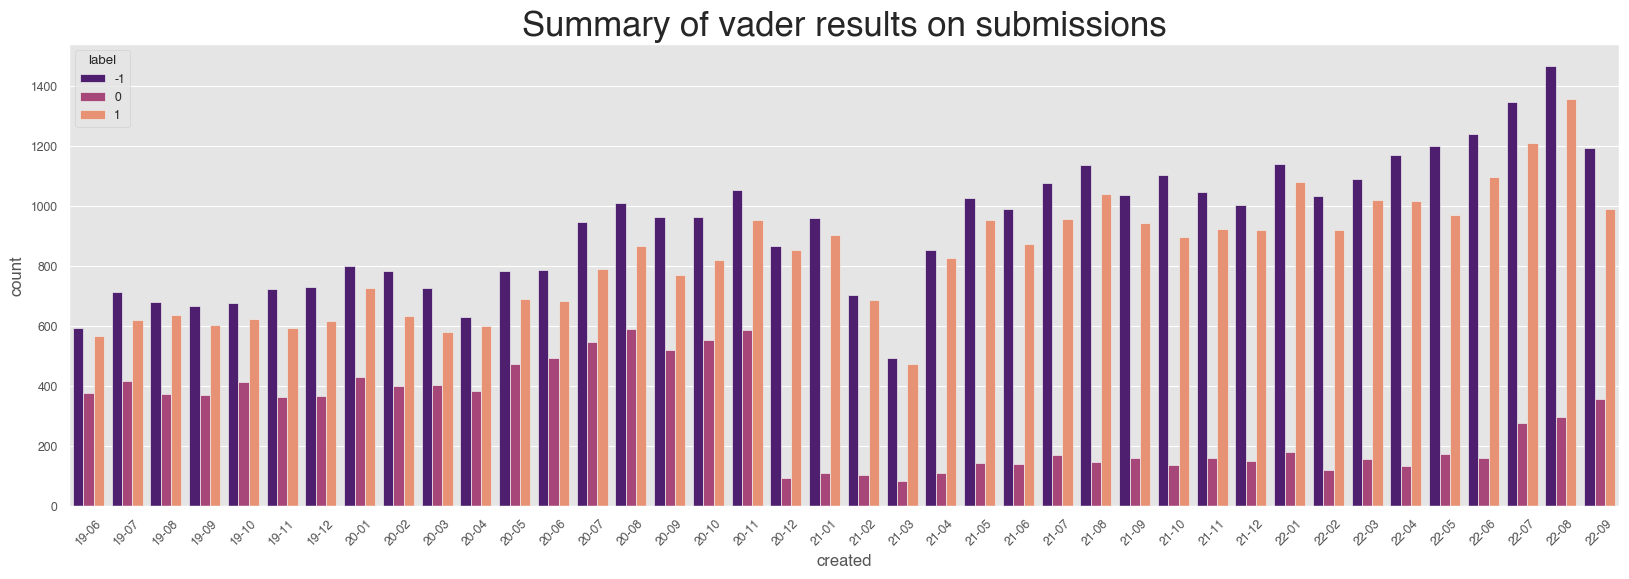

In [24]:
fig, ax = plt.subplots(figsize=(20,6))

sns.countplot(x='created', hue='label', data=df_submissions, palette='magma')
plt.title('Summary of vader results on submissions', fontsize=25)
plt.xticks(rotation=45)
plt.show();

### T-test on submissions

### Compound analysis

In [25]:
df_c = df_submissions.groupby('created').mean('compound').reset_index().copy()
df_c.drop(columns=['score', 'num_comments', 'label'], inplace=True)
df_c.columns = ['month', 'avg_compound']

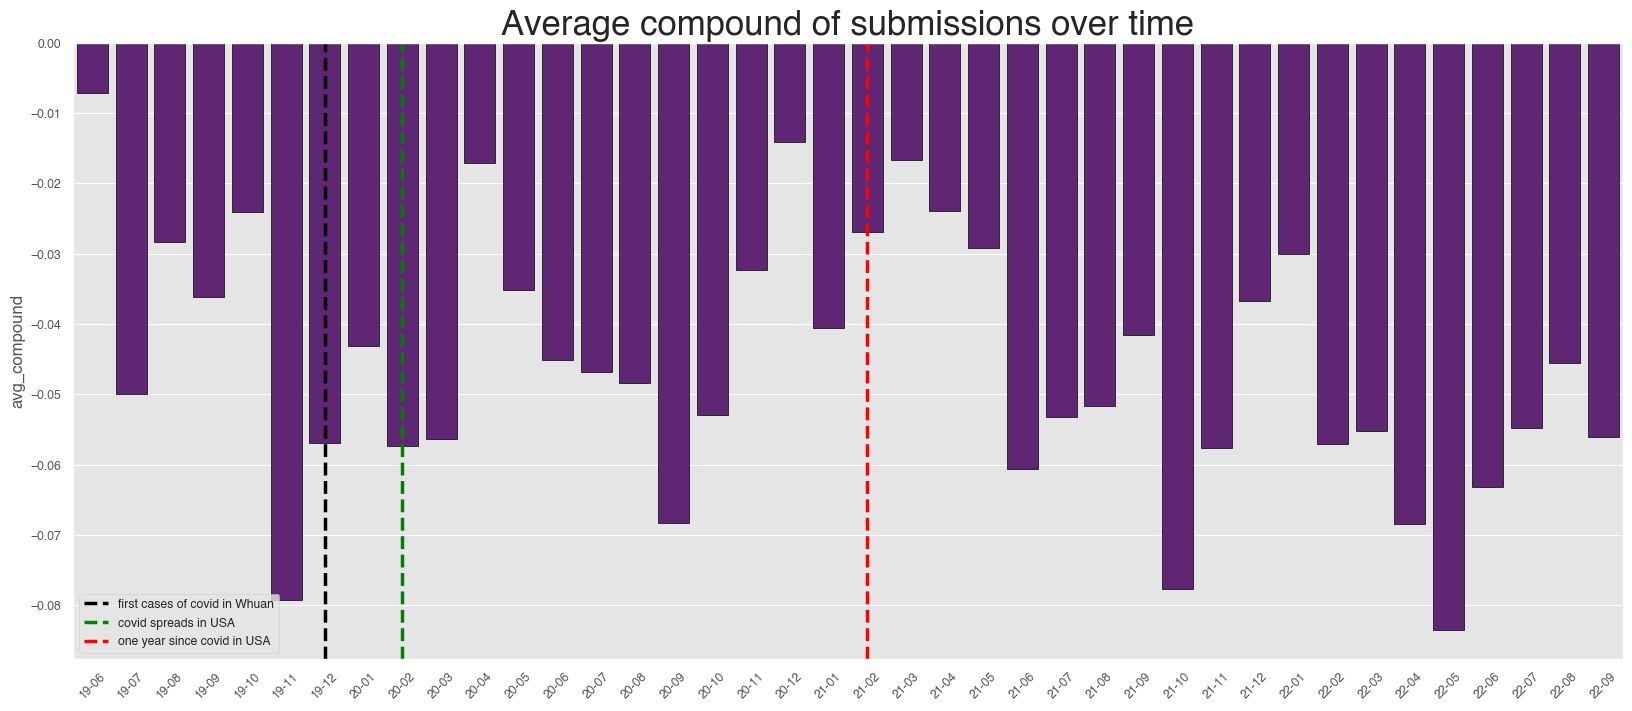

In [26]:
fig, ax = plt.subplots(figsize=(20,8))

plt.title('Average compound of submissions over time', fontsize=25)
sns.barplot(x=df_c.month.unique(), y=df_c.avg_compound, color=main_color, edgecolor='black')
ax.axvline(x=6, linestyle='--', linewidth=2.5, color='black', label='first cases of covid in Whuan')
ax.axvline(x=8, linestyle='--', linewidth=2.5, color='green', label='covid spreads in USA')
ax.axvline(x=20, linestyle='--', linewidth=2.5, color='red', label='one year since covid in USA')
plt.xticks(rotation=45)

plt.legend()
plt.show();

In [27]:
avg_sub_comp_bef_covid = df_c[(df_c['month'] <= '20-02')].avg_compound
avg_sub_comp_aft_covid = df_c[(df_c['month'] > '20-02')].avg_compound
avg_sub_comp_aft_one_year_covid = df_c[(df_c['month'] > '20-02') & (df_c['month'] <= '21-02')].avg_compound

#### Independent T-test on submission compound

Before and **After** Covid

In [28]:
%%capture
summary, results = rp.ttest(group1 = avg_sub_comp_bef_covid, group1_name= 'compound before covid', 
                            group2 = avg_sub_comp_aft_covid, group2_name='compound after covid')

In [29]:
display(summary)
display(results)

Variable     N      Mean        SD        SE  95% Conf.  \
0  compound before covid   9.0 -0.042480  0.021435  0.007145  -0.058956   
1   compound after covid  31.0 -0.046663  0.017518  0.003146  -0.053089   
2               combined  40.0 -0.045722  0.018260  0.002887  -0.051562   

   Interval  
0 -0.026004  
1 -0.040237  
2 -0.039882

Independent t-test  results
0  Difference (compound before covid - compound a...   0.0042
1                              Degrees of freedom =   38.0000
2                                               t =    0.6000
3                           Two side test p value =    0.5521
4                          Difference < 0 p value =    0.7240
5                          Difference > 0 p value =    0.2760
6                                       Cohen's d =    0.2272
7                                       Hedge's g =    0.2227
8                                  Glass's delta1 =    0.1951
9                                Point-Biserial r =    0.0969

#### Independent T-test on submission compound

Before and **After one year** Covid

In [30]:
%%capture
summary, results = rp.ttest(group1 = avg_sub_comp_bef_covid, group1_name= 'comp before covid', 
                            group2 = avg_sub_comp_aft_one_year_covid, group2_name='comp after one year of covid')

In [31]:
display(summary)
display(results)

Variable     N      Mean        SD        SE  \
0             comp before covid   9.0 -0.042480  0.021435  0.007145   
1  comp after one year of covid  12.0 -0.040334  0.016022  0.004625   
2                      combined  21.0 -0.041254  0.018060  0.003941   

   95% Conf.  Interval  
0  -0.058956 -0.026004  
1  -0.050514 -0.030154  
2  -0.049474 -0.033033

Independent t-test  results
0  Difference (comp before covid - comp after one...  -0.0021
1                              Degrees of freedom =   19.0000
2                                               t =   -0.2632
3                           Two side test p value =    0.7952
4                          Difference < 0 p value =    0.3976
5                          Difference > 0 p value =    0.6024
6                                       Cohen's d =   -0.1161
7                                       Hedge's g =   -0.1114
8                                  Glass's delta1 =   -0.1001
9                                Point-Biserial r =   -0.0603

In [32]:
df_mean_compounds_sub = df_submissions.groupby(['subreddit', 'created']).mean('compound').reset_index()

p_values = []
for sr in subreddits:
    a = df_mean_compounds_sub[(df_mean_compounds_sub['subreddit'] == sr) & (df_mean_compounds_sub['created'] <= '20-02')].compound
    b = df_mean_compounds_sub[(df_mean_compounds_sub['subreddit'] == sr) & (df_mean_compounds_sub['created'] > '20-02')].compound
    p_values.append((stats.ttest_ind(a, b).pvalue, sr, 'full period (Feb 2020 to Sept 2022)'))

for sr in subreddits:
    a = df_mean_compounds_sub[(df_mean_compounds_sub['subreddit'] == sr) & (df_mean_compounds_sub['created'] <= '20-02')].compound
    b = df_mean_compounds_sub[(df_mean_compounds_sub['subreddit'] == sr) & (df_mean_compounds_sub['created'] > '20-02') & (df_mean_compounds_sub['created'] <= '21-02')].compound
    p_values.append((stats.ttest_ind(a, b).pvalue, sr, 'one year (Feb 2020 to Feb 2021)'))

p_values = pd.DataFrame(p_values, columns=['p_value', 'subreddit', 'type'])

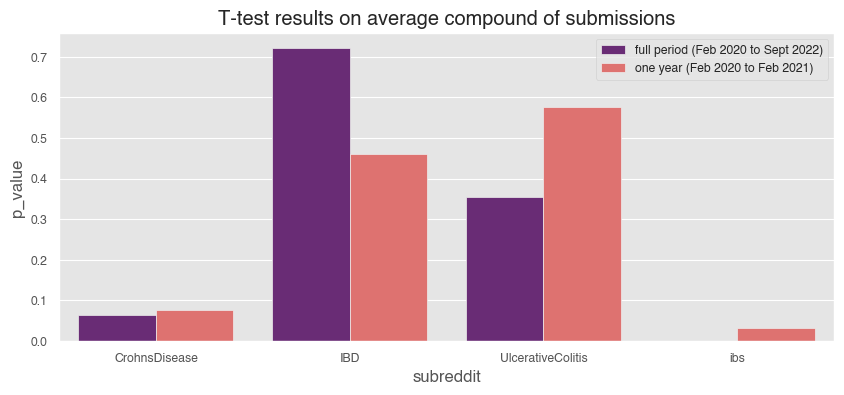

In [33]:
fig, ax = plt.subplots(figsize=(10,4))

plt.title('T-test results on average compound of submissions')
sns.barplot(data=p_values, hue='type', x=p_values.subreddit, y=p_values.p_value, palette='magma')

plt.legend()
plt.show();

### Label analysis

In [34]:
df_sub_neg_labels = df_submissions[df_submissions['label'] == -1].groupby('created').count().reset_index()
df_sub_neg_labels = df_sub_neg_labels[['id', 'created']]

neg_labels_sub_bef_cov = df_sub_neg_labels[df_sub_neg_labels['created'] <= '20-02']
neg_labels_sub_aft_cov = df_sub_neg_labels[df_sub_neg_labels['created'] > '20-02']
neg_labels_sub_aft_one_year_cov = df_sub_neg_labels[(df_sub_neg_labels['created'] > '20-02') & (df_sub_neg_labels['created'] <= '21-02')]

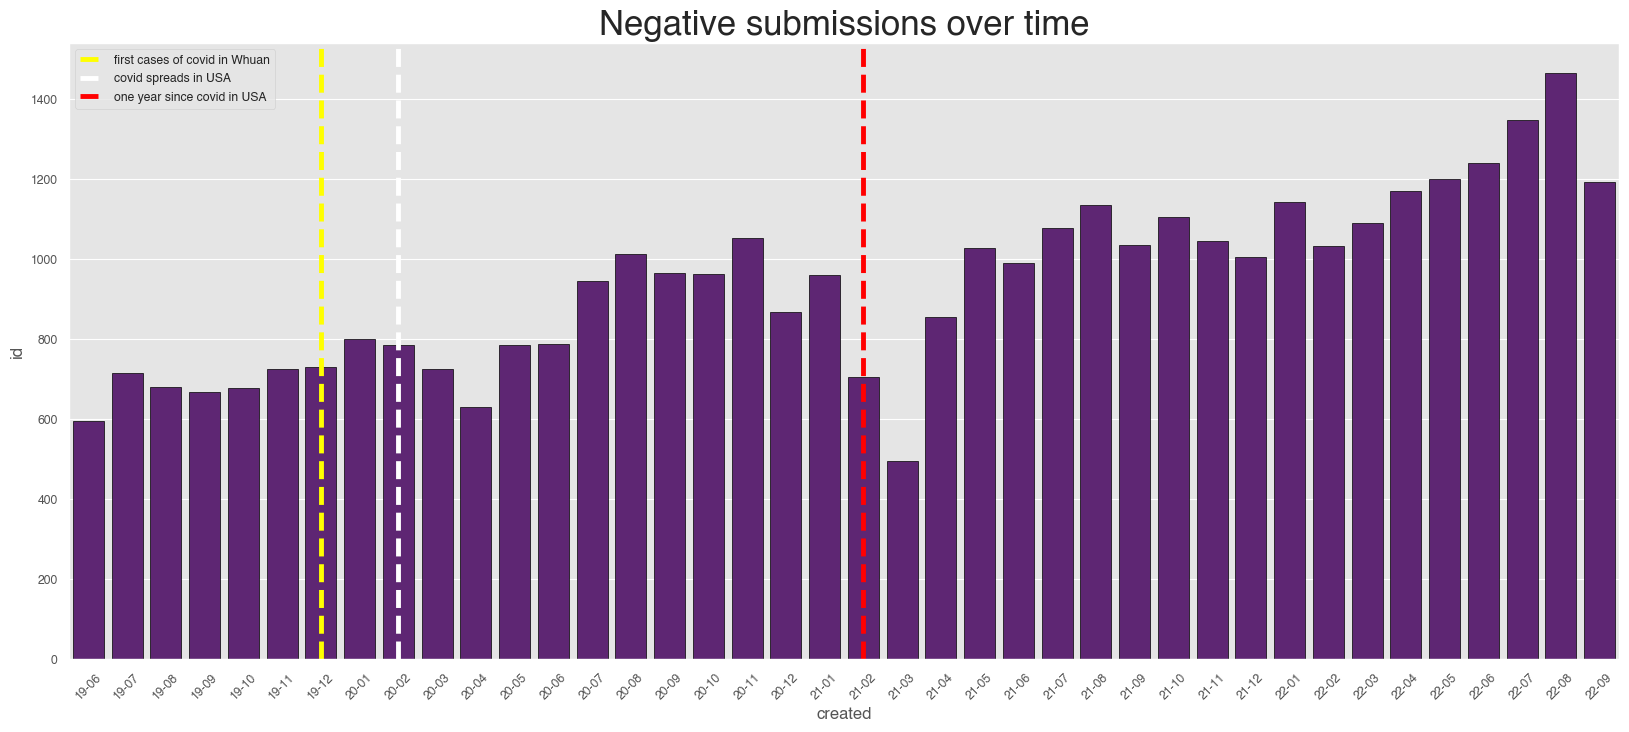

In [35]:
fig, ax = plt.subplots(figsize=(20,8))

plt.title('Negative submissions over time', fontsize=25)
sns.barplot(x='created', y='id', data=df_sub_neg_labels, color=main_color, edgecolor='black')
ax.axvline(x=6, linestyle='--', linewidth=3.5, color='yellow', label='first cases of covid in Whuan')
ax.axvline(x=8, linestyle='--', linewidth=3.5, color='white', label='covid spreads in USA')
ax.axvline(x=20, linestyle='--', linewidth=3.5, color='red', label='one year since covid in USA')
plt.xticks(rotation=45)

plt.legend()
plt.show();

#### Independent T-test on negative submissions label count
Before and **After** Covid

In [36]:
%%capture
summary, results = rp.ttest(group1 = neg_labels_sub_bef_cov.id, group1_name= 'negative sub before covid', 
                            group2 = neg_labels_sub_aft_cov.id, group2_name='negative sub after covid')

In [37]:
display(summary)
display(results)

Variable     N         Mean          SD         SE  \
0  negative sub before covid   9.0   709.444444   62.580171  20.860057   
1   negative sub after covid  31.0  1002.645161  205.389800  36.889097   
2                   combined  40.0   936.675000  220.517851  34.866934   

    95% Conf.     Interval  
0  661.341067   757.547822  
1  927.307574  1077.982748  
2  866.149970  1007.200030

Independent t-test   results
0  Difference (negative sub before covid - negati... -293.2007
1                              Degrees of freedom =    38.0000
2                                               t =    -4.1916
3                           Two side test p value =     0.0002
4                          Difference < 0 p value =     0.0001
5                          Difference > 0 p value =     0.9999
6                                       Cohen's d =    -1.5871
7                                       Hedge's g =    -1.5556
8                                  Glass's delta1 =    -4.6852
9                                Point-Biserial r =    -0.5623

#### Independent T-test on negative submissions label count
Before and **After one year** of Covid

In [38]:
%%capture
summary, results = rp.ttest(group1 = neg_labels_sub_bef_cov.id, group1_name= 'negative sub before covid', 
                            group2 = neg_labels_sub_aft_one_year_cov.id, group2_name='negative sub after covid')

In [39]:
display(summary)
display(results)

Variable     N        Mean          SD         SE  \
0  negative sub before covid   9.0  709.444444   62.580171  20.860057   
1   negative sub after covid  12.0  867.500000  136.696412  39.460855   
2                   combined  21.0  799.761905  135.157650  29.493817   

    95% Conf.    Interval  
0  661.341067  757.547822  
1  780.647243  954.352757  
2  738.238880  861.284930

Independent t-test   results
0  Difference (negative sub before covid - negati... -158.0556
1                              Degrees of freedom =    19.0000
2                                               t =    -3.2102
3                           Two side test p value =     0.0046
4                          Difference < 0 p value =     0.0023
5                          Difference > 0 p value =     0.9977
6                                       Cohen's d =    -1.4156
7                                       Hedge's g =    -1.3589
8                                  Glass's delta1 =    -2.5256
9                                Point-Biserial r =    -0.5930

In [40]:
df_neg_labels_sub = df_submissions[df_submissions['label'] == -1].groupby(['subreddit', 'created']).count().reset_index()

p_values = []
for sr in subreddits:
    a = df_neg_labels_sub[(df_neg_labels_sub['subreddit'] == sr) & (df_neg_labels_sub['created'] <= '20-02')].id
    b = df_neg_labels_sub[(df_neg_labels_sub['subreddit'] == sr) & (df_neg_labels_sub['created'] > '20-02')].id
    p_values.append((stats.ttest_ind(a, b).pvalue, sr, 'full period (Feb 2020 to Sept 2022)'))

for sr in subreddits:
    a = df_neg_labels_sub[(df_neg_labels_sub['subreddit'] == sr) & (df_neg_labels_sub['created'] <= '20-02')].id
    b = df_neg_labels_sub[(df_neg_labels_sub['subreddit'] == sr) & (df_neg_labels_sub['created'] > '20-02') & (df_neg_labels_sub['created'] <= '21-02')].id
    p_values.append((stats.ttest_ind(a, b).pvalue, sr, 'one year (Feb 2020 to Feb 2021)'))

p_values = pd.DataFrame(p_values, columns=['p_value', 'subreddit', 'type'])

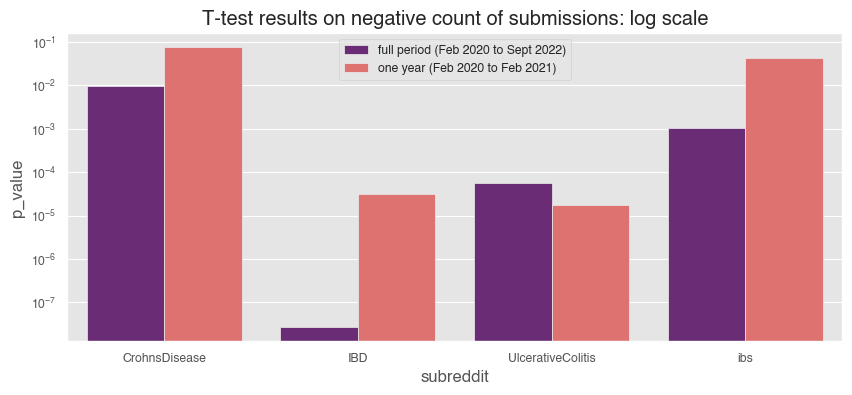

In [41]:
fig, ax = plt.subplots(figsize=(10,4))

plt.title('T-test results on negative count of submissions: log scale')
sns.barplot(data=p_values, hue='type', x=p_values.subreddit, y=p_values.p_value, log=True, palette='magma')

plt.legend()
plt.show();

### Analysis on comments

In [42]:
cmap = matplotlib.cm.get_cmap('mako')
main_color = cmap(0.25)

In [43]:
sentiments_comm = []
compounds_comm = []
for post in tqdm(df_comments.body, desc='Analyzing with vader'):
    scores = sia_vader.polarity_scores(post)
    sentiments_comm.append(sia_vader.polarity_scores(post))
    compounds_comm.append(scores['compound'])
    
    
df_comments['sia_vader'] = sentiments_comm
df_comments['compound'] = compounds_comm

Analyzing with vader:   0%|          | 0/480165 [00:00<?, ?it/s]

In [44]:
df_comments['label'] = df_comments['compound'].apply(lambda x: is_positive(x))

In [45]:
comm_rates = []
for sr in subreddits:
    dd = df_comments[df_comments['subreddit'] == sr]
    dd_pos = dd[dd['label'] == 1]
    dd_neg = dd[dd['label'] == -1]
    dd_neu = dd[dd['label'] == 0]
    pos_rate = dd_pos.shape[0] / df_comments[df_comments['subreddit'] == sr].shape[0]
    neg_rate = dd_neg.shape[0] / df_comments[df_comments['subreddit'] == sr].shape[0]
    neu_rate = dd_neu.shape[0] / df_comments[df_comments['subreddit'] == sr].shape[0]
    
    comm_rates.append((pos_rate, sr, 1))
    comm_rates.append((neg_rate, sr, -1))
    comm_rates.append((neu_rate, sr, 0))
    
comm_rates = pd.DataFrame(comm_rates, columns=['rate', 'subreddit', 'label'])

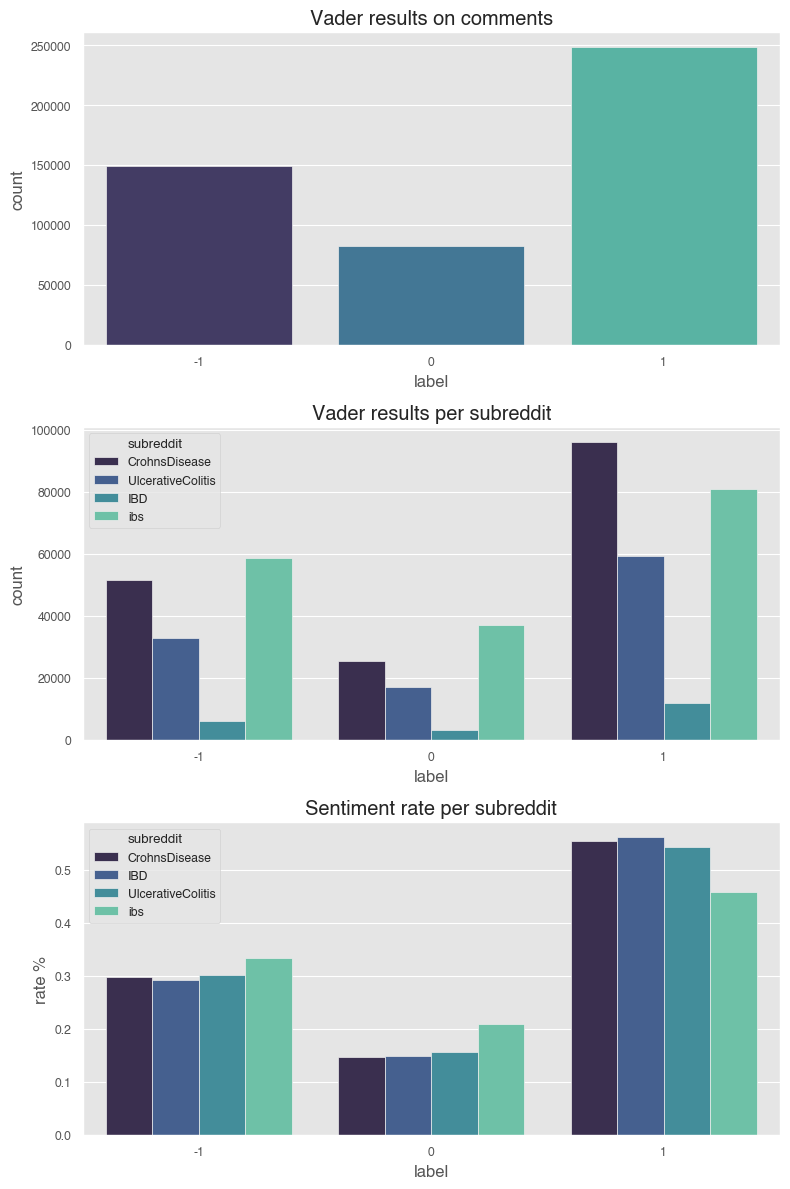

In [46]:
fig, [ax1, ax2, ax3] = plt.subplots(figsize=(8,12), ncols=1, nrows=3)

sns.countplot(data=df_comments, x='label', ax=ax1, palette='mako')
ax1.set_title('Vader results on comments')

sns.countplot(data=df_comments, x='label', hue='subreddit', ax=ax2, palette='mako')
ax2.set_title('Vader results per subreddit')

sns.barplot(data=comm_rates, x='label', y='rate', hue='subreddit', palette='mako', ax=ax3)
plt.title('Sentiment rate per subreddit')
ax3.set_ylabel('rate %')

plt.tight_layout()
plt.show();

In [47]:
df_comments.created = df_comments.created.apply(lambda x: x.strftime('%y-%m'))
df_comments.sort_values('created', inplace=True)

In [48]:
comm_compound_by_month = df_comments.groupby('created').sum('compound').compound.values
comm_number_of_posts_over_time = df_comments.groupby('created').count().compound.values
comm_avg_sentiments = []
for i in range(0, len(comm_compound_by_month)):
    comm_avg_sentiments.append(comm_compound_by_month[i] / comm_number_of_posts_over_time[i])

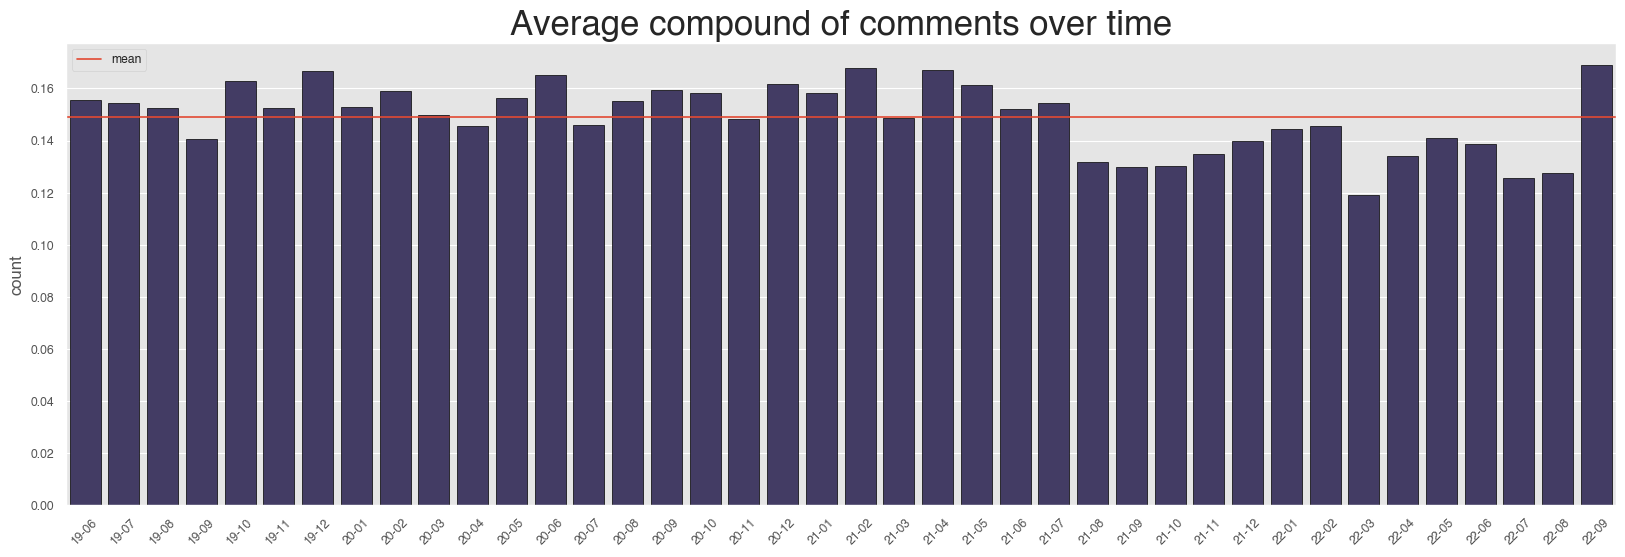

In [49]:
fig, ax = plt.subplots(figsize=(20,6))

plt.title('Average compound of comments over time', fontsize=25)
sns.barplot(x=df_comments.created.unique(), y=comm_avg_sentiments, color=main_color, edgecolor='black')
plt.ylabel('count')
plt.xlabel('')
plt.xticks(rotation=45)
plt.axhline(mean(comm_avg_sentiments), label='mean')

plt.legend()
plt.show();

In [50]:
df_comm_crohn = df_comments[df_comments['subreddit'] == 'CrohnsDisease']
df_comm_ibd = df_comments[df_comments['subreddit'] == 'IBD']
df_comm_ibs = df_comments[df_comments['subreddit'] == 'ibs']
df_comm_ulc = df_comments[df_comments['subreddit'] == 'UlcerativeColitis']

comm_crohn_by_month = df_comm_crohn.groupby('created').sum('compound').compound.values
comm_crohn_posts_ov_time = df_comm_crohn.groupby('created').count().compound.values
comm_crohn_avg_comp = []
for i in range(0, len(comm_crohn_by_month)):
    comm_crohn_avg_comp.append(comm_crohn_by_month[i] / comm_crohn_posts_ov_time[i])
    
comm_ibd_by_month = df_comm_ibd.groupby('created').sum('compound').compound.values
comm_ibd_posts_ov_time = df_comm_ibd.groupby('created').count().compound.values
comm_ibd_avg_comp = []
for i in range(0, len(comm_ibd_by_month)):
    comm_ibd_avg_comp.append(comm_ibd_by_month[i] / comm_ibd_posts_ov_time[i])
    
comm_ibs_by_month = df_comm_ibs.groupby('created').sum('compound').compound.values
comm_ibs_posts_ov_time = df_comm_ibs.groupby('created').count().compound.values
comm_ibs_avg_comp = []
for i in range(0, len(comm_ibs_by_month)):
    comm_ibs_avg_comp.append(comm_ibs_by_month[i] / comm_ibs_posts_ov_time[i])
    
comm_ulc_by_month = df_comm_ulc.groupby('created').sum('compound').compound.values
comm_ulc_posts_ov_time = df_comm_ulc.groupby('created').count().compound.values
comm_ulc_avg_comp = []
for i in range(0, len(comm_ulc_by_month)):
    comm_ulc_avg_comp.append(comm_ulc_by_month[i] / comm_ulc_posts_ov_time[i])
    
df_comm_avg_compounds = pd.DataFrame({
    'month': df_comments.created.unique(),
    'crohn': comm_crohn_avg_comp,
    'ibd': comm_ibd_avg_comp,
    'ibs': comm_ibs_avg_comp,
    'ulc': comm_ulc_avg_comp
})

df_comm_avg_compounds.set_index('month');

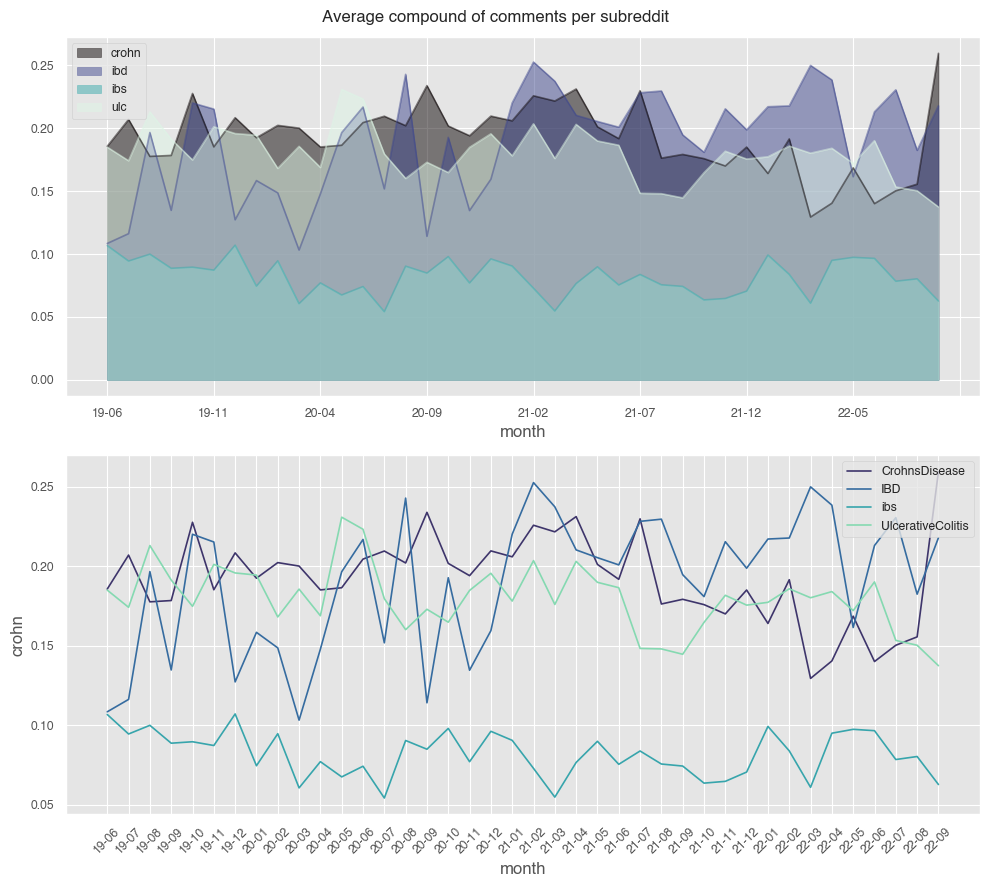

In [51]:
fig, [ax1, ax2] = plt.subplots(figsize=(10,9), nrows=2)

plt.suptitle('Average compound of comments per subreddit')
df_comm_avg_compounds.plot(x='month', kind='area', stacked=False, ax=ax1, colormap='mako')

sns.lineplot(x=df_comm_avg_compounds.month, y=df_comm_avg_compounds.crohn, ax=ax2, label='CrohnsDisease', color=cmap(0.25))
sns.lineplot(x=df_comm_avg_compounds.month, y=df_comm_avg_compounds.ibd, ax=ax2, label='IBD', color=cmap(0.45))
sns.lineplot(x=df_comm_avg_compounds.month, y=df_comm_avg_compounds.ibs, ax=ax2, label='ibs', color=cmap(0.65))
sns.lineplot(x=df_comm_avg_compounds.month, y=df_comm_avg_compounds.ulc, ax=ax2, label='UlcerativeColitis', color=cmap(0.85))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show();

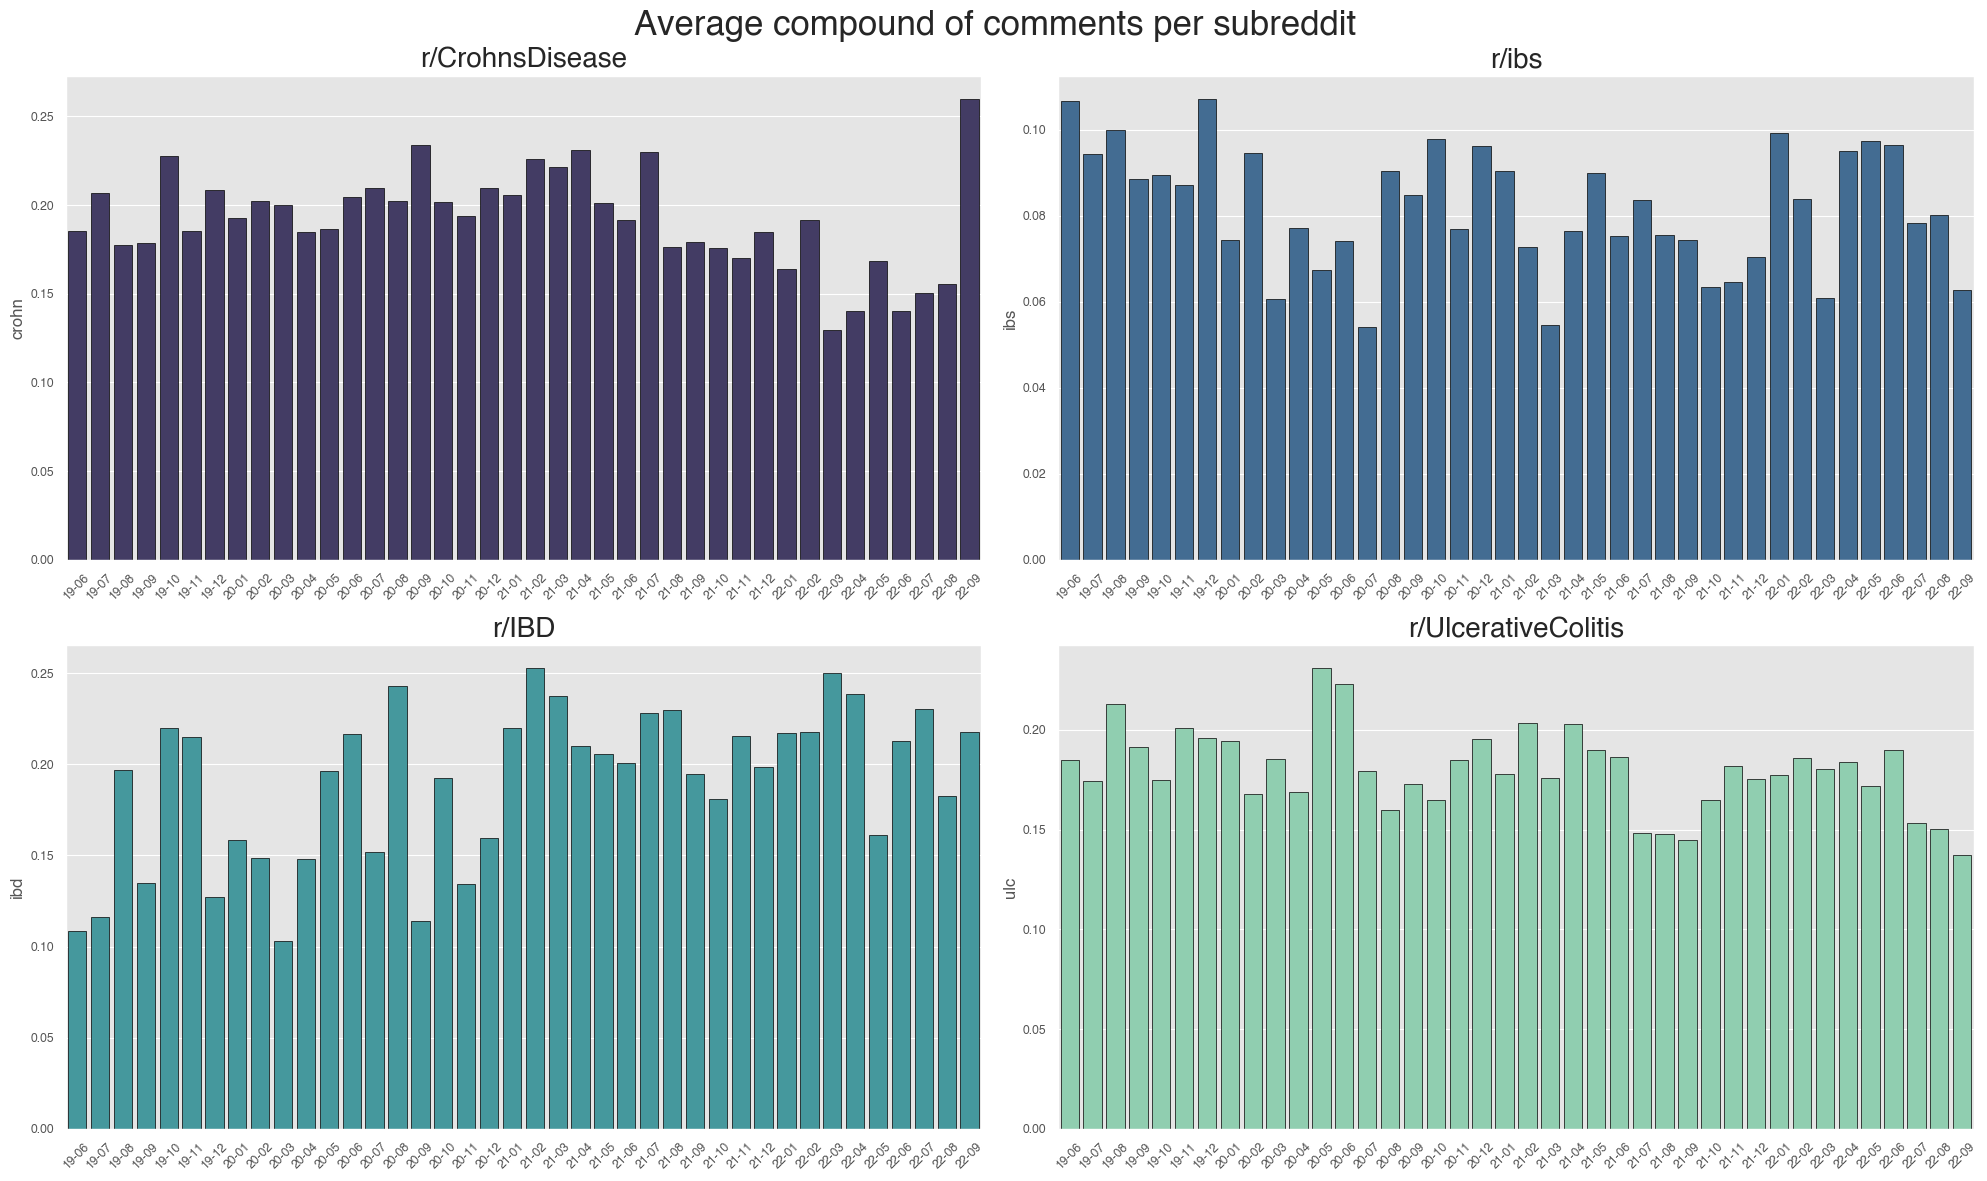

In [52]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20,12), ncols=2, nrows=2)

plt.suptitle('Average compound of comments per subreddit', fontsize=25)

sns.barplot(x=df_comments.created.unique(), y=df_comm_avg_compounds.crohn, color=cmap(0.25), edgecolor='Black', ax=ax1)
ax1.set_title('r/CrohnsDisease', fontsize=20)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

sns.barplot(x=df_comments.created.unique(), y=df_comm_avg_compounds.ibs, color=cmap(0.45), edgecolor='Black', ax=ax2)
ax2.set_title('r/ibs', fontsize=20)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

sns.barplot(x=df_comments.created.unique(), y=df_comm_avg_compounds.ibd, color=cmap(0.65), edgecolor='Black', ax=ax3)
ax3.set_title('r/IBD', fontsize=20)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

sns.barplot(x=df_comments.created.unique(), y=df_comm_avg_compounds.ulc, color=cmap(0.85), edgecolor='Black', ax=ax4)
ax4.set_title('r/UlcerativeColitis', fontsize=20)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show();

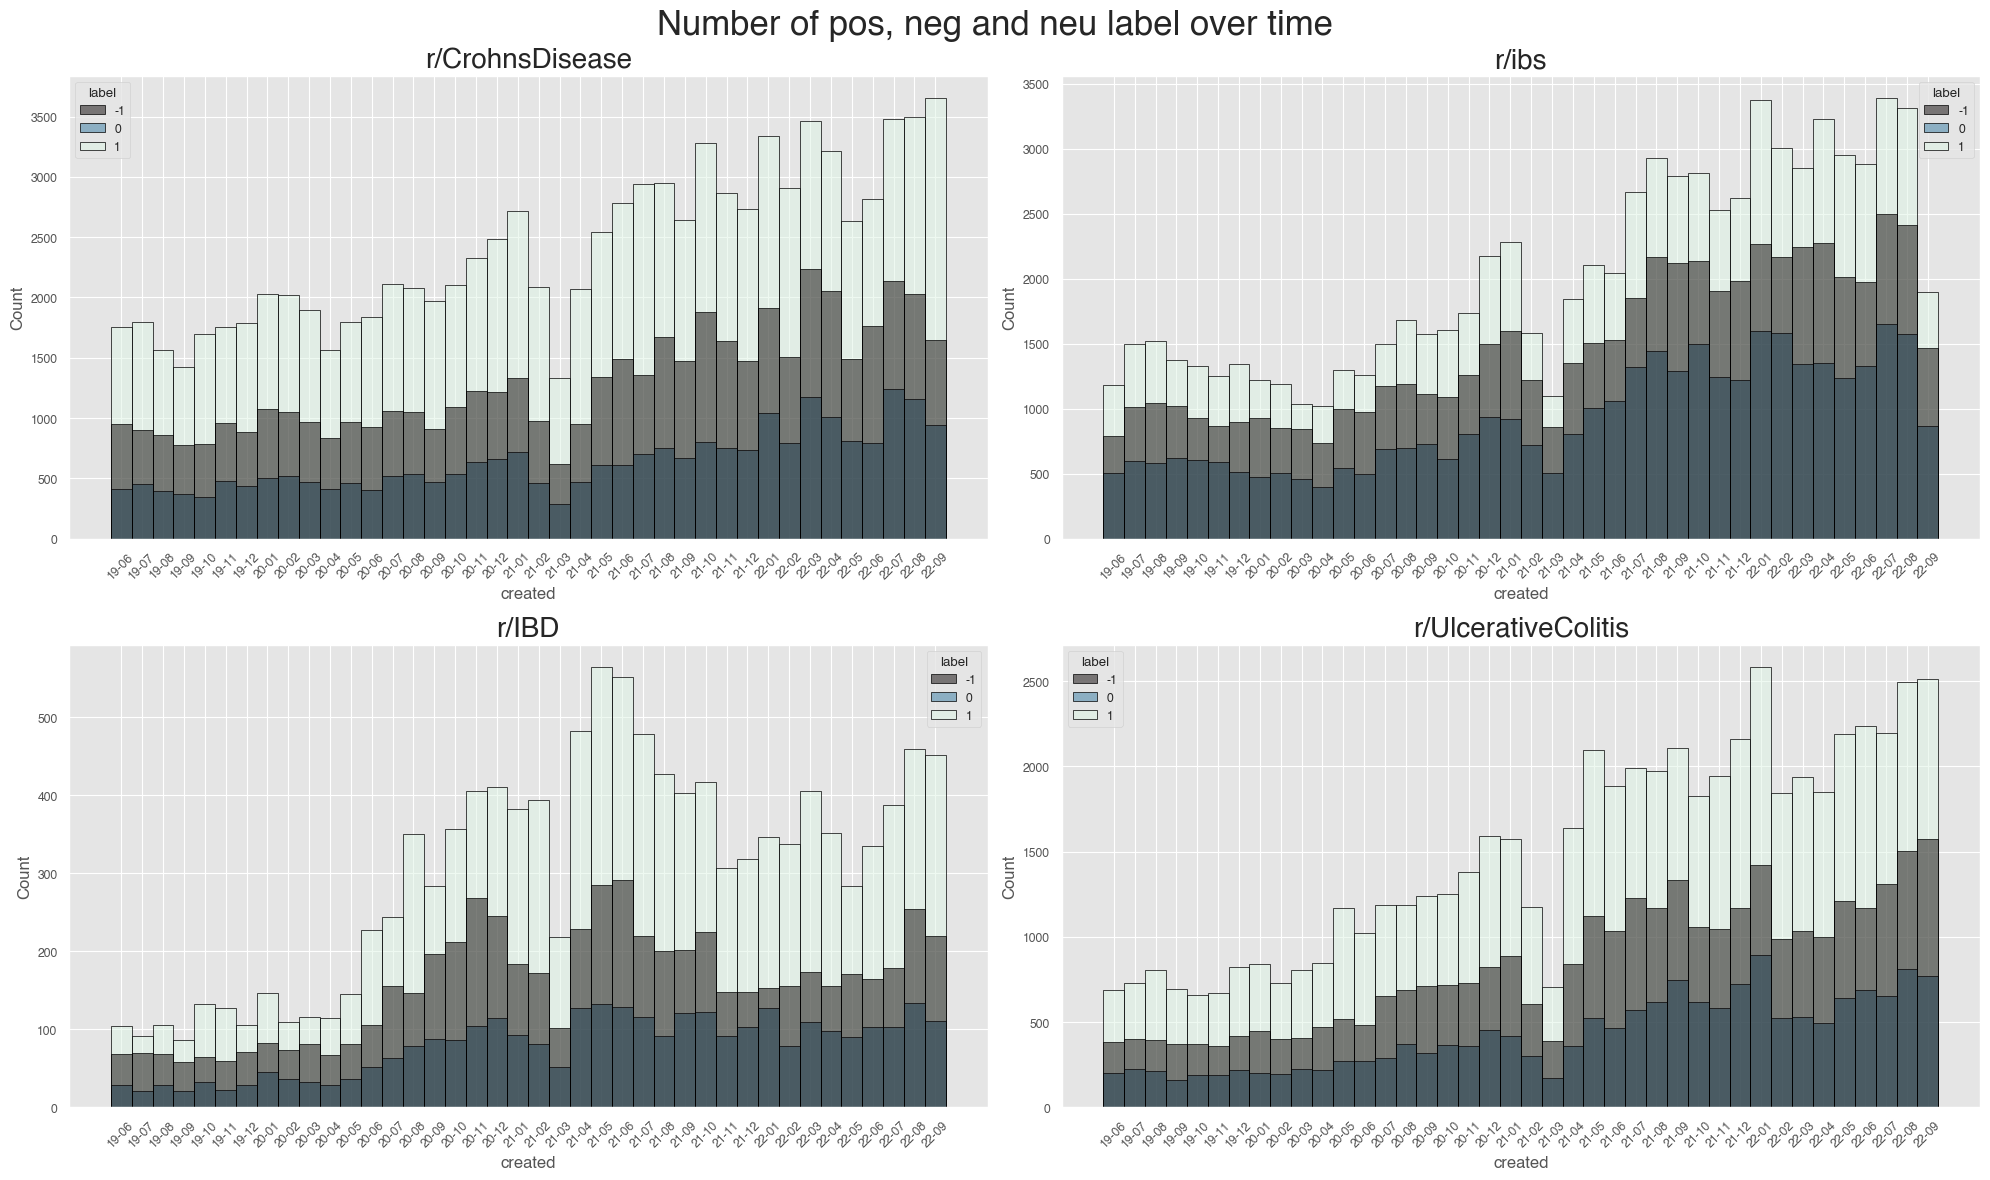

In [53]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20,12), ncols=2, nrows=2)

plt.suptitle('Number of pos, neg and neu label over time', fontsize=25)

sns.histplot(data=df_comments[df_comments['subreddit'] == 'CrohnsDisease'], edgecolor='Black',
              hue='label', x='created', palette='mako', ax=ax1, color=cmap(0.25))
ax1.set_title('r/CrohnsDisease', fontsize=20)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

sns.histplot(data=df_comments[df_comments['subreddit'] == 'ibs'], edgecolor='Black',
              hue='label', x='created', palette='mako', ax=ax2, color=cmap(0.45))
ax2.set_title('r/ibs', fontsize=20)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

sns.histplot(data=df_comments[df_comments['subreddit'] == 'IBD'], edgecolor='Black',
              hue='label', x='created', palette='mako', ax=ax3, color=cmap(0.65))
ax3.set_title('r/IBD', fontsize=20)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

sns.histplot(data=df_comments[df_comments['subreddit'] == 'UlcerativeColitis'], edgecolor='Black',
              hue='label', x='created', palette='mako', ax=ax4, color=cmap(0.85))
ax4.set_title('r/UlcerativeColitis', fontsize=20)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show();

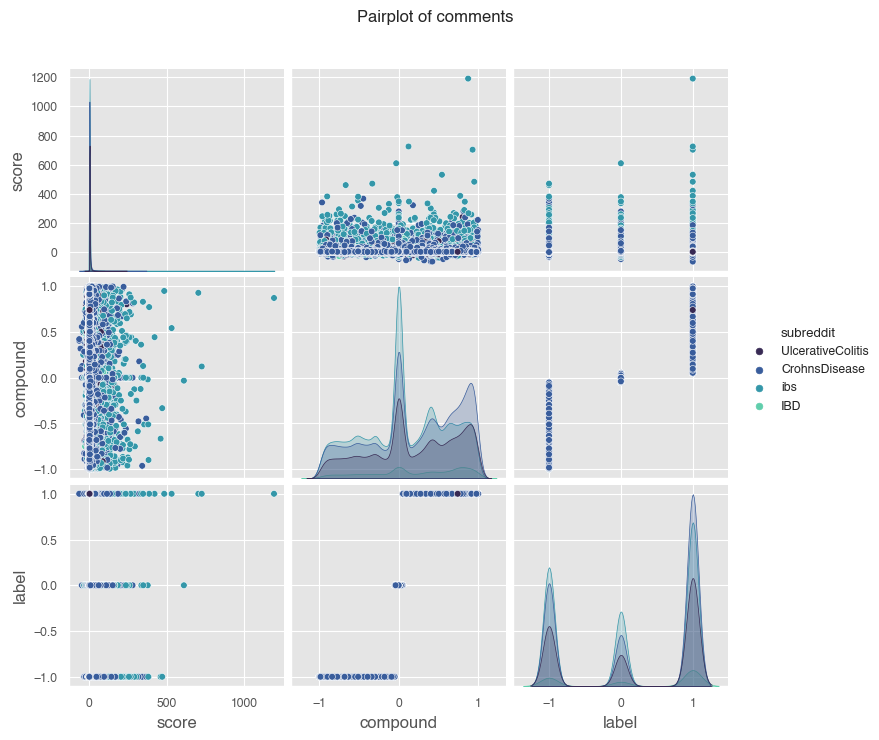

In [54]:
g = sns.pairplot(df_comments, hue='subreddit', palette='mako')

g.figure.subplots_adjust(top=0.9);
g.figure.suptitle(
    'Pairplot of comments',
    fontsize=12
);

#### Relationship between the sentiment in a subtree and the number of comments

In [55]:
def remove_t3(text):
    text = str(text)
    return text[3:]

a = df_comments.groupby('parent_id').sum('compound').reset_index()
b = df_submissions[['id','num_comments']]

a['parent_id'] = a.parent_id.apply(lambda x: remove_t3(x))

a = a[a['parent_id'].isin(df_submissions.id.unique())]
b = b[b['id'].isin(df_submissions.id.unique())]
a.rename(columns={'parent_id': 'id'}, inplace=True)

a = a.merge(b, on='id')

a['avg_comp'] = a['compound'] / a['num_comments']

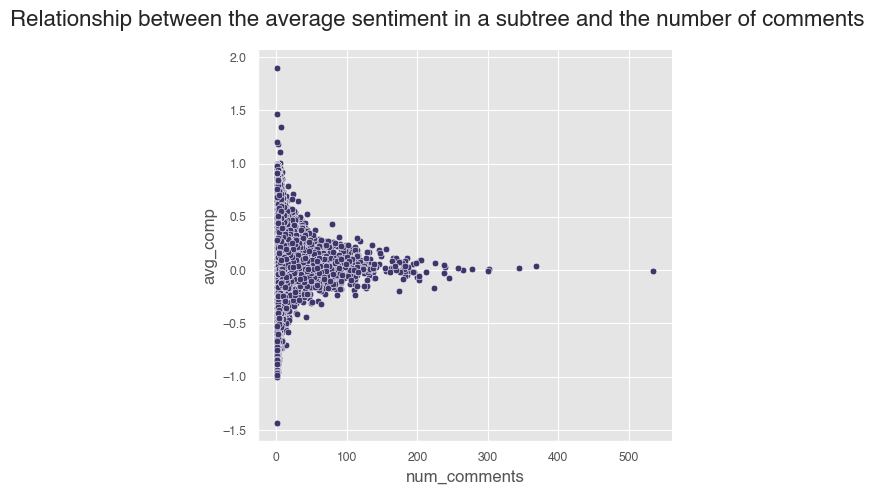

In [56]:
g = sns.relplot(data=a, y='avg_comp', x='num_comments', color=main_color)

g.figure.subplots_adjust(top=0.9);
g.figure.suptitle(
    'Relationship between the average sentiment in a subtree and the number of comments',
    fontsize=16
);

plt.show()

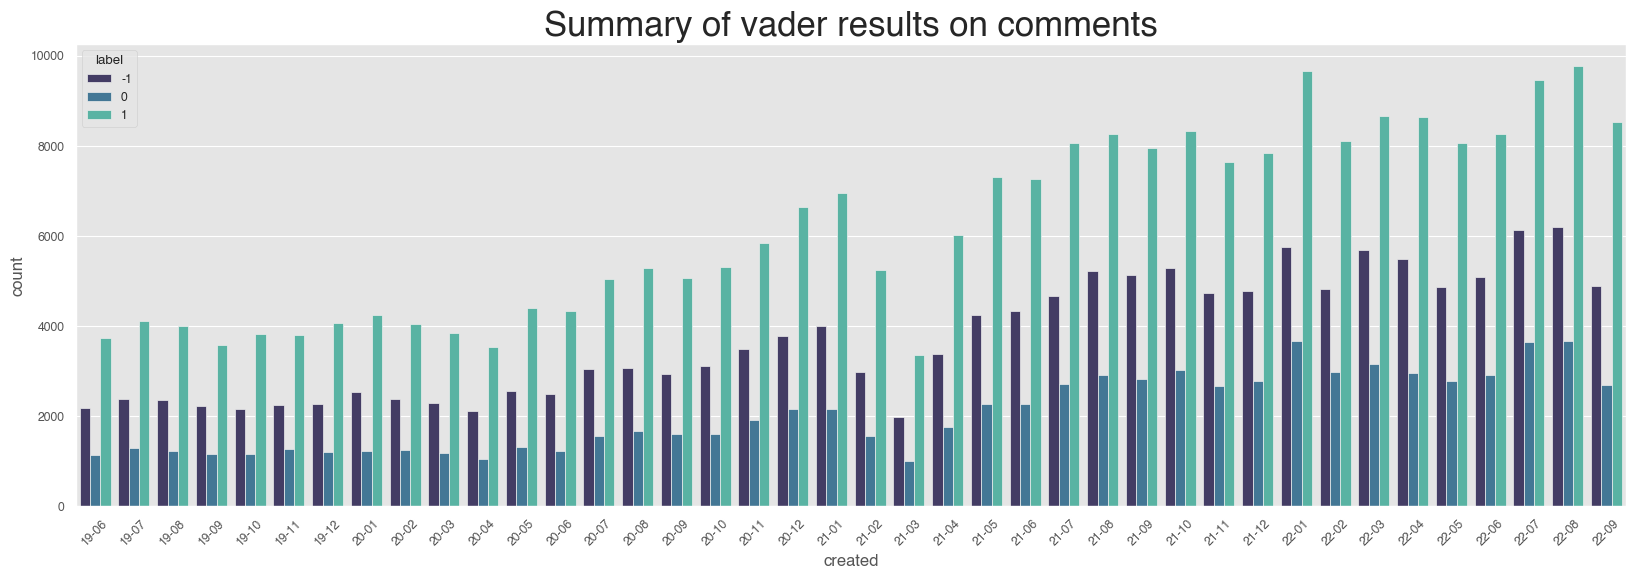

In [57]:
fig, ax = plt.subplots(figsize=(20,6))

sns.countplot(x='created', hue='label', data=df_comments, palette='mako')
plt.title('Summary of vader results on comments', fontsize=25)
plt.xticks(rotation=45)
plt.show();

### T-test on comments

### Compound analysis

In [58]:
df_c_c = df_comments.groupby('created').mean('compound').reset_index().copy()
df_c_c.drop(columns=['score', 'label'], inplace=True)
df_c_c.columns = ['month', 'avg_compound']

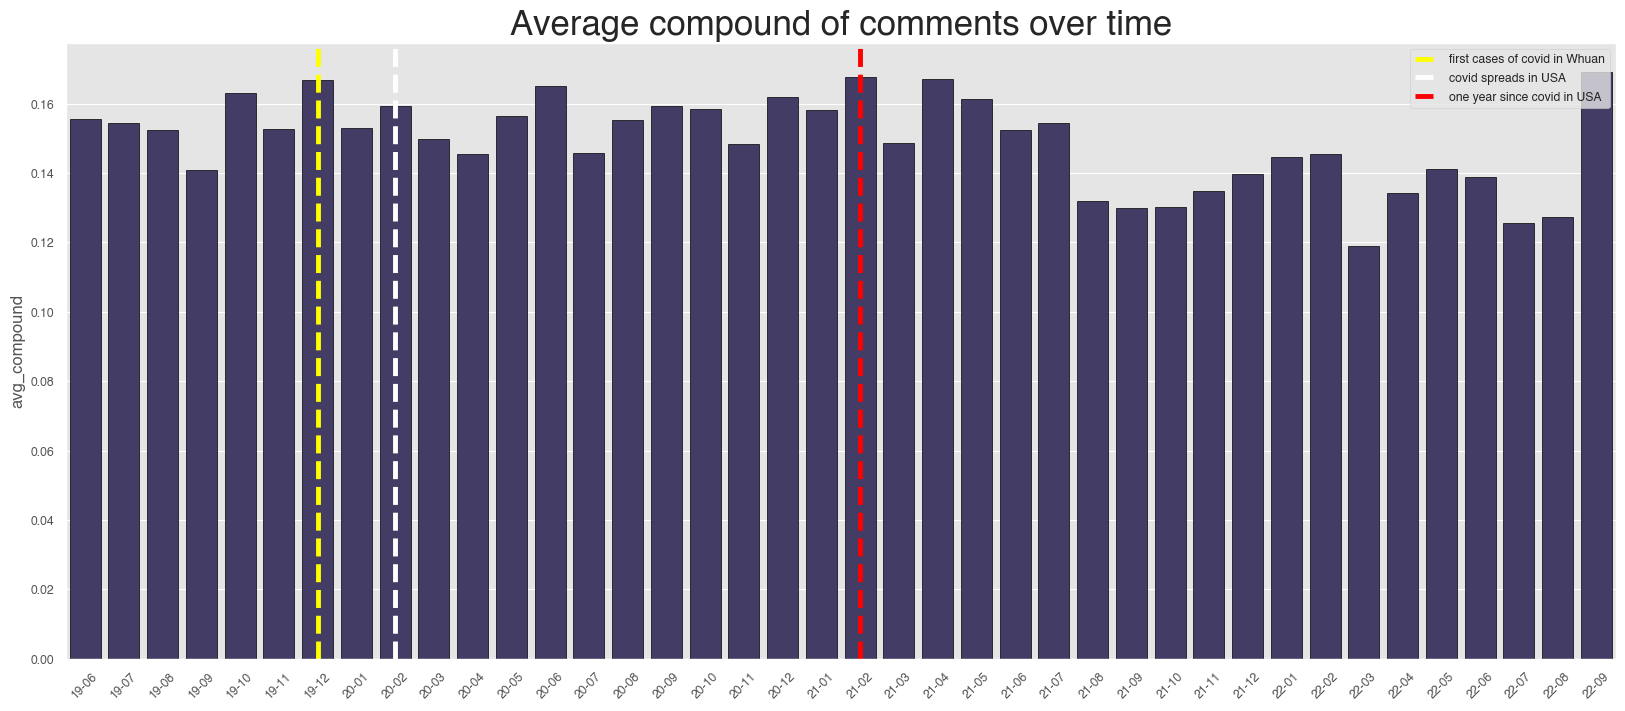

In [59]:
fig, ax = plt.subplots(figsize=(20,8))

plt.title('Average compound of comments over time', fontsize=25)
sns.barplot(x=df_c_c.month.unique(), y=df_c_c.avg_compound, color=main_color, edgecolor='black')
ax.axvline(x=6, linestyle='--', linewidth=3.5, color='yellow', label='first cases of covid in Whuan')
ax.axvline(x=8, linestyle='--', linewidth=3.5, color='white', label='covid spreads in USA')
ax.axvline(x=20, linestyle='--', linewidth=3.5, color='red', label='one year since covid in USA')
plt.xticks(rotation=45)

plt.legend()
plt.show();

In [60]:
avg_comm_comp_bef_covid = df_c_c[(df_c_c['month'] <= '20-02')].avg_compound
avg_comm_comp_aft_covid = df_c_c[(df_c_c['month'] > '20-02')].avg_compound
avg_comm_comp_aft_one_year_covid = df_c_c[(df_c['month'] > '20-02') & (df_c_c['month'] <= '21-02')].avg_compound

#### Independent T-test on submission compound

Before and **After** Covid

In [61]:
%%capture
summary, results = rp.ttest(group1 = avg_comm_comp_bef_covid, group1_name= 'comments compound before covid', 
                            group2 = avg_comm_comp_aft_covid, group2_name='comments compound after covid')

In [62]:
display(summary)
display(results)

Variable     N      Mean        SD        SE  \
0  comments compound before covid   9.0  0.155298  0.007402  0.002467   
1   comments compound after covid  31.0  0.147328  0.013706  0.002462   
2                        combined  40.0  0.149121  0.012926  0.002044   

   95% Conf.  Interval  
0   0.149608  0.160987  
1   0.142301  0.152355  
2   0.144987  0.153255

Independent t-test  results
0  Difference (comments compound before covid - c...   0.0080
1                              Degrees of freedom =   38.0000
2                                               t =    1.6648
3                           Two side test p value =    0.1042
4                          Difference < 0 p value =    0.9479
5                          Difference > 0 p value =    0.0521
6                                       Cohen's d =    0.6304
7                                       Hedge's g =    0.6178
8                                  Glass's delta1 =    1.0767
9                                Point-Biserial r =    0.2607

#### Independent T-test on submission compound

Before and **After one year** Covid

In [63]:
%%capture
summary, results = rp.ttest(group1 = avg_comm_comp_bef_covid, group1_name= 'comments comp before covid', 
                            group2 = avg_comm_comp_aft_one_year_covid, group2_name='comments comp after one year of covid')

In [64]:
display(summary)
display(results)

Variable     N      Mean        SD        SE  \
0             comments comp before covid   9.0  0.155298  0.007402  0.002467   
1  comments comp after one year of covid  12.0  0.155991  0.007317  0.002112   
2                               combined  21.0  0.155694  0.007175  0.001566   

   95% Conf.  Interval  
0   0.149608  0.160987  
1   0.151342  0.160640  
2   0.152428  0.158960

Independent t-test  results
0  Difference (comments comp before covid - comme...  -0.0007
1                              Degrees of freedom =   19.0000
2                                               t =   -0.2138
3                           Two side test p value =    0.8330
4                          Difference < 0 p value =    0.4165
5                          Difference > 0 p value =    0.5835
6                                       Cohen's d =   -0.0943
7                                       Hedge's g =   -0.0905
8                                  Glass's delta1 =   -0.0937
9                                Point-Biserial r =   -0.0490

In [65]:
df_mean_compounds_comm = df_comments.groupby(['subreddit', 'created']).mean('compound').reset_index()

p_values = []
for sr in subreddits:
    a = df_mean_compounds_comm[(df_mean_compounds_comm['subreddit'] == sr) & (df_mean_compounds_comm['created'] <= '20-02')].compound
    b = df_mean_compounds_comm[(df_mean_compounds_comm['subreddit'] == sr) & (df_mean_compounds_comm['created'] > '20-02')].compound
    p_values.append((stats.ttest_ind(a, b).pvalue, sr, 'full period (Feb 2020 to Sept 2022)'))

for sr in subreddits:
    a = df_mean_compounds_comm[(df_mean_compounds_comm['subreddit'] == sr) & (df_mean_compounds_comm['created'] <= '20-02')].compound
    b = df_mean_compounds_comm[(df_mean_compounds_comm['subreddit'] == sr) & (df_mean_compounds_comm['created'] > '20-02') & (df_mean_compounds_comm['created'] <= '21-02')].compound
    p_values.append((stats.ttest_ind(a, b).pvalue, sr, 'one year (Feb 2020 to Feb 2021)'))

p_values = pd.DataFrame(p_values, columns=['p_value', 'subreddit', 'type'])

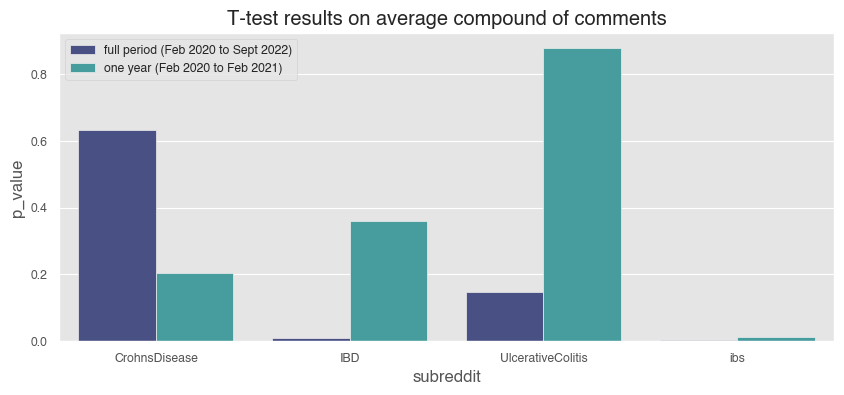

In [66]:
fig, ax = plt.subplots(figsize=(10,4))

plt.title('T-test results on average compound of comments')
sns.barplot(data=p_values, hue='type', x=p_values.subreddit, y=p_values.p_value, palette='mako')

plt.legend()
plt.show();

### Label analysis

In [67]:
df_comm_neg_labels = df_comments[df_comments['label'] == -1].groupby('created').count().reset_index()
df_comm_neg_labels = df_comm_neg_labels[['id', 'created']]

neg_labels_comm_bef_cov = df_comm_neg_labels[df_comm_neg_labels['created'] <= '20-02']
neg_labels_comm_aft_cov = df_comm_neg_labels[df_comm_neg_labels['created'] > '20-02']
neg_labels_comm_aft_one_year_cov = df_comm_neg_labels[(df_comm_neg_labels['created'] > '20-02') & (df_comm_neg_labels['created'] <= '21-02')]

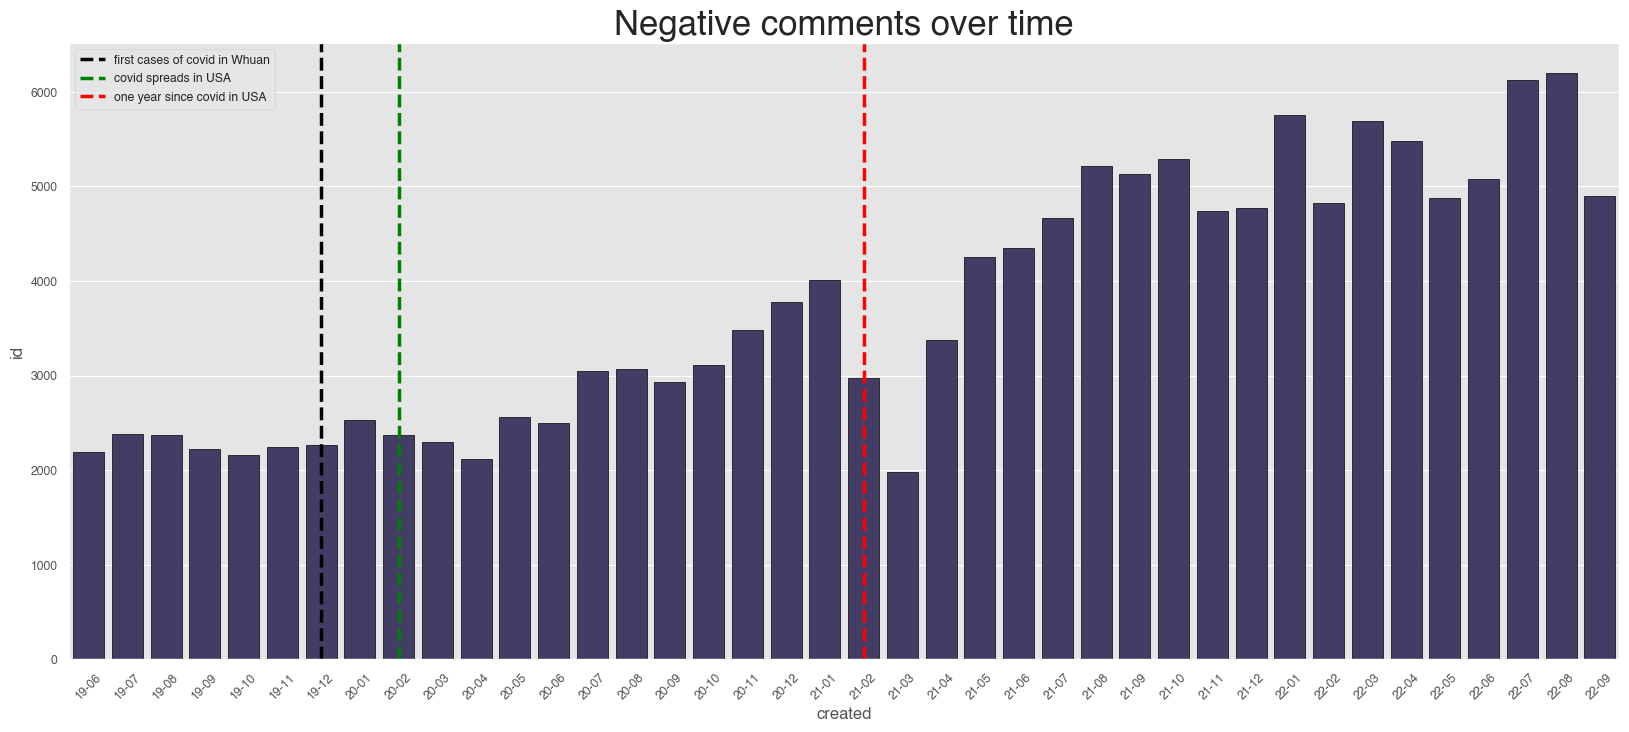

In [68]:
fig, ax = plt.subplots(figsize=(20,8))

plt.title('Negative comments over time', fontsize=25)
sns.barplot(x='created', y='id', data=df_comm_neg_labels, color=main_color, edgecolor='black')
ax.axvline(x=6, linestyle='--', linewidth=2.5, color='black', label='first cases of covid in Whuan')
ax.axvline(x=8, linestyle='--', linewidth=2.5, color='green', label='covid spreads in USA')
ax.axvline(x=20, linestyle='--', linewidth=2.5, color='red', label='one year since covid in USA')
plt.xticks(rotation=45)

plt.legend()
plt.show();

#### Independent T-test on negative submissions label count
Before and **After** Covid

In [69]:
%%capture
summary, results = rp.ttest(group1 = neg_labels_comm_bef_cov.id, group1_name= 'negative comm before covid', 
                            group2 = neg_labels_comm_aft_cov.id, group2_name='negative comm after covid')

In [70]:
display(summary)
display(results)

Variable     N         Mean           SD          SE  \
0  negative comm before covid   9.0  2304.222222   118.940928   39.646976   
1   negative comm after covid  31.0  4146.806452  1248.500979  224.237395   
2                    combined  40.0  3732.225000  1345.045562  212.670377   

     95% Conf.     Interval  
0  2212.796131  2395.648313  
1  3688.852595  4604.760308  
2  3302.058562  4162.391438

Independent t-test    results
0  Difference (negative comm before covid - negat... -1842.5842
1                              Degrees of freedom =     38.0000
2                                               t =     -4.3814
3                           Two side test p value =      0.0001
4                          Difference < 0 p value =      0.0000
5                          Difference > 0 p value =      1.0000
6                                       Cohen's d =     -1.6590
7                                       Hedge's g =     -1.6260
8                                  Glass's delta1 =    -15.4916
9                                Point-Biserial r =     -0.5793

#### Independent T-test on negative submissions label count
Before and **After one year** of Covid

In [71]:
%%capture
summary, results = rp.ttest(group1 = neg_labels_comm_bef_cov.id, group1_name= 'negative sub before covid', 
                            group2 = neg_labels_comm_aft_one_year_cov.id, group2_name='negative sub after covid')

In [72]:
display(summary)
display(results)

Variable     N         Mean          SD          SE  \
0  negative sub before covid   9.0  2304.222222  118.940928   39.646976   
1   negative sub after covid  12.0  2988.916667  572.033924  165.131970   
2                   combined  21.0  2695.476190  553.336753  120.747979   

     95% Conf.     Interval  
0  2212.796131  2395.648313  
1  2625.463651  3352.369682  
2  2443.600320  2947.352061

Independent t-test   results
0  Difference (negative sub before covid - negati... -684.6944
1                              Degrees of freedom =    19.0000
2                                               t =    -3.5127
3                           Two side test p value =     0.0023
4                          Difference < 0 p value =     0.0012
5                          Difference > 0 p value =     0.9988
6                                       Cohen's d =    -1.5489
7                                       Hedge's g =    -1.4870
8                                  Glass's delta1 =    -5.7566
9                                Point-Biserial r =    -0.6275

In [73]:
df_neg_labels_comm = df_comments[df_comments['label'] == -1].groupby(['subreddit', 'created']).count().reset_index()

p_values = []
for sr in subreddits:
    a = df_neg_labels_comm[(df_neg_labels_comm['subreddit'] == sr) & (df_neg_labels_comm['created'] <= '20-02')].id
    b = df_neg_labels_comm[(df_neg_labels_comm['subreddit'] == sr) & (df_neg_labels_comm['created'] > '20-02')].id
    p_values.append((stats.ttest_ind(a, b).pvalue, sr, 'full period (Feb 2020 to Sept 2022)'))

for sr in subreddits:
    a = df_neg_labels_comm[(df_neg_labels_comm['subreddit'] == sr) & (df_neg_labels_comm['created'] <= '20-02')].id
    b = df_neg_labels_comm[(df_neg_labels_comm['subreddit'] == sr) & (df_neg_labels_comm['created'] > '20-02') & (df_neg_labels_comm['created'] <= '21-02')].id
    p_values.append((stats.ttest_ind(a, b).pvalue, sr, 'one year (Feb 2020 to Feb 2021)'))

p_values = pd.DataFrame(p_values, columns=['p_value', 'subreddit', 'type'])

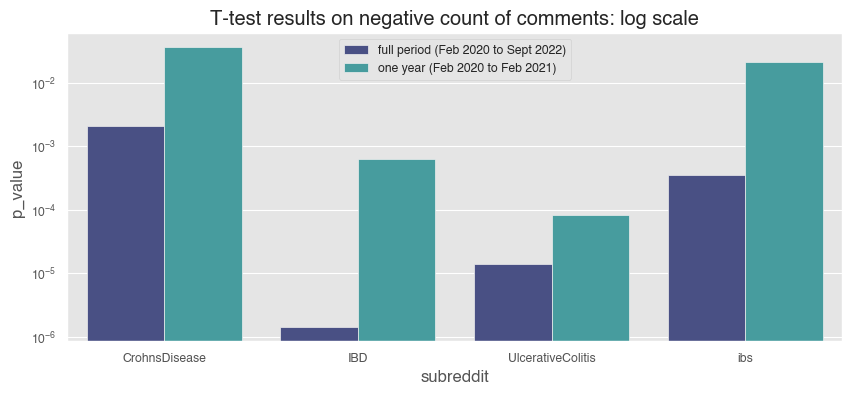

In [74]:
fig, ax = plt.subplots(figsize=(10,4))

plt.title('T-test results on negative count of comments: log scale')
sns.barplot(data=p_values, hue='type', x=p_values.subreddit, y=p_values.p_value, log=True, palette='mako')

plt.legend()
plt.show();

## Covid related analysis

In [75]:
covid_keywords = [
    "Pandemic",
    "pandemic",
    "coronavirus" ,
    "CORONAVIRUS",
    "Coronavirus",
    "COVID-19",
    "COVID19",
    "COVID",
    "COVID 19",
    "covid-19",
    "covid19",
    "covid",
    "covid 19",
    "Covid-19",
    "Covid19",
    "Covid",
    "Covid 19",
    "Vaccine",
    "vaccine"
    "SARS-COV-2",
    "SARS COV-2",
    "SARS-COV2",
    "SARS-COV 2",
    "SARS COV"
]

disease_keywords = [
    'crohn',
    'ibd',
    'ibs',
    'ulcerative',
    'colitis',
]

patterns = []
for k in covid_keywords:
    for dk in disease_keywords:
        s1 = f'{dk}.*{k}'
        s2 = f'{k}.*{dk}'
        patterns.append(s1)
        patterns.append(s2)

### Analysis on covid related submissions

In [76]:
cmap = matplotlib.cm.get_cmap('viridis')
main_color = cmap(0.6)

In [77]:
regxpr = '|'.join([f'{p}' for p in patterns])

simple_pattern = '|'.join([f'{p}' for p in covid_keywords])

In [78]:
df_sub_filtered = df_submissions[df_submissions.title_and_body.str.contains(simple_pattern)].copy()

In [79]:
sub_filt_compound_by_month = df_sub_filtered.groupby('created').sum('compound').compound.values
sub_filt_number_of_posts_over_time = df_sub_filtered.groupby('created').count().compound.values
sub_filt_avg_sentiments = []
for i in range(0, len(sub_filt_compound_by_month)):
    sub_filt_avg_sentiments.append(sub_filt_compound_by_month[i] / sub_filt_number_of_posts_over_time[i])

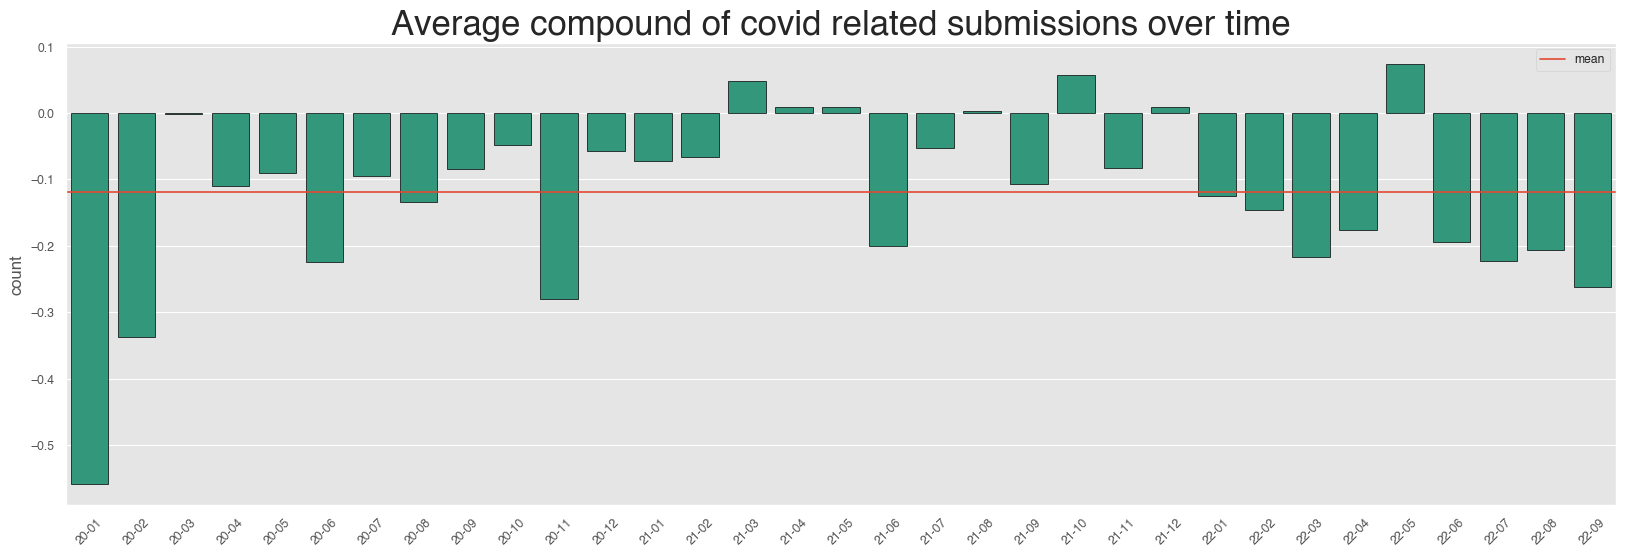

In [80]:
fig, ax = plt.subplots(figsize=(20,6))

plt.title('Average compound of covid related submissions over time', fontsize=25)
sns.barplot(x=df_sub_filtered.created.unique(), y=sub_filt_avg_sentiments, color=main_color, edgecolor='black')
plt.ylabel('count')
plt.xlabel('')
plt.xticks(rotation=45)
plt.axhline(mean(sub_filt_avg_sentiments), label='mean')

plt.legend()
plt.show();

In [81]:
sub_cov_rates = []
for sr in subreddits:
    dd = df_submissions[df_submissions['subreddit'] == sr]
    dd_pos = dd[dd['label'] == 1]
    dd_neg = dd[dd['label'] == -1]
    dd_neu = dd[dd['label'] == 0]
    pos_rate = dd_pos.shape[0] / df_sub_filtered[df_sub_filtered['subreddit'] == sr].shape[0]
    neg_rate = dd_neg.shape[0] / df_sub_filtered[df_sub_filtered['subreddit'] == sr].shape[0]
    neu_rate = dd_neu.shape[0] / df_sub_filtered[df_sub_filtered['subreddit'] == sr].shape[0]
    
    sub_cov_rates.append((pos_rate, sr, 1))
    sub_cov_rates.append((neg_rate, sr, -1))
    sub_cov_rates.append((neu_rate, sr, 0))
    
sub_cov_rates = pd.DataFrame(sub_cov_rates, columns=['rate', 'subreddit', 'label'])

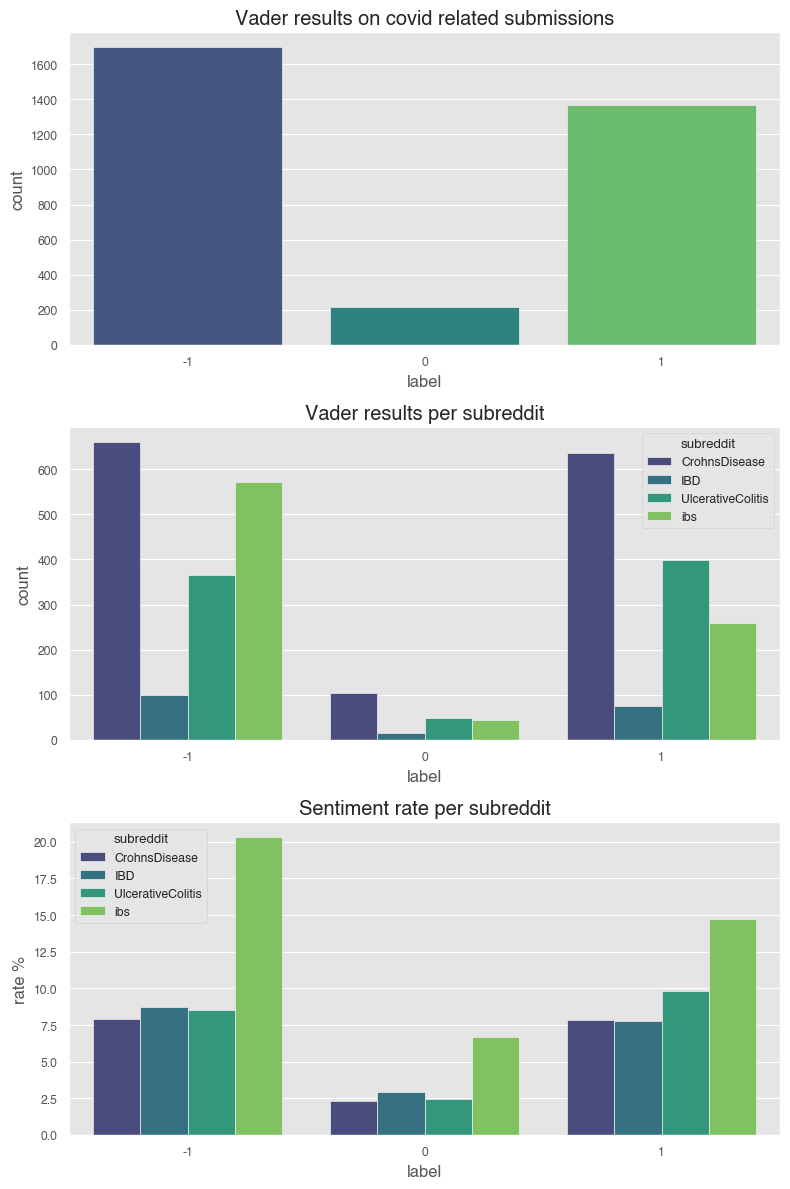

In [82]:
fig, [ax1, ax2, ax3] = plt.subplots(figsize=(8,12), ncols=1, nrows=3)

sns.countplot(data=df_sub_filtered, x='label', ax=ax1, palette='viridis')
ax1.set_title('Vader results on covid related submissions')

sns.countplot(data=df_sub_filtered, x='label', hue='subreddit', ax=ax2, palette='viridis')
ax2.set_title('Vader results per subreddit')

sns.barplot(data=sub_cov_rates, x='label', y='rate', hue='subreddit', palette='viridis', ax=ax3)
plt.title('Sentiment rate per subreddit')
ax3.set_ylabel('rate %')

plt.tight_layout()
plt.show();

In [83]:
df_sub_filt_crohn = df_sub_filtered[df_sub_filtered['subreddit'] == 'CrohnsDisease']
df_sub_filt_ibd = df_sub_filtered[df_sub_filtered['subreddit'] == 'IBD']
df_sub_filt_ibs = df_sub_filtered[df_sub_filtered['subreddit'] == 'ibs']
df_sub_filt_ulc = df_sub_filtered[df_sub_filtered['subreddit'] == 'UlcerativeColitis']

sub_filt_crohn_by_month = df_sub_filt_crohn.groupby('created').sum('compound').compound.values
sub_filt_crohn_posts_ov_time = df_sub_filt_crohn.groupby('created').count().compound.values
sub_filt_crohn_avg_comp = []
for i in range(0, len(sub_filt_crohn_by_month)):
    sub_filt_crohn_avg_comp.append(sub_filt_crohn_by_month[i] / sub_filt_crohn_posts_ov_time[i])
    
sub_filt_ibd_by_month = df_sub_filt_ibd.groupby('created').sum('compound').compound.values
sub_filt_ibd_posts_ov_time = df_sub_filt_ibd.groupby('created').count().compound.values
sub_filt_ibd_avg_comp = []
for i in range(0, len(sub_filt_ibd_by_month)):
    sub_filt_ibd_avg_comp.append(sub_filt_ibd_by_month[i] / sub_filt_ibd_posts_ov_time[i])
    
sub_filt_ibs_by_month = df_sub_filt_ibs.groupby('created').sum('compound').compound.values
sub_filt_ibs_posts_ov_time = df_sub_filt_ibs.groupby('created').count().compound.values
sub_filt_ibs_avg_comp = []
for i in range(0, len(sub_filt_ibs_by_month)):
    sub_filt_ibs_avg_comp.append(sub_filt_ibs_by_month[i] / sub_filt_ibs_posts_ov_time[i])
    
sub_filt_ulc_by_month = df_sub_filt_ulc.groupby('created').sum('compound').compound.values
sub_filt_ulc_posts_ov_time = df_sub_filt_ulc.groupby('created').count().compound.values
sub_filt_ulc_avg_comp = []
for i in range(0, len(sub_filt_ulc_by_month)):
    sub_filt_ulc_avg_comp.append(sub_filt_ulc_by_month[i] / sub_filt_ulc_posts_ov_time[i])

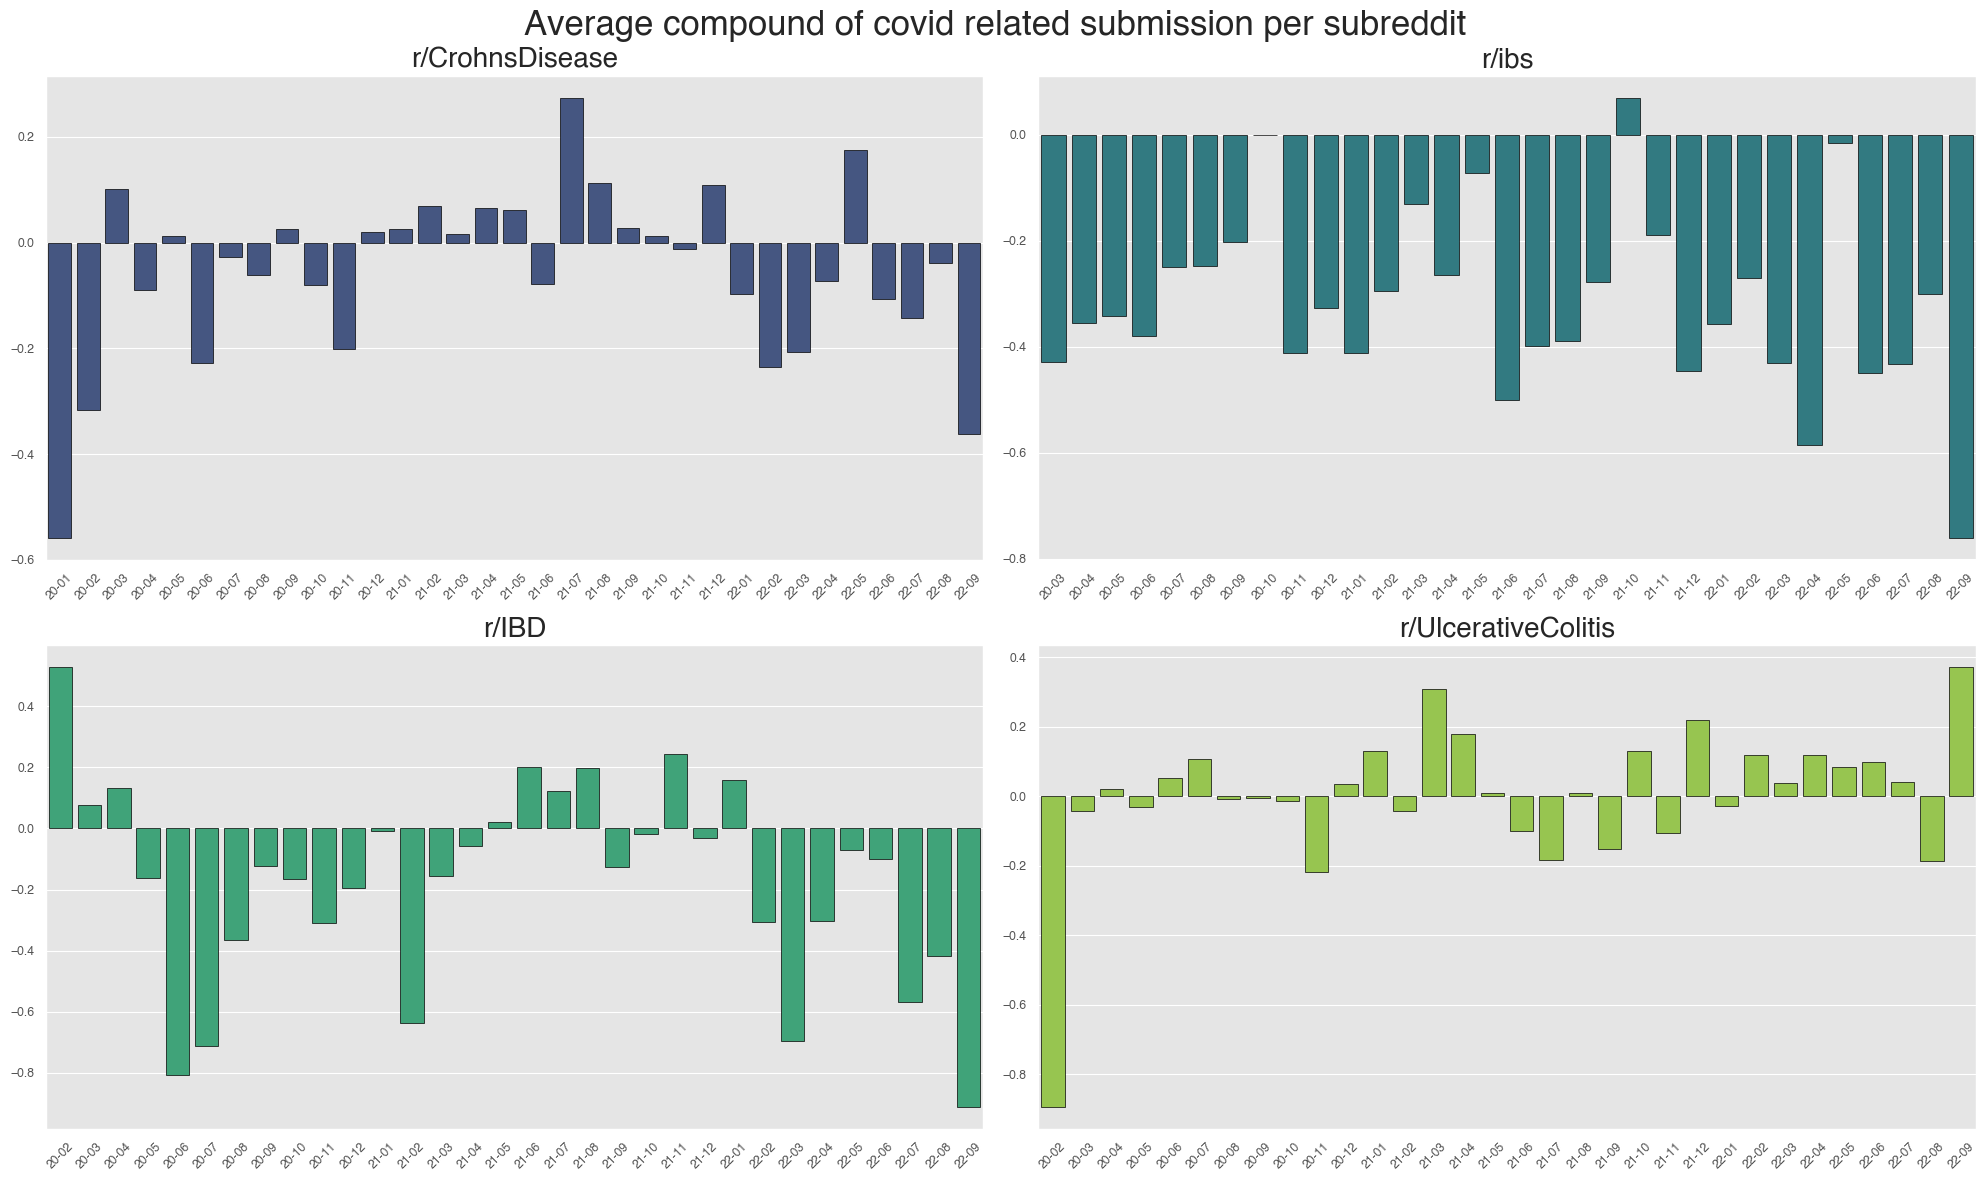

In [84]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20,12), ncols=2, nrows=2)

plt.suptitle('Average compound of covid related submission per subreddit', fontsize=25)

sns.barplot(x=df_sub_filt_crohn.created.unique(), y=sub_filt_crohn_avg_comp, color=cmap(0.25), edgecolor='Black', ax=ax1)
ax1.set_title('r/CrohnsDisease', fontsize=20)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

sns.barplot(x=df_sub_filt_ibs.created.unique(), y=sub_filt_ibs_avg_comp, color=cmap(0.45), edgecolor='Black', ax=ax2)
ax2.set_title('r/ibs', fontsize=20)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

sns.barplot(x=df_sub_filt_ibd.created.unique(), y=sub_filt_ibd_avg_comp, color=cmap(0.65), edgecolor='Black', ax=ax3)
ax3.set_title('r/IBD', fontsize=20)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

sns.barplot(x=df_sub_filt_ulc.created.unique(), y=sub_filt_ulc_avg_comp, color=cmap(0.85), edgecolor='Black', ax=ax4)
ax4.set_title('r/UlcerativeColitis', fontsize=20)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show();

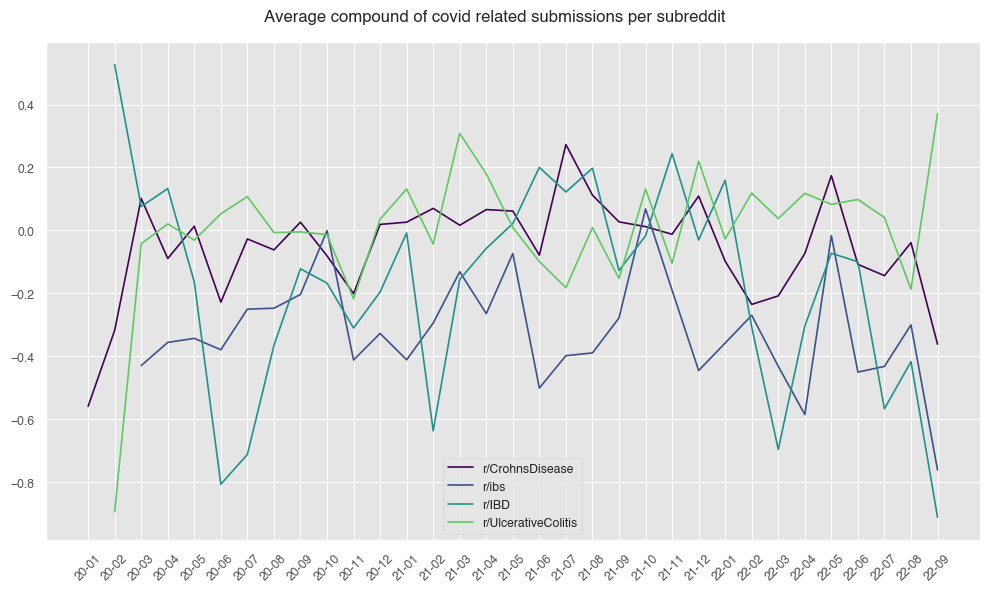

In [85]:
fig, ax1 = plt.subplots(figsize=(10,6))

plt.suptitle('Average compound of covid related submissions per subreddit')

sns.lineplot(x=df_sub_filt_crohn.created.unique(), y=sub_filt_crohn_avg_comp, ax=ax1, label='r/CrohnsDisease', color=cmap(0))
sns.lineplot(x=df_sub_filt_ibs.created.unique(), y=sub_filt_ibs_avg_comp, ax=ax1, label='r/ibs', color=cmap(0.25))
sns.lineplot(x=df_sub_filt_ibd.created.unique(), y=sub_filt_ibd_avg_comp, ax=ax1, label='r/IBD', color=cmap(0.50))
sns.lineplot(x=df_sub_filt_ulc.created.unique(), y=sub_filt_ulc_avg_comp, ax=ax1, label='r/UlcerativeColitis', color=cmap(0.75))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

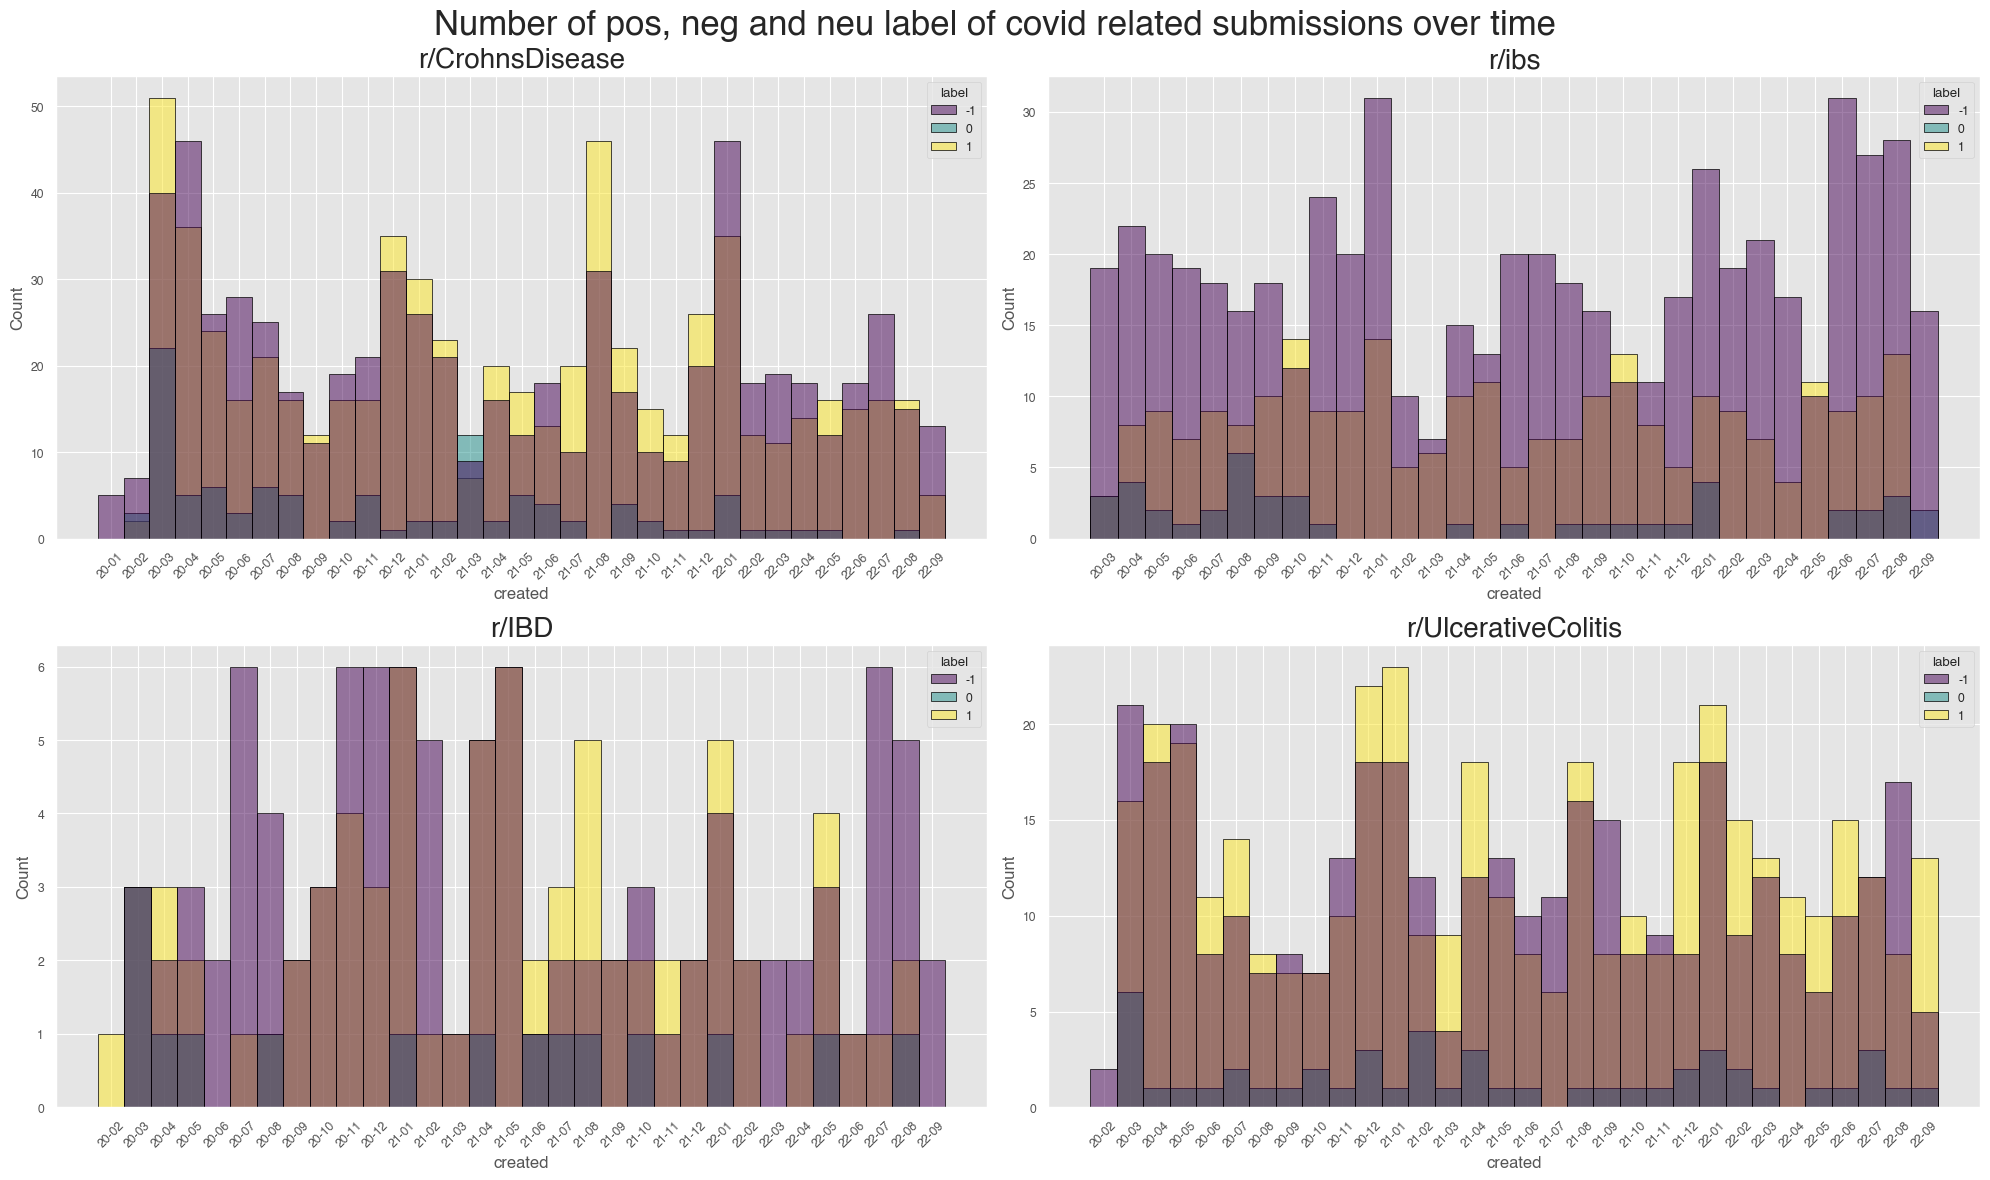

In [86]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20,12), ncols=2, nrows=2)

plt.suptitle('Number of pos, neg and neu label of covid related submissions over time', fontsize=25)

sns.histplot(data=df_sub_filtered[df_sub_filtered['subreddit'] == 'CrohnsDisease'], edgecolor='Black',
              hue='label', x='created', palette='viridis', ax=ax1, color=cmap(0.25))
ax1.set_title('r/CrohnsDisease', fontsize=20)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

sns.histplot(data=df_sub_filtered[df_sub_filtered['subreddit'] == 'ibs'], edgecolor='Black',
              hue='label', x='created', palette='viridis', ax=ax2, color=cmap(0.45))
ax2.set_title('r/ibs', fontsize=20)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

sns.histplot(data=df_sub_filtered[df_sub_filtered['subreddit'] == 'IBD'], edgecolor='Black',
              hue='label', x='created', palette='viridis', ax=ax3, color=cmap(0.65))
ax3.set_title('r/IBD', fontsize=20)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

sns.histplot(data=df_sub_filtered[df_sub_filtered['subreddit'] == 'UlcerativeColitis'], edgecolor='Black',
              hue='label', x='created', palette='viridis', ax=ax4, color=cmap(0.85))
ax4.set_title('r/UlcerativeColitis', fontsize=20)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show();

In [87]:
sub_count_filt_crohn = df_sub_filtered[df_sub_filtered['subreddit'] == 'CrohnsDisease'].groupby('created').count().id.values
sub_count_filt_ibs = df_sub_filtered[df_sub_filtered['subreddit'] == 'ibs'].groupby('created').count().id.values
sub_count_filt_ibd = df_sub_filtered[df_sub_filtered['subreddit'] == 'IBD'].groupby('created').count().id.values
sub_count_filt_ulc = df_sub_filtered[df_sub_filtered['subreddit'] == 'UlcerativeColitis'].groupby('created').count().id.values

dates_filt_sub_crohn = df_sub_filtered[df_sub_filtered['subreddit'] == 'CrohnsDisease'].created.unique()
dates_filt_sub_ibs = df_sub_filtered[df_sub_filtered['subreddit'] == 'ibs'].created.unique()
dates_filt_sub_ibd = df_sub_filtered[df_sub_filtered['subreddit'] == 'IBD'].created.unique()
dates_filt_sub_ulc = df_sub_filtered[df_sub_filtered['subreddit'] == 'UlcerativeColitis'].created.unique()

In [88]:
positives_sub_ibs_cov = df_submissions[(df_submissions['subreddit'] == 'ibs') & (df_submissions['label'] == 1) & (df_submissions['created'].isin(dates_filt_sub_ibs))].groupby('created').count().reset_index().id
negatives_sub_ibs_cov = df_submissions[(df_submissions['subreddit'] == 'ibs') & (df_submissions['label'] == -1) & (df_submissions['created'].isin(dates_filt_sub_ibs))].groupby('created').count().reset_index().id

positives_sub_crohn_cov = df_submissions[(df_submissions['subreddit'] == 'CrohnsDisease') & (df_submissions['label'] == 1) & (df_submissions['created'].isin(dates_filt_sub_crohn))].groupby('created').count().reset_index().id
negatives_sub_crohn_cov = df_submissions[(df_submissions['subreddit'] == 'CrohnsDisease') & (df_submissions['label'] == -1) & (df_submissions['created'].isin(dates_filt_sub_crohn))].groupby('created').count().reset_index().id

positives_sub_ulc_cov = df_submissions[(df_submissions['subreddit'] == 'UlcerativeColitis') & (df_submissions['label'] == 1) & (df_submissions['created'].isin(dates_filt_sub_ulc))].groupby('created').count().reset_index().id
negatives_sub_ulc_cov = df_submissions[(df_submissions['subreddit'] == 'UlcerativeColitis') & (df_submissions['label'] == -1) & (df_submissions['created'].isin(dates_filt_sub_ulc))].groupby('created').count().reset_index().id

positives_sub_ibd_cov = df_submissions[(df_submissions['subreddit'] == 'IBD') & (df_submissions['label'] == 1) & (df_submissions['created'].isin(dates_filt_sub_ibd))].groupby('created').count().reset_index().id
negatives_sub_ibd_cov = df_submissions[(df_submissions['subreddit'] == 'IBD') & (df_submissions['label'] == -1) & (df_submissions['created'].isin(dates_filt_sub_ibd))].groupby('created').count().reset_index().id

ibs_cov_df = pd.DataFrame({
    'month': dates_filt_sub_ibs,
    'positives': positives_sub_ibs_cov,
    'negatives': negatives_sub_ibs_cov,
    'cov_submissions': sub_count_filt_ibs
})

crohn_cov_df = pd.DataFrame({
    'month': dates_filt_sub_crohn,
    'positives': positives_sub_crohn_cov,
    'negatives': negatives_sub_crohn_cov,
    'cov_submissions': sub_count_filt_crohn  
})

ulc_cov_df = pd.DataFrame({
    'month': dates_filt_sub_ulc,
    'positives': positives_sub_ulc_cov,
    'negatives': negatives_sub_ulc_cov,
    'cov_submissions': sub_count_filt_ulc  
})

ibd_cov_df = pd.DataFrame({
    'month': dates_filt_sub_ibd,
    'positives': positives_sub_ibd_cov,
    'negatives': negatives_sub_ibd_cov,
    'cov_submissions': sub_count_filt_ibd 
})

ibs_cov_df['subreddit'] = 'ibs'
crohn_cov_df['subreddit'] = 'CrohnsDisease'
ulc_cov_df['subreddit'] = 'UlcerativeColitis'
ibd_cov_df['subreddit'] = 'IBD'

df_test = pd.concat([ibs_cov_df, crohn_cov_df])
df_test = pd.concat([df_test, ulc_cov_df])
df_test = pd.concat([df_test, ibd_cov_df])

df_test.sample(3)

month  positives  negatives  cov_submissions          subreddit
25  22-03         51         49                2                IBD
26  22-03        311        344               31      CrohnsDisease
20  21-10        214        184               19  UlcerativeColitis

#### When the number of  covid related submission in a month is high, does the total number of negatives post increase as well for that month? 

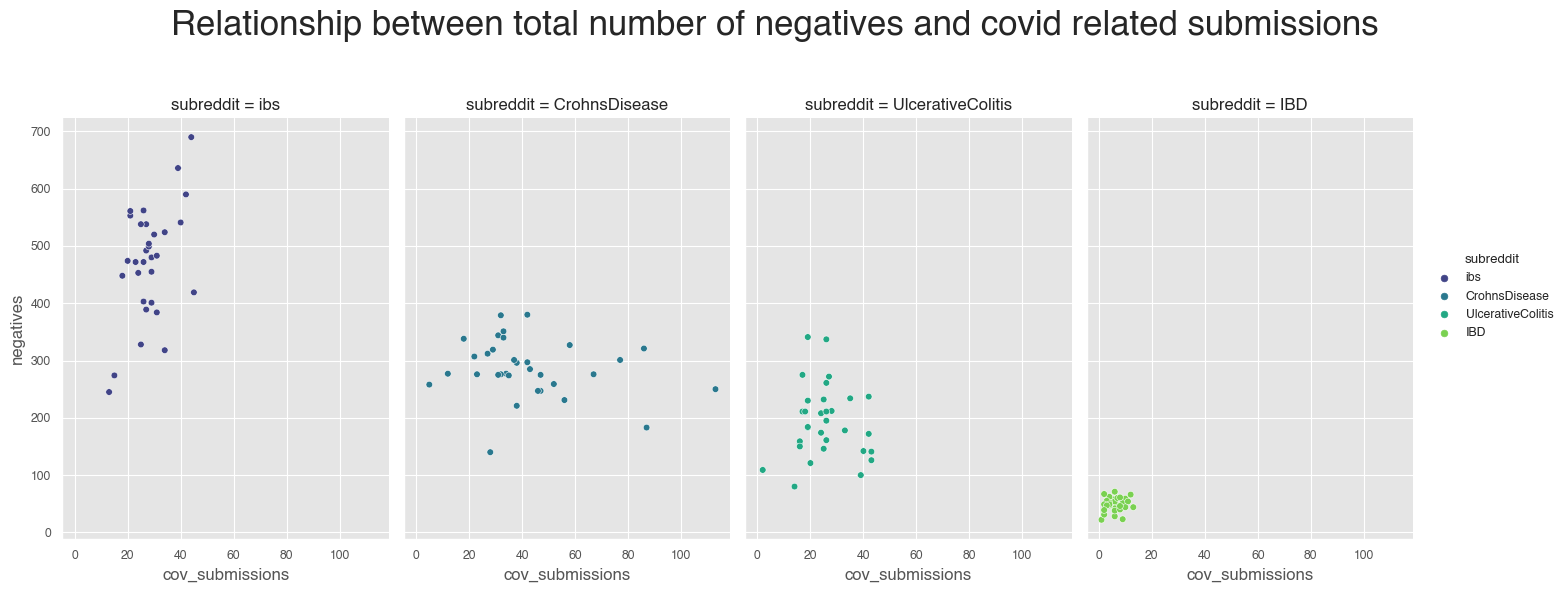

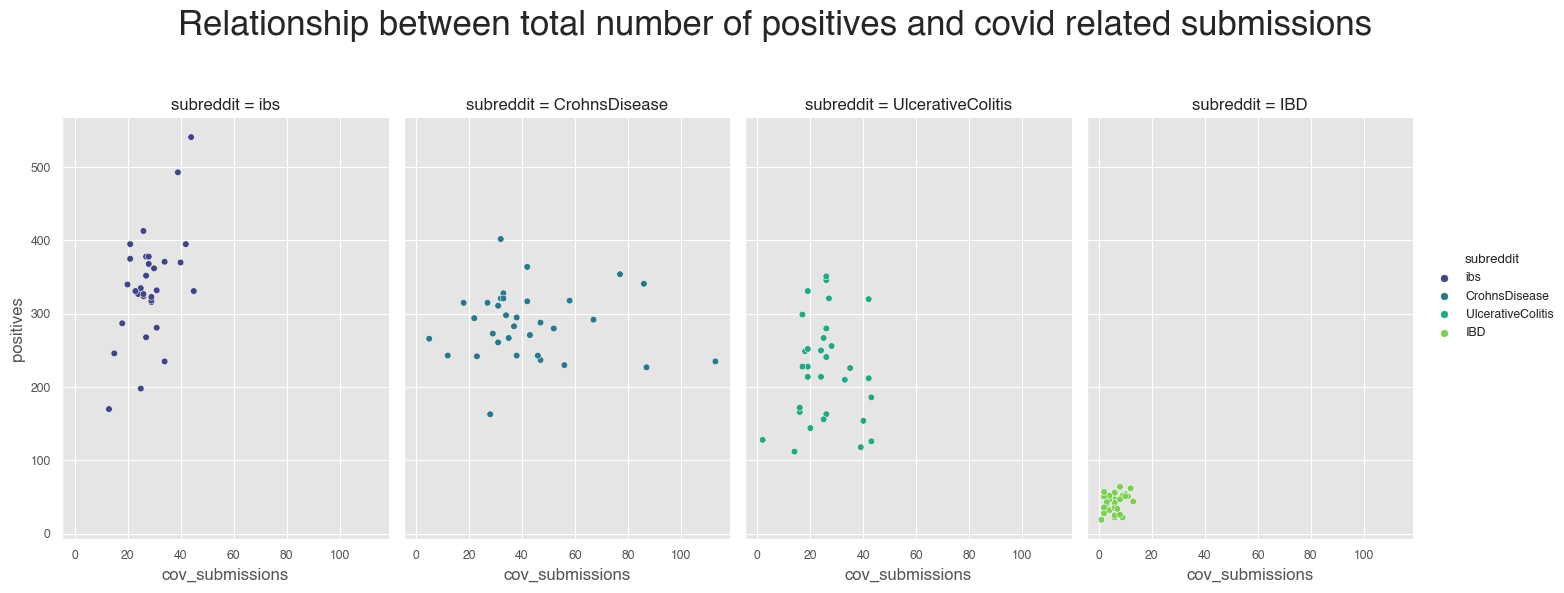

In [89]:
g = sns.relplot(
    data=df_test,
    x='cov_submissions',
    y='negatives',
    palette='viridis',
    col='subreddit',
    hue='subreddit',
    height=6, aspect=0.6
)

axes = g.axes.flatten()
    
g.figure.subplots_adjust(top=0.8);
g.figure.suptitle(
    'Relationship between total number of negatives and covid related submissions',
    fontsize=25
);

g = sns.relplot(
    data=df_test,
    x='cov_submissions',
    y='positives',
    palette='viridis',
    hue='subreddit',
    col='subreddit',
    height=6, aspect=0.6
)

axes = g.axes.flatten()
    
g.figure.subplots_adjust(top=0.8);
g.figure.suptitle(
    'Relationship between total number of positives and covid related submissions',
    fontsize=25
);

#### Is there relationship between the number of covid post in a monht and the average compound in that month?

In [90]:
df_sub_num_cov_post = pd.DataFrame({
    'month': df_sub_filtered.groupby('created').count().reset_index().created,
    'num_of_covid_post': df_sub_filtered.groupby('created').count().reset_index().id,
    'avg_sentiment': sub_avg_sentiments[len(sub_avg_sentiments) - len(df_sub_filtered.groupby('created').count().reset_index().created):],
    'avg_sentiment_in_covid_post': sub_filt_avg_sentiments
})

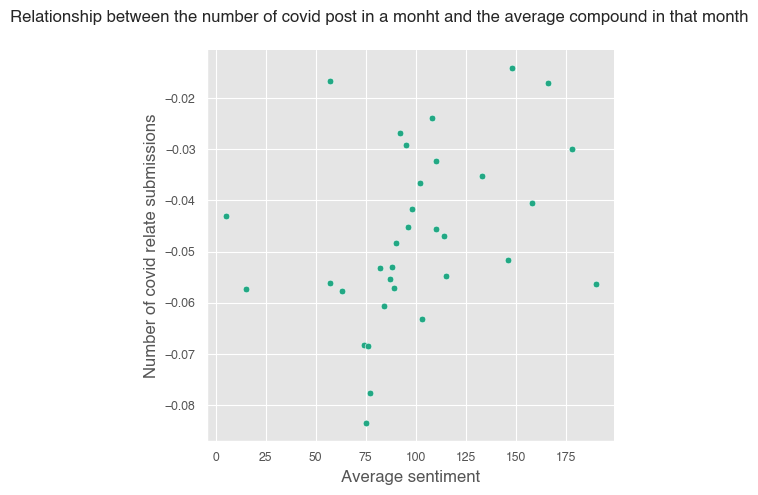

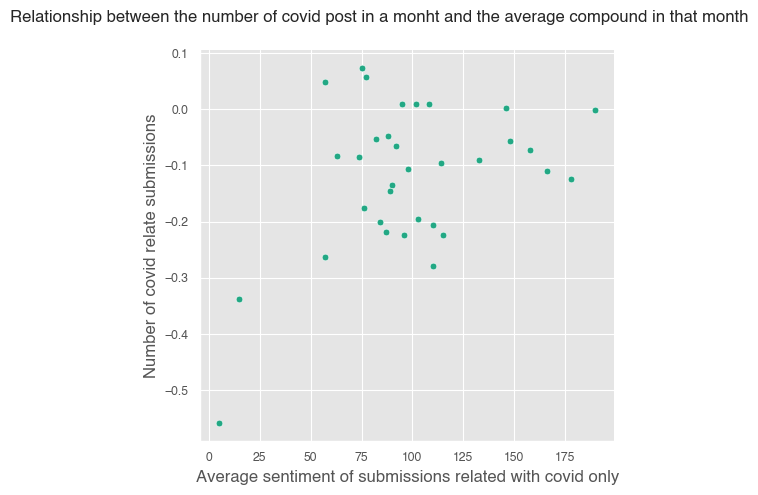

In [91]:
g = sns.relplot(
    data=df_sub_num_cov_post,
    y='avg_sentiment',
    x='num_of_covid_post',
    color=main_color
)

axes = g.axes.flatten()
for ax in axes:
    ax.set_ylabel('Number of covid relate submissions')
    ax.set_xlabel('Average sentiment')
    
g.figure.subplots_adjust(top=0.9);
g.figure.suptitle(
    'Relationship between the number of covid post in a monht and the average compound in that month',
    fontsize=12
);

g = sns.relplot(
    data=df_sub_num_cov_post,
    y='avg_sentiment_in_covid_post',
    x='num_of_covid_post',
    color=main_color
)

axes = g.axes.flatten()
for ax in axes:
    ax.set_ylabel('Number of covid relate submissions')
    ax.set_xlabel('Average sentiment of submissions related with covid only')
    
        
g.figure.subplots_adjust(top=0.9);
g.figure.suptitle(
    'Relationship between the number of covid post in a monht and the average compound in that month',
    fontsize=12
);

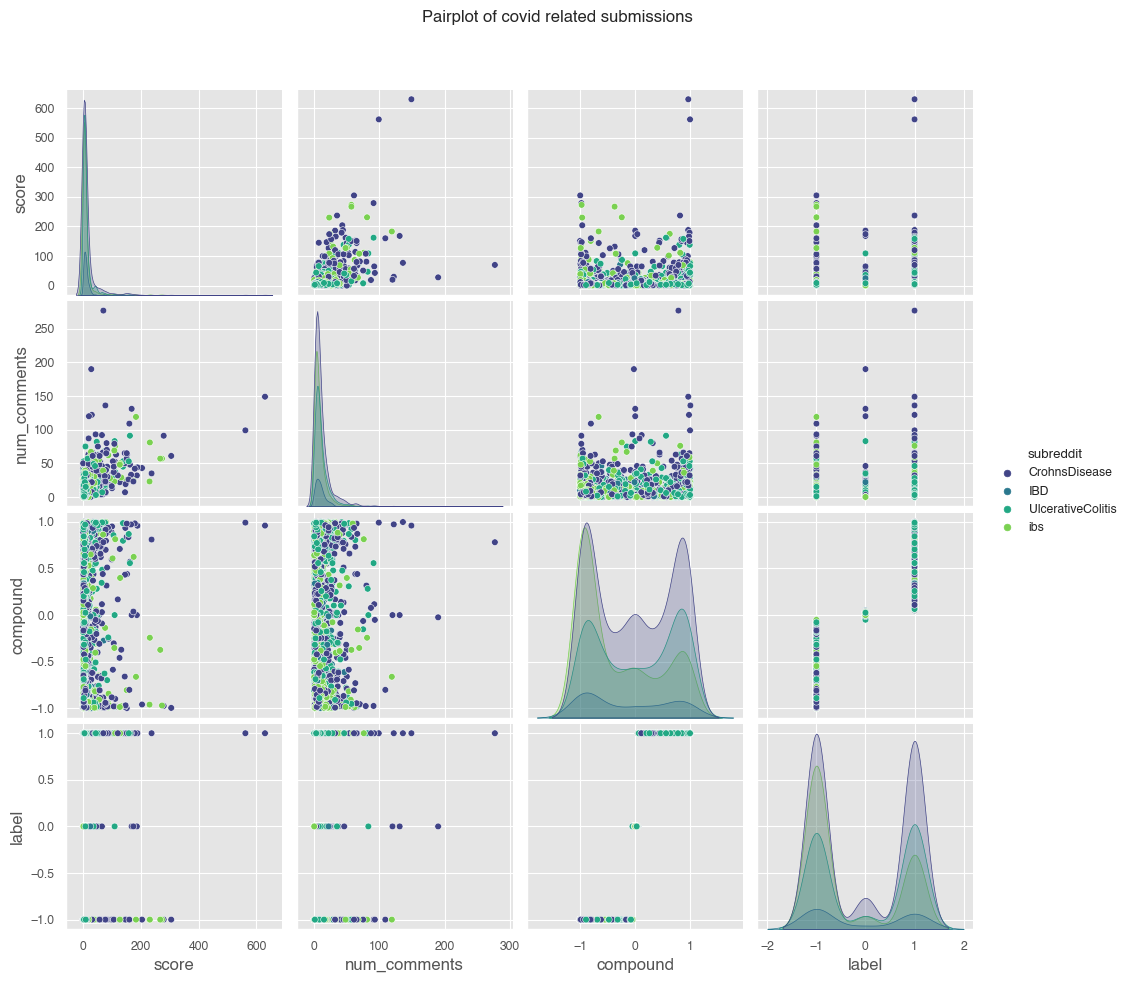

In [92]:
g = sns.pairplot(df_sub_filtered, hue='subreddit', palette='viridis')

g.figure.subplots_adjust(top=0.9);
g.figure.suptitle(
    'Pairplot of covid related submissions',
    fontsize=12
);

### Analysis on covid related comments

In [93]:
cmap = matplotlib.cm.get_cmap('cividis')
main_color = cmap(0.6)

In [94]:
regxpr = '|'.join([f'{p}' for p in patterns])

simple_pattern = '|'.join([f'{p}' for p in covid_keywords])

In [95]:
df_comm_filtered = df_comments[df_comments.body.str.contains(simple_pattern)].copy()
#df_sub_filtered = df_submissions[df_submissions.title_and_body.str.contains(regexpr)]

In [96]:
comm_filt_compound_by_month = df_comm_filtered.groupby('created').sum('compound').compound.values
comm_filt_number_of_posts_over_time = df_comm_filtered.groupby('created').count().compound.values
comm_filt_avg_sentiments = []
for i in range(0, len(comm_filt_compound_by_month)):
    comm_filt_avg_sentiments.append(comm_filt_compound_by_month[i] / comm_filt_number_of_posts_over_time[i])

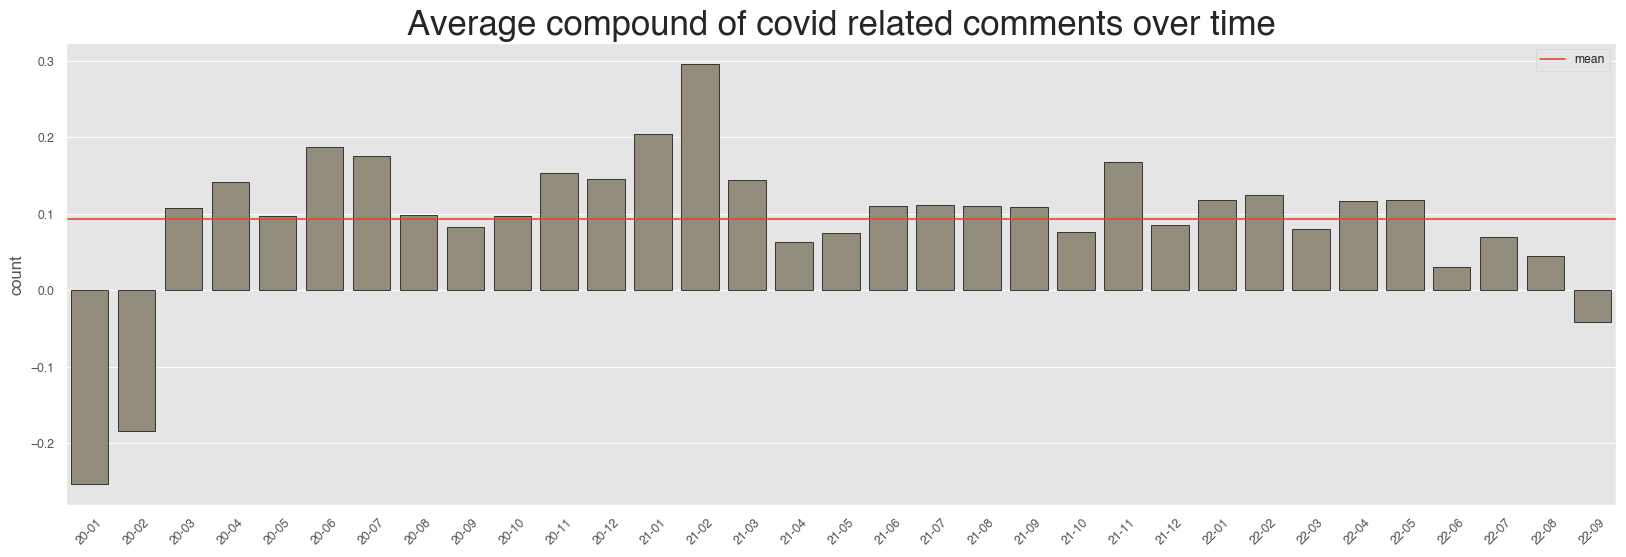

In [97]:
fig, ax = plt.subplots(figsize=(20,6))

plt.title('Average compound of covid related comments over time', fontsize=25)
sns.barplot(x=df_comm_filtered.created.unique(), y=comm_filt_avg_sentiments, color=main_color, edgecolor='black')
plt.ylabel('count')
plt.xlabel('')
plt.xticks(rotation=45)
plt.axhline(mean(comm_filt_avg_sentiments), label='mean')

plt.legend()
plt.show();

In [98]:
comm_cov_rates = []
for sr in subreddits:
    dd = df_comments[df_comments['subreddit'] == sr]
    dd_pos = dd[dd['label'] == 1]
    dd_neg = dd[dd['label'] == -1]
    dd_neu = dd[dd['label'] == 0]
    pos_rate = dd_pos.shape[0] / df_comm_filtered[df_comm_filtered['subreddit'] == sr].shape[0]
    neg_rate = dd_neg.shape[0] / df_comm_filtered[df_comm_filtered['subreddit'] == sr].shape[0]
    neu_rate = dd_neu.shape[0] / df_comm_filtered[df_comm_filtered['subreddit'] == sr].shape[0]
    
    comm_cov_rates.append((pos_rate, sr, 1))
    comm_cov_rates.append((neg_rate, sr, -1))
    comm_cov_rates.append((neu_rate, sr, 0))
    
comm_cov_rates = pd.DataFrame(comm_cov_rates, columns=['rate', 'subreddit', 'label'])

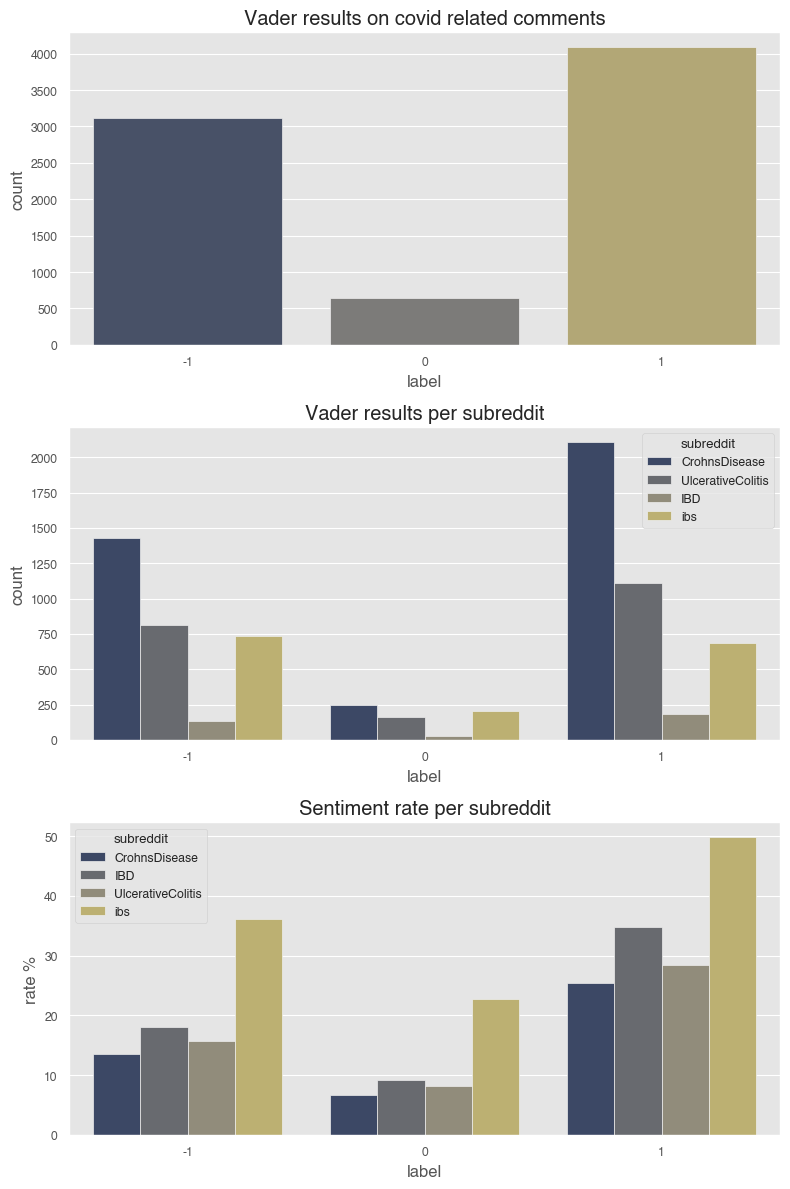

In [99]:
fig, [ax1, ax2, ax3] = plt.subplots(figsize=(8,12), ncols=1, nrows=3)

sns.countplot(data=df_comm_filtered, x='label', ax=ax1, palette='cividis')
ax1.set_title('Vader results on covid related comments')

sns.countplot(data=df_comm_filtered, x='label', hue='subreddit', ax=ax2, palette='cividis')
ax2.set_title('Vader results per subreddit')

sns.barplot(data=comm_cov_rates, x='label', y='rate', hue='subreddit', palette='cividis', ax=ax3)
plt.title('Sentiment rate per subreddit')
ax3.set_ylabel('rate %')

plt.tight_layout()
plt.show();

In [100]:
df_comm_filt_crohn = df_comm_filtered[df_comm_filtered['subreddit'] == 'CrohnsDisease']
df_comm_filt_ibd = df_comm_filtered[df_comm_filtered['subreddit'] == 'IBD']
df_comm_filt_ibs = df_comm_filtered[df_comm_filtered['subreddit'] == 'ibs']
df_comm_filt_ulc = df_comm_filtered[df_comm_filtered['subreddit'] == 'UlcerativeColitis']

comm_filt_crohn_by_month = df_comm_filt_crohn.groupby('created').sum('compound').compound.values
comm_filt_crohn_posts_ov_time = df_comm_filt_crohn.groupby('created').count().compound.values
comm_filt_crohn_avg_comp = []
for i in range(0, len(comm_filt_crohn_by_month)):
    comm_filt_crohn_avg_comp.append(comm_filt_crohn_by_month[i] / comm_filt_crohn_posts_ov_time[i])
    
comm_filt_ibd_by_month = df_comm_filt_ibd.groupby('created').sum('compound').compound.values
comm_filt_ibd_posts_ov_time = df_comm_filt_ibd.groupby('created').count().compound.values
comm_filt_ibd_avg_comp = []
for i in range(0, len(comm_filt_ibd_by_month)):
    comm_filt_ibd_avg_comp.append(comm_filt_ibd_by_month[i] / comm_filt_ibd_posts_ov_time[i])
    
comm_filt_ibs_by_month = df_comm_filt_ibs.groupby('created').sum('compound').compound.values
comm_filt_ibs_posts_ov_time = df_comm_filt_ibs.groupby('created').count().compound.values
comm_filt_ibs_avg_comp = []
for i in range(0, len(comm_filt_ibs_by_month)):
    comm_filt_ibs_avg_comp.append(comm_filt_ibs_by_month[i] / comm_filt_ibs_posts_ov_time[i])
    
comm_filt_ulc_by_month = df_comm_filt_ulc.groupby('created').sum('compound').compound.values
comm_filt_ulc_posts_ov_time = df_comm_filt_ulc.groupby('created').count().compound.values
comm_filt_ulc_avg_comp = []
for i in range(0, len(comm_filt_ulc_by_month)):
    comm_filt_ulc_avg_comp.append(comm_filt_ulc_by_month[i] / comm_filt_ulc_posts_ov_time[i])

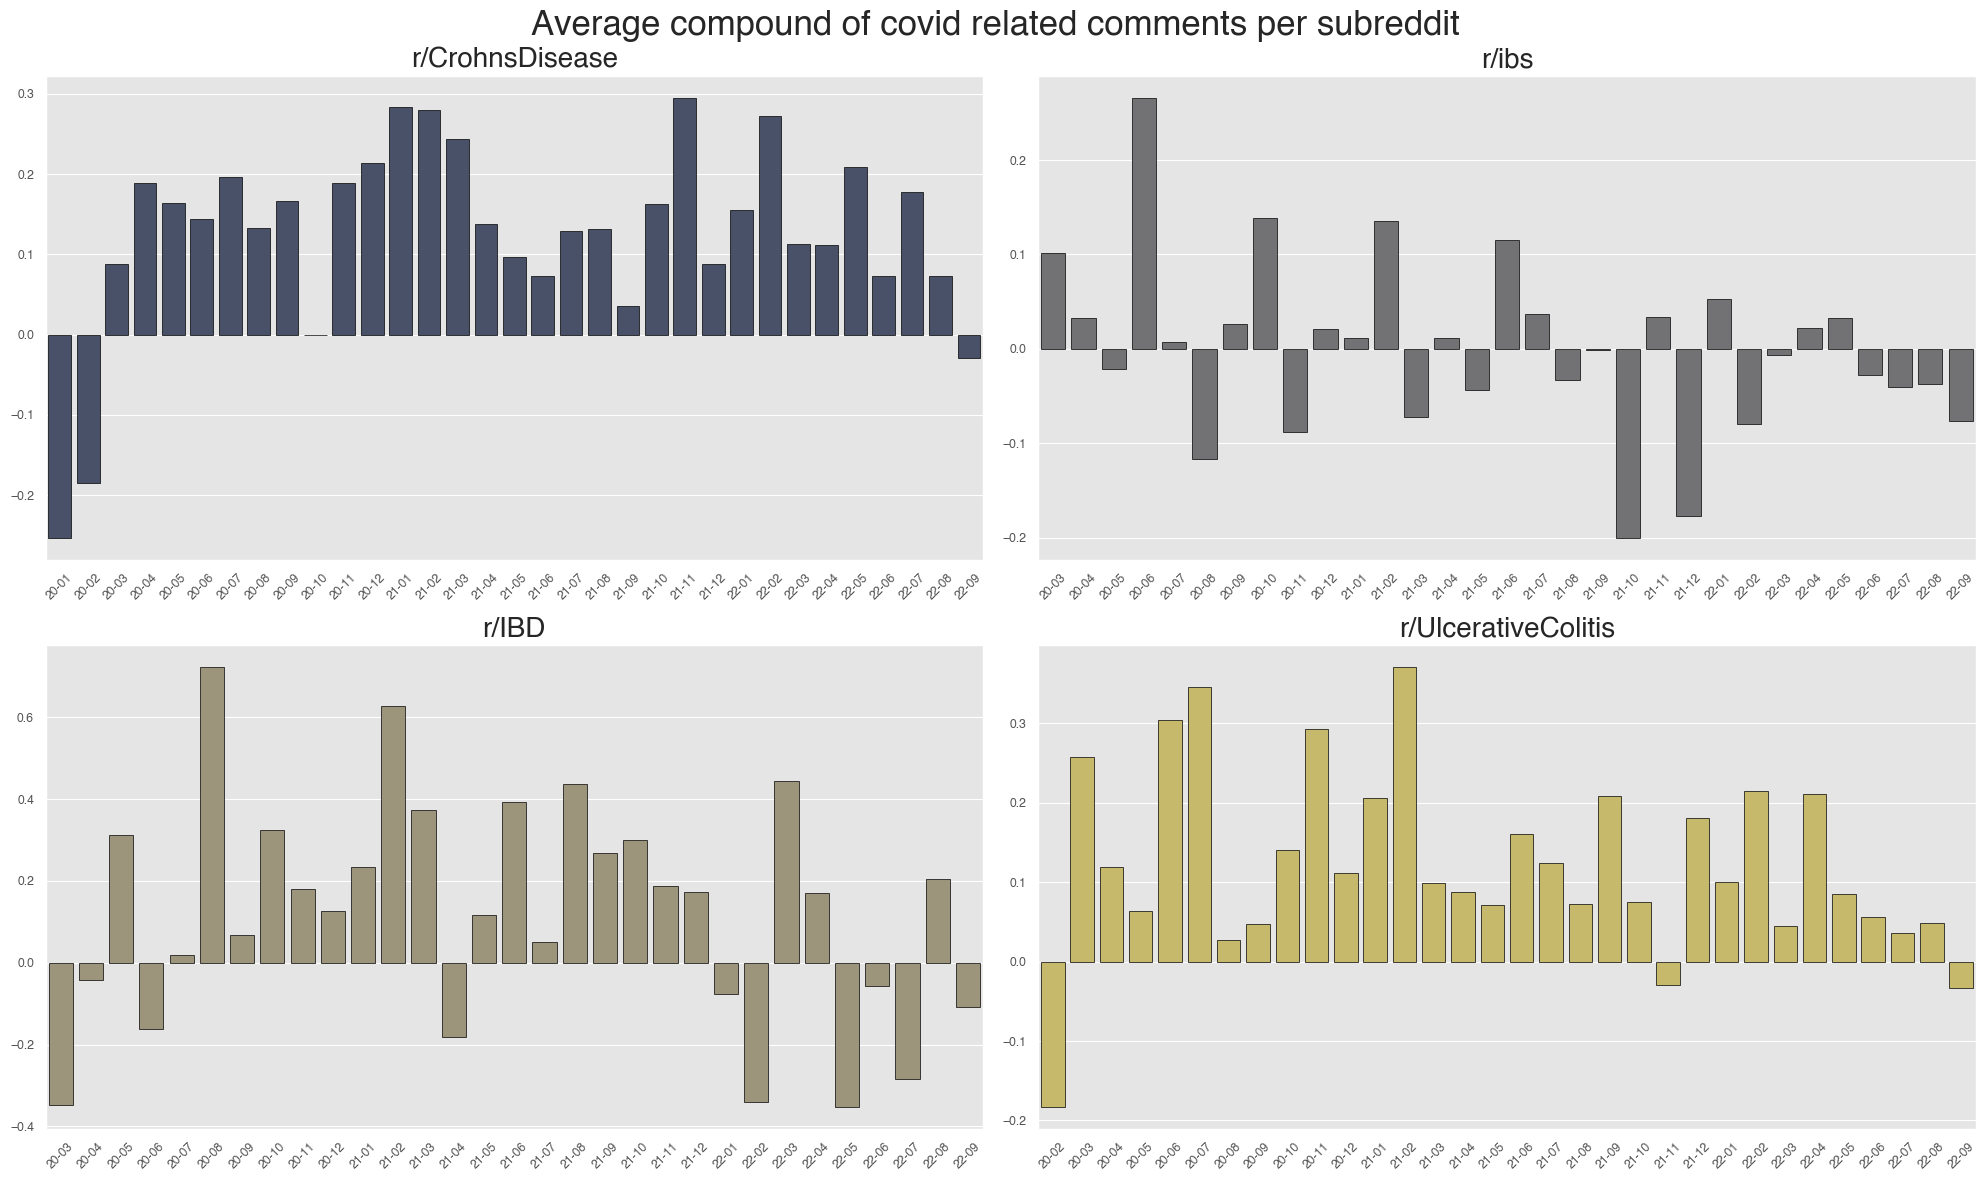

In [101]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20,12), ncols=2, nrows=2)

plt.suptitle('Average compound of covid related comments per subreddit', fontsize=25)

sns.barplot(x=df_comm_filt_crohn.created.unique(), y=comm_filt_crohn_avg_comp, color=cmap(0.25), edgecolor='Black', ax=ax1)
ax1.set_title('r/CrohnsDisease', fontsize=20)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

sns.barplot(x=df_comm_filt_ibs.created.unique(), y=comm_filt_ibs_avg_comp, color=cmap(0.45), edgecolor='Black', ax=ax2)
ax2.set_title('r/ibs', fontsize=20)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

sns.barplot(x=df_comm_filt_ibd.created.unique(), y=comm_filt_ibd_avg_comp, color=cmap(0.65), edgecolor='Black', ax=ax3)
ax3.set_title('r/IBD', fontsize=20)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

sns.barplot(x=df_comm_filt_ulc.created.unique(), y=comm_filt_ulc_avg_comp, color=cmap(0.85), edgecolor='Black', ax=ax4)
ax4.set_title('r/UlcerativeColitis', fontsize=20)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show();

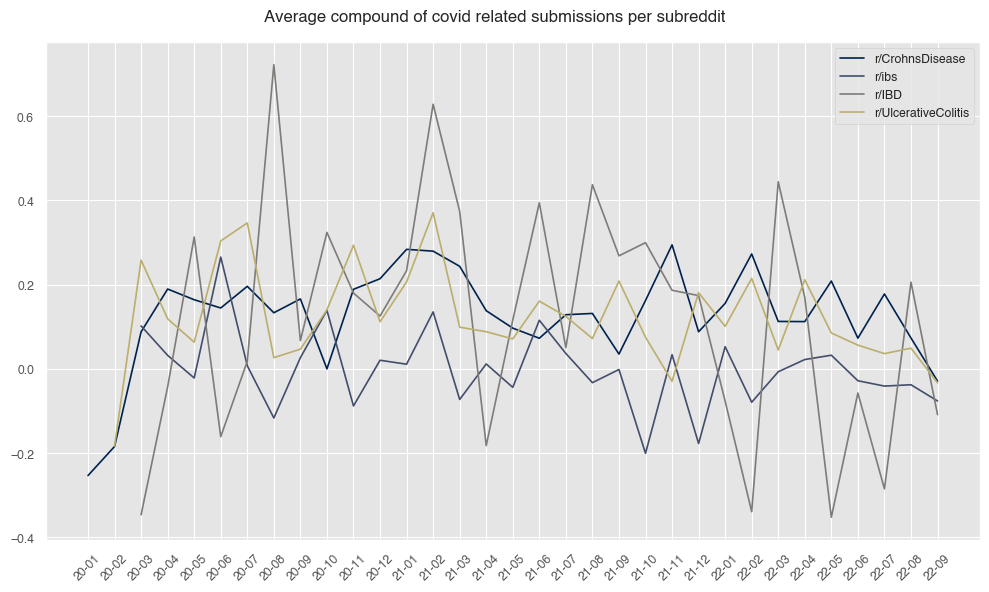

In [102]:
fig, ax1 = plt.subplots(figsize=(10,6))

plt.suptitle('Average compound of covid related submissions per subreddit')

sns.lineplot(x=df_comm_filt_crohn.created.unique(), y=comm_filt_crohn_avg_comp, ax=ax1, label='r/CrohnsDisease', color=cmap(0))
sns.lineplot(x=df_comm_filt_ibs.created.unique(), y=comm_filt_ibs_avg_comp, ax=ax1, label='r/ibs', color=cmap(0.25))
sns.lineplot(x=df_comm_filt_ibd.created.unique(), y=comm_filt_ibd_avg_comp, ax=ax1, label='r/IBD', color=cmap(0.50))
sns.lineplot(x=df_comm_filt_ulc.created.unique(), y=comm_filt_ulc_avg_comp, ax=ax1, label='r/UlcerativeColitis', color=cmap(0.75))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

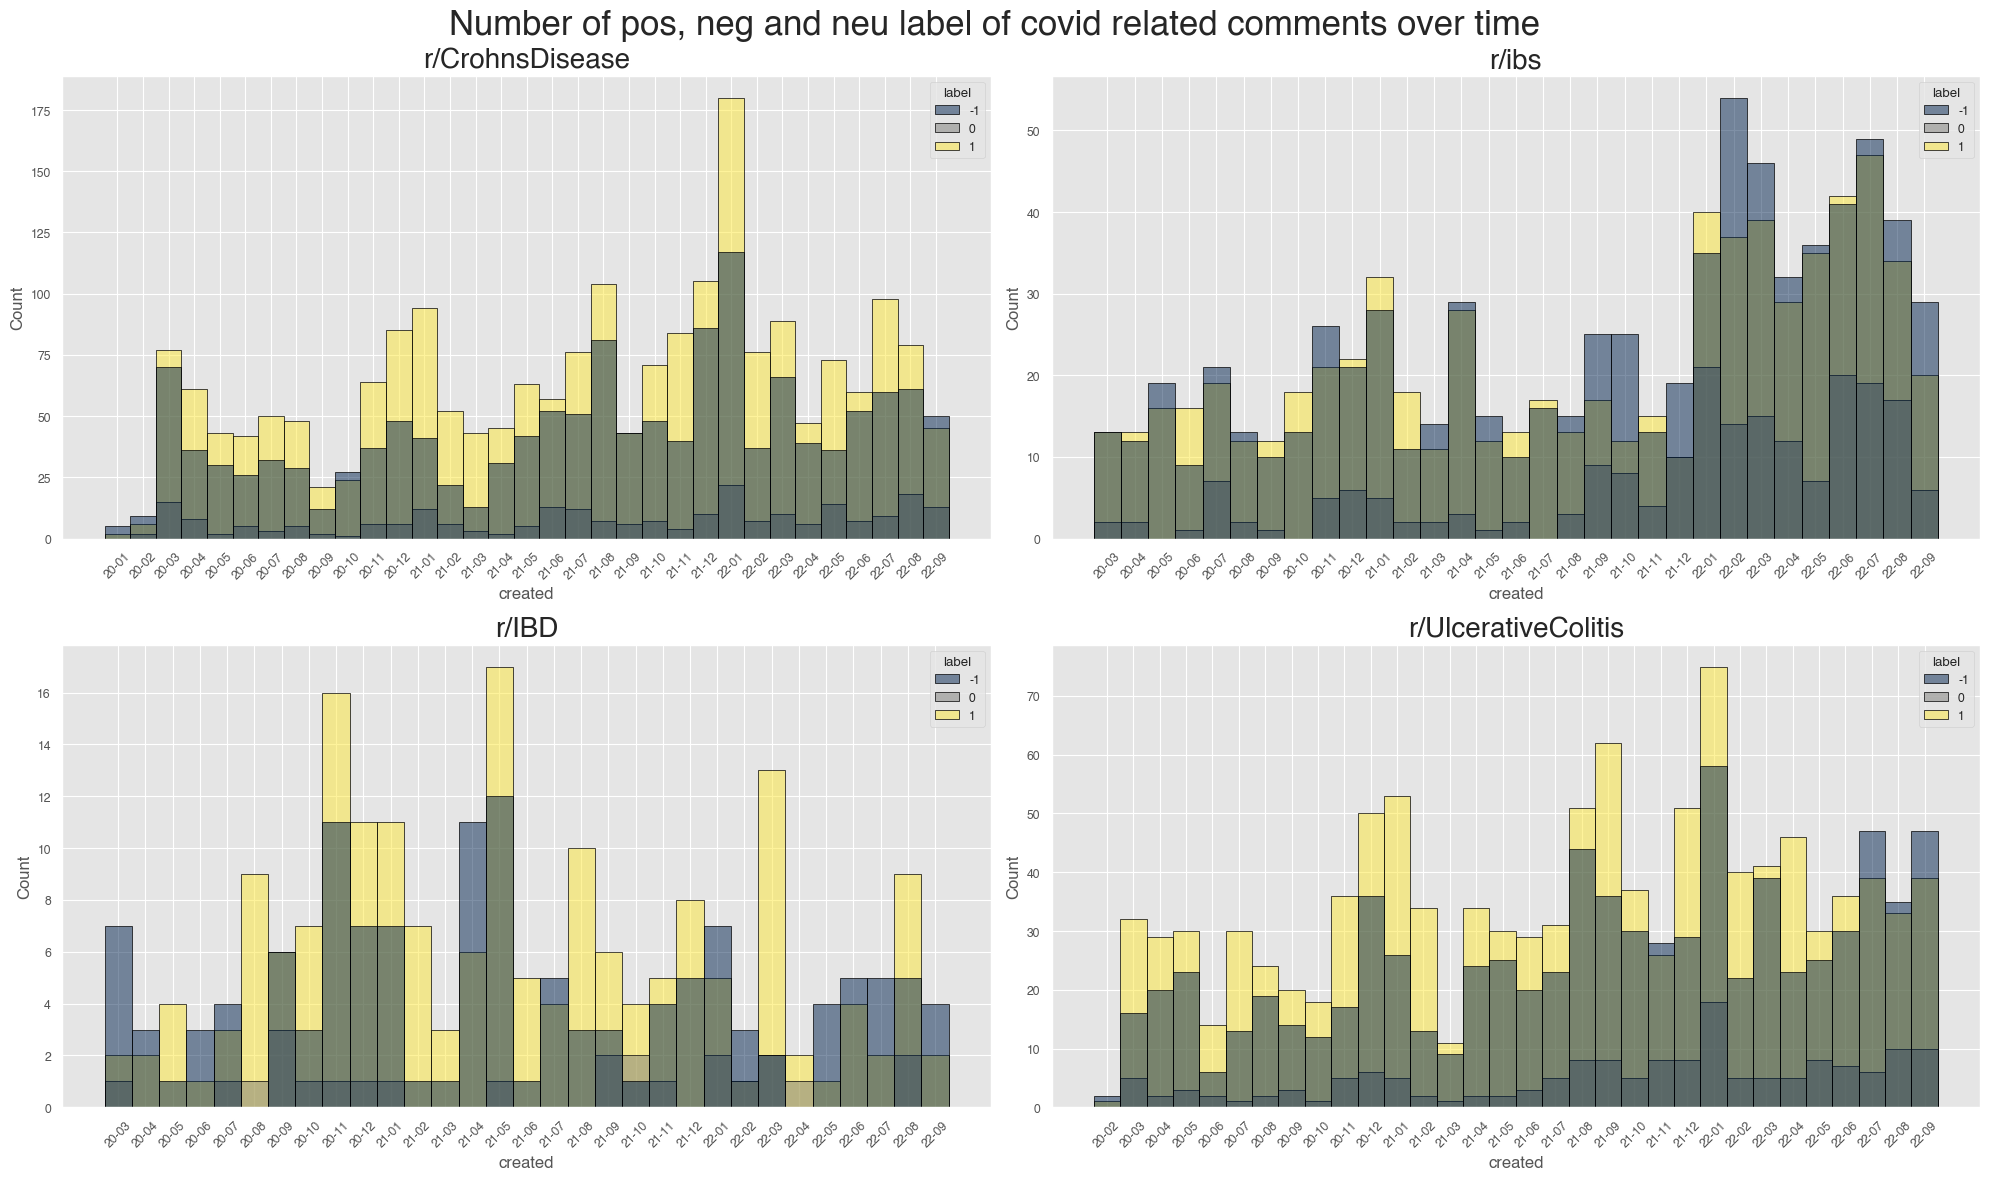

In [103]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20,12), ncols=2, nrows=2)

plt.suptitle('Number of pos, neg and neu label of covid related comments over time', fontsize=25)

sns.histplot(data=df_comm_filtered[df_comm_filtered['subreddit'] == 'CrohnsDisease'], edgecolor='Black',
              hue='label', x='created', palette='cividis', ax=ax1)
ax1.set_title('r/CrohnsDisease', fontsize=20)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

sns.histplot(data=df_comm_filtered[df_comm_filtered['subreddit'] == 'ibs'], edgecolor='Black',
              hue='label', x='created', palette='cividis', ax=ax2)
ax2.set_title('r/ibs', fontsize=20)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

sns.histplot(data=df_comm_filtered[df_comm_filtered['subreddit'] == 'IBD'], edgecolor='Black',
              hue='label', x='created', palette='cividis', ax=ax3)
ax3.set_title('r/IBD', fontsize=20)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

sns.histplot(data=df_comm_filtered[df_comm_filtered['subreddit'] == 'UlcerativeColitis'], edgecolor='Black',
              hue='label', x='created', palette='cividis', ax=ax4)
ax4.set_title('r/UlcerativeColitis', fontsize=20)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show();

In [104]:
top_negatives_cov_sub = df_sub_filtered.sort_values(by='compound', ascending=True).iloc[0:100]

top_negatives_tree = pd.DataFrame(top_negatives_cov_sub)
top_negatives_tree['type'] = 'submission'
for _id in top_negatives_cov_sub['id']:
    _id = 't3_' + _id
    lis = df_comments[df_comments['parent_id'] == _id]
    if lis.shape[0] > 5:
        lis['number_of_post_in_tree'] = lis.shape[0]
        top_negatives_tree = pd.concat([top_negatives_tree, lis])
    
top_negatives_sub_in_tree = top_negatives_tree.parent_id.unique()

def remove_t3(text):
    text = str(text)
    return text[3:]

top_negatives_sub_in_tree = list(map(remove_t3, top_negatives_sub_in_tree))

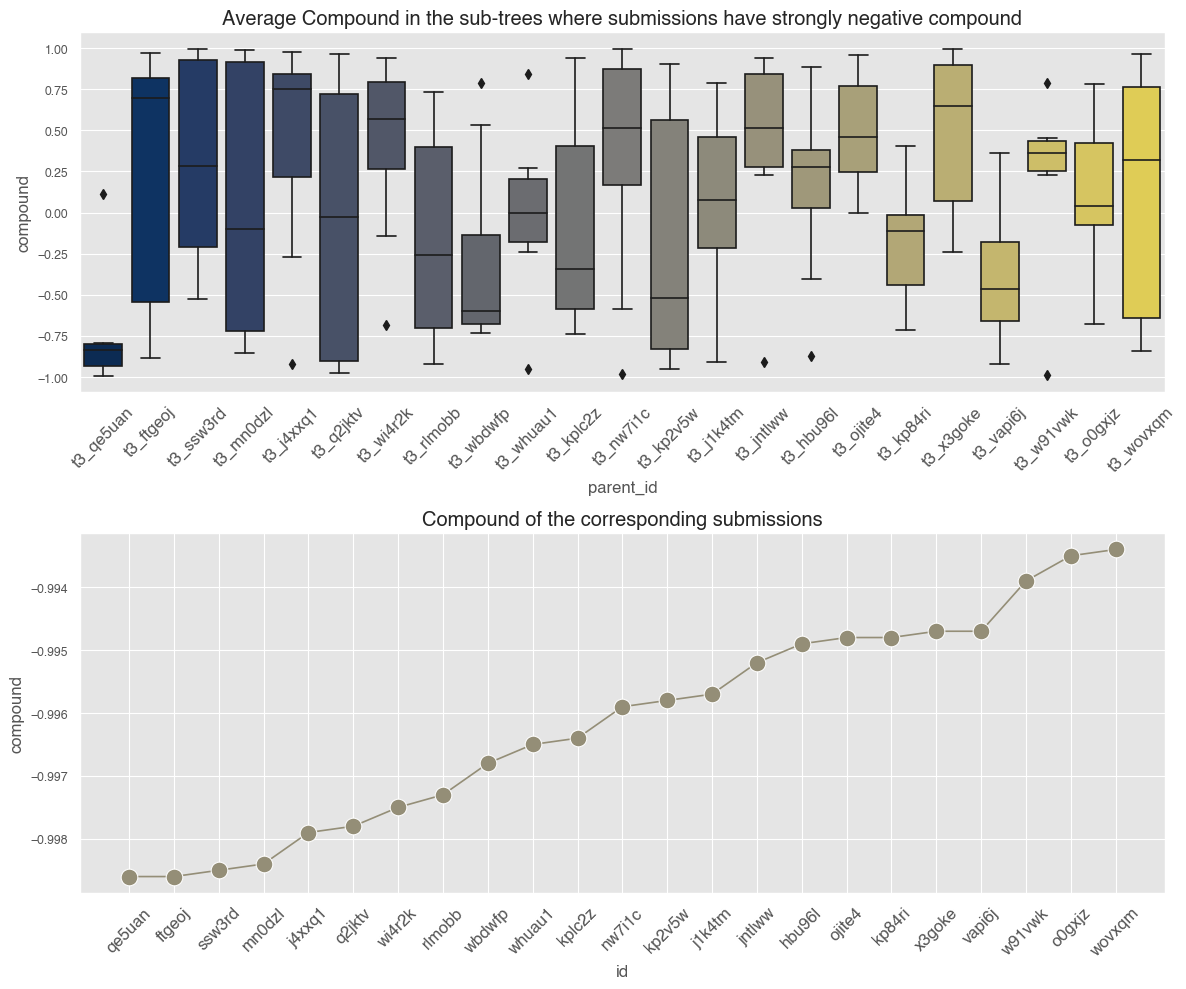

In [105]:
fig, [ax1, ax2] = plt.subplots(figsize=(12, 10), nrows=2)

sns.boxplot(x='parent_id', y='compound', data=top_negatives_tree, palette='cividis', ax=ax1)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
ax1.set_title('Average Compound in the sub-trees where submissions have strongly negative compound')
ax1.xaxis.set_tick_params(labelsize=12)

sns.lineplot(x='id', y='compound', data=top_negatives_tree[(top_negatives_tree['type'] == 'submission') & (top_negatives_tree['id'].isin(top_negatives_sub_in_tree))], 
            ax=ax2, marker='o', markersize=12, color=main_color)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
ax2.set_title('Compound of the corresponding submissions')
ax2.xaxis.set_tick_params(labelsize=12)

plt.tight_layout()
plt.show();

#### Relationship between the sentiment in a subtree and the number of comments

In [113]:
a = df_comments.groupby('parent_id').sum('compound').reset_index()
a['parent_id'] = a.parent_id.apply(lambda x: remove_t3(x))

a = a[a['parent_id'].isin(df_submissions.id.unique())]
b = df_submissions[['id', 'num_comments']]
a.rename(columns={'parent_id': 'id'}, inplace=True)
a = a.merge(b, on='id')

a['avg_comp'] = a['compound'] / a['num_comments']

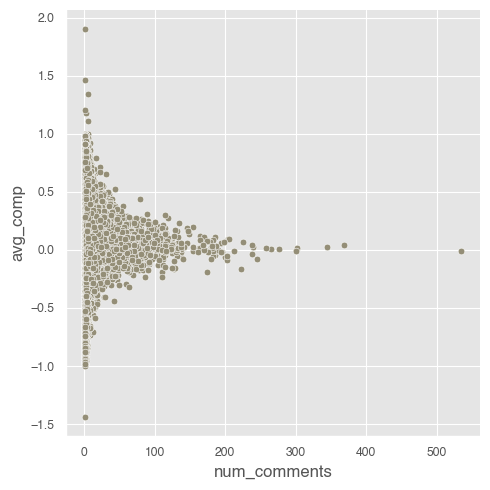

In [114]:
sns.relplot(data=a, y='avg_comp', x='num_comments', color=main_color)
plt.show()

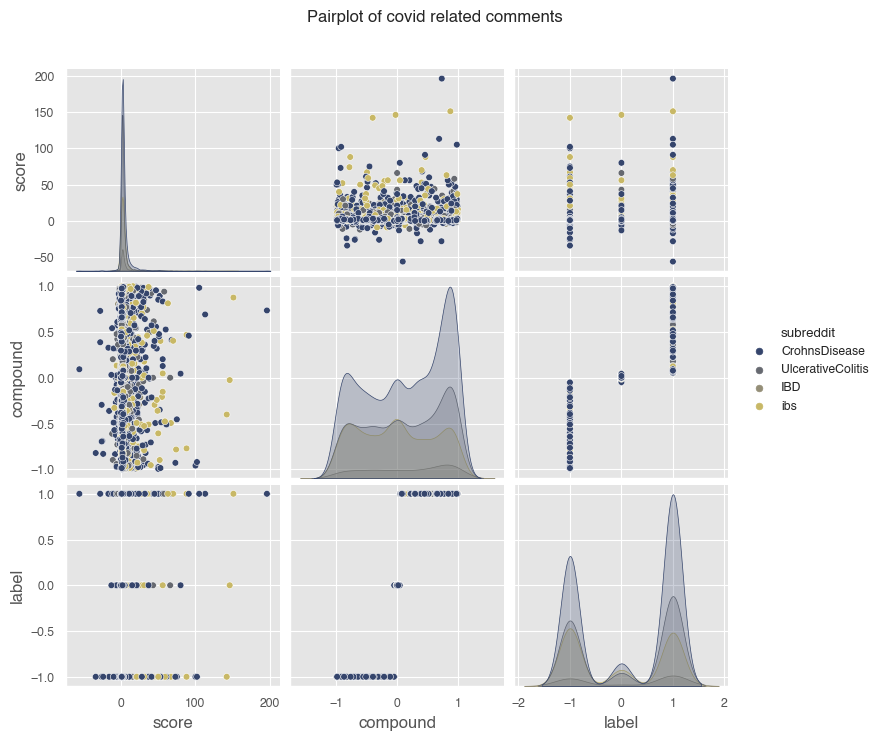

In [116]:
g = sns.pairplot(df_comm_filtered, hue='subreddit', palette='cividis')

g.figure.subplots_adjust(top=0.9);
g.figure.suptitle(
    'Pairplot of covid related comments',
    fontsize=12
);

### TF-IDF (Term Frequency — Inverse Document Frequency)

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [118]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)

tfIdf_sub = tfIdfVectorizer.fit_transform(df_sub_filtered.title_and_body)
results_tf_idf_sub = pd.DataFrame(tfIdf_sub[0].T.todense(), index=tfIdfVectorizer.get_feature_names_out(), columns=["TF-IDF"])
results_tf_idf_sub = results_tf_idf_sub.sort_values('TF-IDF', ascending=False).reset_index()

tfIdf_comm = tfIdfVectorizer.fit_transform(df_comm_filtered.body)
results_tf_idf_comm = pd.DataFrame(tfIdf_comm[0].T.todense(), index=tfIdfVectorizer.get_feature_names_out(), columns=["TF-IDF"])
results_tf_idf_comm = results_tf_idf_comm.sort_values('TF-IDF', ascending=False).reset_index()

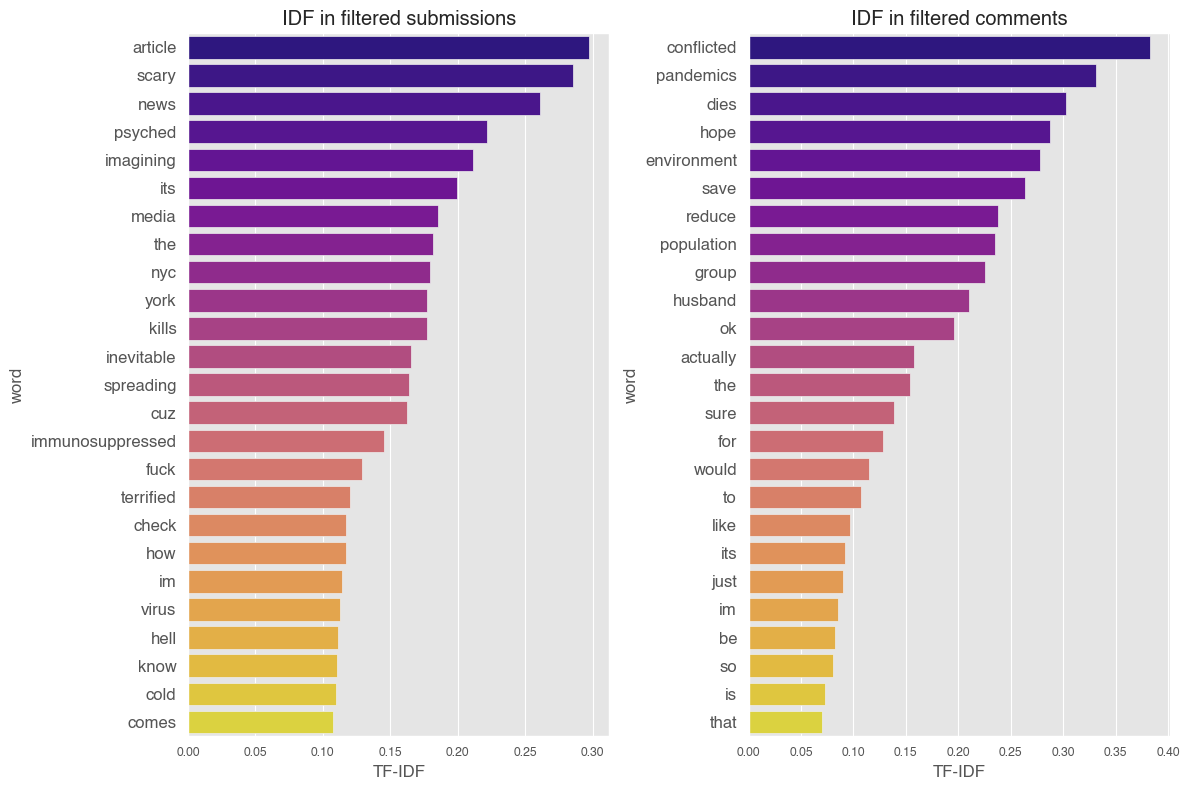

In [121]:
fig, [ax1, ax2] = plt.subplots(figsize=(12,8), ncols=2)

sns.barplot(data=results_tf_idf_sub.iloc[0:25], x='TF-IDF', y='index', ax=ax1, orientation='horizontal',
           palette='plasma')
ax1.set_ylabel('word')
ax1.yaxis.set_tick_params(labelsize=12)
ax1.set_title('IDF in filtered submissions')

sns.barplot(data=results_tf_idf_comm.iloc[0:25], x='TF-IDF', y='index', ax=ax2, orientation='horizontal',
           palette='plasma')
ax2.set_ylabel('word')
ax2.yaxis.set_tick_params(labelsize=12)
ax2.set_title('IDF in filtered comments')

plt.tight_layout()
plt.show();

### Frequency Distribution <a class='anchor' id='freq-dist'><a/>

In [122]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist 

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('shakespeare')
#nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words("english")

#tfidf

In [123]:
# Tokenize
def tokenize(data):
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+http\S+')
    data['tokenized'] = data['body'].apply(lambda x: tokenizer.tokenize(x))
    return data

In [124]:
# Remove stopwords 
def remove_sw(data):
    data['token_without_sw'] = data['tokenized'].apply(lambda x: [word for word in x if not word in stopwords and len(word) > 2 and not word in ["www", "http", "https", "reddit", "cricket", "nan"]])
    return data

In [125]:
%%capture

df_complete = pd.concat([df_submissions, df_comments])
tokenize(df_complete)
remove_sw(df_complete)

In [126]:
all_words = " ".join(x for x in df_complete['token_without_sw'].apply(lambda x: " ".join(x))).split(" ")
fd = nltk.FreqDist([w.lower() for w in all_words])

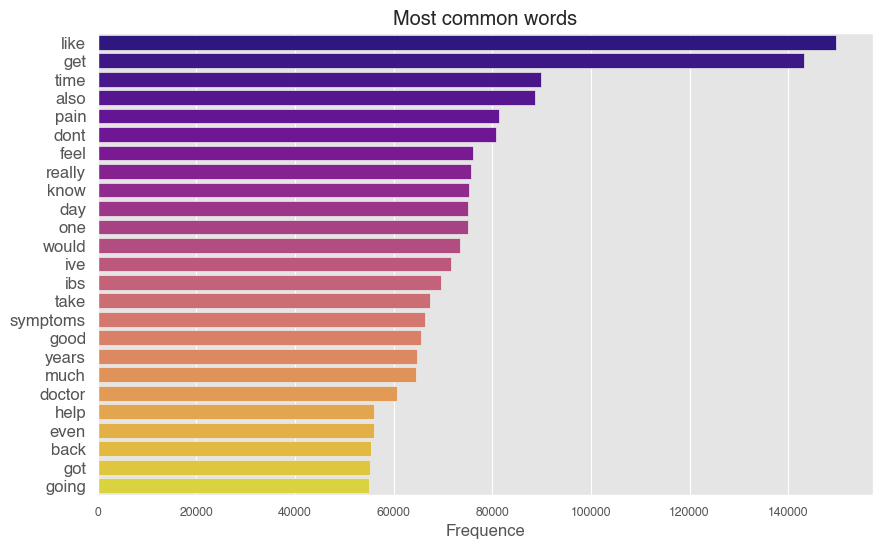

In [127]:
# Most common words
common_freq = dict(fd.most_common(25))
common_freq = pd.Series(common_freq)

fig, ax = plt.subplots(figsize=(10,6))

# Plot 1
ax.set_title('Most common words')
sns.barplot(y=common_freq.index, x=common_freq, orient='h', ax=ax, palette='plasma')
ax.set_xlabel('Frequence')
ax.yaxis.set_tick_params(labelsize=12)

plt.show();

### Concordances

In the context of NLP, a concordance is a collection of word locations along with their context.

In [128]:
all_words = " ".join(x for x in df_complete['tokenized'].apply(lambda x: " ".join(x))).split(" ")
text = nltk.Text(all_words)

In [129]:
print(colored('\nSOME CONCORDANCES\n', color='blue'))
doctor_conc = text.concordance('doctor', lines=5)
print('\n')
covid_conc = text.concordance('covid', lines=5)
print('\n')
worse_conc = text.concordance('worse', lines=10)
print('\n')
getting_conc = text.concordance('getting', lines=5)
print('\n')
vaccine_conc = text.concordance('vaccine', lines=5)


SOME CONCORDANCES

Displaying 5 of 60610 matches:
dren s mercy and although I like my doctor I do feel like she very much ignore
sdiagnosed malady I m talking to my doctor this morning and lining up a test I
I have an appointment with a new GI doctor at a new practice in July I definit
on t know what to say to my current doctor I m supposed to have an appointment
 to have an appointment with my OLD doctor on the 3rd NEW doctor on the 10th W


Displaying 5 of 10957 matches:
oken with their consultant regarding COVID 19 aka Coronavirus Hey there I m new
ky Any advice I know everything with Covid 19 is still so new but I haven t bee
Remicade and the risk of contracting Covid I m not due for my next infusion for
ething Much appreciated With all the COVID 19 fears I m confused I was always t
te I m sure my classmates don t have covid but seems like everyone had the flu 


Displaying 10 of 27514 matches:
zy and was wondering if I would have worse symptoms if I didn t smoke You have 
 my sym

###  Wordcloud

In [130]:
from wordcloud import WordCloud, STOPWORDS

In [131]:
all_words = " ".join(x for x in df_complete['token_without_sw'].apply(lambda x: " ".join(x))).split(" ")
s = ' '.join(all_words)

wc = WordCloud(width=4000,
                stopwords=stopwords,
                height=3200,
                max_font_size=500,
                max_words=100,
                collocations=False,
                background_color='black').generate(s)

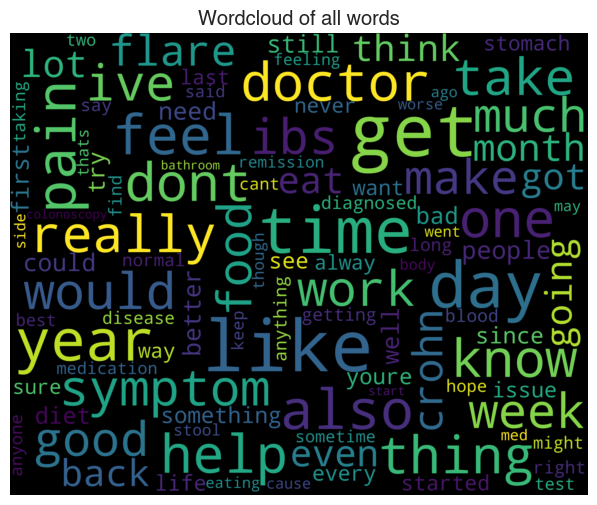

In [132]:
fig, ax = plt.subplots(figsize=(16,6))

ax.imshow(wc, interpolation="bilinear")
ax.axis('off')
ax.set_title('Wordcloud of all words')

plt.show();